## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


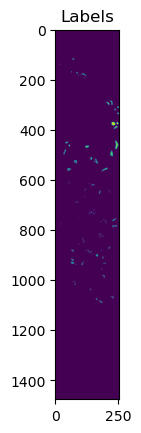

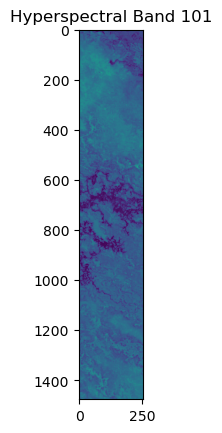

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
S


All datasets saved to the 'indices' folder.
(140, 5, 5, 145)
(70, 5, 5, 145)
(3038, 5, 5, 145)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 140
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2215, PSNR: -8.7265


Epoch [1/50] Training Loss: 0.2150, PSNR: -8.7179
	[Val]   Batch [1/11] Loss: 0.2076, PSNR: -6.2094
	[Val]   Batch [10/11] Loss: 0.2077, PSNR: -8.4483
Epoch [1/50] Validation Loss: 0.2076, PSNR: -8.1404

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.2015, PSNR: -9.5016


Epoch [2/50] Training Loss: 0.1930, PSNR: -8.3690
	[Val]   Batch [1/11] Loss: 0.1817, PSNR: -5.6297
	[Val]   Batch [10/11] Loss: 0.1819, PSNR: -7.8703
Epoch [2/50] Validation Loss: 0.1816, PSNR: -7.5591

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1792, PSNR: -8.5107


Epoch [3/50] Training Loss: 0.1719, PSNR: -7.9900
	[Val]   Batch [1/11] Loss: 0.1565, PSNR: -4.9833
	[Val]   Batch [10/11] Loss: 0.1569, PSNR: -7.2283
Epoch [3/50] Validation Loss: 0.1566, PSNR: -6.9167

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1574, PSNR: -7.5944


Epoch [4/50] Training Loss: 0.1515, PSNR: -7.1417
	[Val]   Batch [1/11] Loss: 0.1348, PSNR: -4.3332
	[Val]   Batch [10/11] Loss: 0.1351, PSNR: -6.5792
Epoch [4/50] Validation Loss: 0.1349, PSNR: -6.2693

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1388, PSNR: -7.2640


Epoch [5/50] Training Loss: 0.1321, PSNR: -6.6725
	[Val]   Batch [1/11] Loss: 0.1179, PSNR: -3.7518
	[Val]   Batch [10/11] Loss: 0.1181, PSNR: -5.9956
Epoch [5/50] Validation Loss: 0.1179, PSNR: -5.6847

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1203, PSNR: -7.2601


Epoch [6/50] Training Loss: 0.1142, PSNR: -6.0952
	[Val]   Batch [1/11] Loss: 0.1005, PSNR: -3.0571
	[Val]   Batch [10/11] Loss: 0.1006, PSNR: -5.2985
Epoch [6/50] Validation Loss: 0.1005, PSNR: -4.9888

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.1048, PSNR: -7.1732


Epoch [7/50] Training Loss: 0.0982, PSNR: -5.4366
	[Val]   Batch [1/11] Loss: 0.0867, PSNR: -2.4180
	[Val]   Batch [10/11] Loss: 0.0868, PSNR: -4.6596
Epoch [7/50] Validation Loss: 0.0867, PSNR: -4.3493

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0891, PSNR: -6.4680


Epoch [8/50] Training Loss: 0.0844, PSNR: -4.6542
	[Val]   Batch [1/11] Loss: 0.0748, PSNR: -1.7748
	[Val]   Batch [10/11] Loss: 0.0749, PSNR: -4.0156
Epoch [8/50] Validation Loss: 0.0748, PSNR: -3.7050

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0767, PSNR: -6.2461


Epoch [9/50] Training Loss: 0.0727, PSNR: -4.0931
	[Val]   Batch [1/11] Loss: 0.0652, PSNR: -1.1808
	[Val]   Batch [10/11] Loss: 0.0653, PSNR: -3.4213
Epoch [9/50] Validation Loss: 0.0652, PSNR: -3.1105

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0646, PSNR: -1.1394


Epoch [10/50] Training Loss: 0.0630, PSNR: -3.4549
	[Val]   Batch [1/11] Loss: 0.0567, PSNR: -0.5762
	[Val]   Batch [10/11] Loss: 0.0568, PSNR: -2.8184
Epoch [10/50] Validation Loss: 0.0567, PSNR: -2.5060

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0569, PSNR: -0.5869


Epoch [11/50] Training Loss: 0.0548, PSNR: -2.8562
	[Val]   Batch [1/11] Loss: 0.0501, PSNR: -0.0381
	[Val]   Batch [10/11] Loss: 0.0502, PSNR: -2.2792
Epoch [11/50] Validation Loss: 0.0501, PSNR: -1.9685

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0511, PSNR: -0.1244


Epoch [12/50] Training Loss: 0.0480, PSNR: -2.3513
	[Val]   Batch [1/11] Loss: 0.0443, PSNR: 0.5018
	[Val]   Batch [10/11] Loss: 0.0443, PSNR: -1.7388
Epoch [12/50] Validation Loss: 0.0443, PSNR: -1.4287

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0438, PSNR: -2.2566


Epoch [13/50] Training Loss: 0.0423, PSNR: -1.6974
	[Val]   Batch [1/11] Loss: 0.0399, PSNR: 0.9502
	[Val]   Batch [10/11] Loss: 0.0400, PSNR: -1.2896
Epoch [13/50] Validation Loss: 0.0399, PSNR: -0.9796

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0388, PSNR: -0.8570


Epoch [14/50] Training Loss: 0.0376, PSNR: -1.1262
	[Val]   Batch [1/11] Loss: 0.0354, PSNR: 1.4695
	[Val]   Batch [10/11] Loss: 0.0355, PSNR: -0.7700
Epoch [14/50] Validation Loss: 0.0354, PSNR: -0.4597

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0351, PSNR: -2.2206


Epoch [15/50] Training Loss: 0.0336, PSNR: -0.7818
	[Val]   Batch [1/11] Loss: 0.0319, PSNR: 1.9227
	[Val]   Batch [10/11] Loss: 0.0319, PSNR: -0.3161
Epoch [15/50] Validation Loss: 0.0319, PSNR: -0.0060

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0315, PSNR: -2.3559


Epoch [16/50] Training Loss: 0.0302, PSNR: -0.1929
	[Val]   Batch [1/11] Loss: 0.0290, PSNR: 2.3316
	[Val]   Batch [10/11] Loss: 0.0291, PSNR: 0.0939
Epoch [16/50] Validation Loss: 0.0290, PSNR: 0.4029

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0283, PSNR: -0.9765


Epoch [17/50] Training Loss: 0.0273, PSNR: 0.0162
	[Val]   Batch [1/11] Loss: 0.0260, PSNR: 2.8064
	[Val]   Batch [10/11] Loss: 0.0261, PSNR: 0.5680
Epoch [17/50] Validation Loss: 0.0260, PSNR: 0.8780

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0261, PSNR: -1.9110


Epoch [18/50] Training Loss: 0.0248, PSNR: 0.5925
	[Val]   Batch [1/11] Loss: 0.0239, PSNR: 3.1778
	[Val]   Batch [10/11] Loss: 0.0239, PSNR: 0.9400
Epoch [18/50] Validation Loss: 0.0239, PSNR: 1.2500

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0234, PSNR: 0.3370


Epoch [19/50] Training Loss: 0.0226, PSNR: 1.0116
	[Val]   Batch [1/11] Loss: 0.0220, PSNR: 3.5465
	[Val]   Batch [10/11] Loss: 0.0220, PSNR: 1.3093
Epoch [19/50] Validation Loss: 0.0219, PSNR: 1.6187

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0217, PSNR: -0.6217


Epoch [20/50] Training Loss: 0.0207, PSNR: 1.2692
	[Val]   Batch [1/11] Loss: 0.0199, PSNR: 3.9663
	[Val]   Batch [10/11] Loss: 0.0199, PSNR: 1.7296
Epoch [20/50] Validation Loss: 0.0199, PSNR: 2.0392

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0193, PSNR: 1.6834


Epoch [21/50] Training Loss: 0.0190, PSNR: 1.6855
	[Val]   Batch [1/11] Loss: 0.0187, PSNR: 4.2489
	[Val]   Batch [10/11] Loss: 0.0187, PSNR: 2.0119
Epoch [21/50] Validation Loss: 0.0187, PSNR: 2.3211

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0178, PSNR: 2.5215


Epoch [22/50] Training Loss: 0.0176, PSNR: 2.0891
	[Val]   Batch [1/11] Loss: 0.0171, PSNR: 4.6386
	[Val]   Batch [10/11] Loss: 0.0171, PSNR: 2.4012
Epoch [22/50] Validation Loss: 0.0171, PSNR: 2.7118

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0161, PSNR: 4.8984


Epoch [23/50] Training Loss: 0.0163, PSNR: 2.5197
	[Val]   Batch [1/11] Loss: 0.0158, PSNR: 4.9685
	[Val]   Batch [10/11] Loss: 0.0158, PSNR: 2.7314
Epoch [23/50] Validation Loss: 0.0158, PSNR: 3.0419

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0154, PSNR: 3.4948


Epoch [24/50] Training Loss: 0.0151, PSNR: 2.8565
	[Val]   Batch [1/11] Loss: 0.0148, PSNR: 5.2730
	[Val]   Batch [10/11] Loss: 0.0148, PSNR: 3.0355
Epoch [24/50] Validation Loss: 0.0147, PSNR: 3.3460

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0143, PSNR: 0.9626


Epoch [25/50] Training Loss: 0.0140, PSNR: 3.1097
	[Val]   Batch [1/11] Loss: 0.0137, PSNR: 5.6014
	[Val]   Batch [10/11] Loss: 0.0137, PSNR: 3.3635
Epoch [25/50] Validation Loss: 0.0137, PSNR: 3.6748

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0136, PSNR: 1.4124


Epoch [26/50] Training Loss: 0.0131, PSNR: 3.2917
	[Val]   Batch [1/11] Loss: 0.0129, PSNR: 5.8731
	[Val]   Batch [10/11] Loss: 0.0129, PSNR: 3.6355
Epoch [26/50] Validation Loss: 0.0128, PSNR: 3.9471

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0124, PSNR: 4.0927


Epoch [27/50] Training Loss: 0.0123, PSNR: 3.6785
	[Val]   Batch [1/11] Loss: 0.0121, PSNR: 6.1423
	[Val]   Batch [10/11] Loss: 0.0121, PSNR: 3.9051
Epoch [27/50] Validation Loss: 0.0121, PSNR: 4.2165

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0119, PSNR: 2.4898


Epoch [28/50] Training Loss: 0.0115, PSNR: 3.8148
	[Val]   Batch [1/11] Loss: 0.0113, PSNR: 6.4218
	[Val]   Batch [10/11] Loss: 0.0113, PSNR: 4.1852
Epoch [28/50] Validation Loss: 0.0113, PSNR: 4.4959

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0111, PSNR: 4.5564


Epoch [29/50] Training Loss: 0.0108, PSNR: 4.1206
	[Val]   Batch [1/11] Loss: 0.0107, PSNR: 6.6793
	[Val]   Batch [10/11] Loss: 0.0107, PSNR: 4.4433
Epoch [29/50] Validation Loss: 0.0107, PSNR: 4.7529

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0106, PSNR: 6.7000


Epoch [30/50] Training Loss: 0.0102, PSNR: 4.3870
	[Val]   Batch [1/11] Loss: 0.0100, PSNR: 6.9558
	[Val]   Batch [10/11] Loss: 0.0100, PSNR: 4.7196
Epoch [30/50] Validation Loss: 0.0100, PSNR: 5.0292

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0101, PSNR: 4.1319


Epoch [31/50] Training Loss: 0.0096, PSNR: 4.7193
	[Val]   Batch [1/11] Loss: 0.0095, PSNR: 7.1995
	[Val]   Batch [10/11] Loss: 0.0095, PSNR: 4.9634
Epoch [31/50] Validation Loss: 0.0095, PSNR: 5.2731

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0093, PSNR: 3.0215


Epoch [32/50] Training Loss: 0.0090, PSNR: 4.7840
	[Val]   Batch [1/11] Loss: 0.0090, PSNR: 7.4437
	[Val]   Batch [10/11] Loss: 0.0090, PSNR: 5.2082
Epoch [32/50] Validation Loss: 0.0089, PSNR: 5.5175

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0086, PSNR: 4.7902


Epoch [33/50] Training Loss: 0.0086, PSNR: 5.2365
	[Val]   Batch [1/11] Loss: 0.0085, PSNR: 7.6931
	[Val]   Batch [10/11] Loss: 0.0085, PSNR: 5.4570
Epoch [33/50] Validation Loss: 0.0084, PSNR: 5.7667

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0083, PSNR: 5.3808


Epoch [34/50] Training Loss: 0.0081, PSNR: 5.3666
	[Val]   Batch [1/11] Loss: 0.0080, PSNR: 7.9086
	[Val]   Batch [10/11] Loss: 0.0080, PSNR: 5.6731
Epoch [34/50] Validation Loss: 0.0080, PSNR: 5.9820

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0079, PSNR: 6.6817


Epoch [35/50] Training Loss: 0.0077, PSNR: 5.6349
	[Val]   Batch [1/11] Loss: 0.0076, PSNR: 8.1427
	[Val]   Batch [10/11] Loss: 0.0076, PSNR: 5.9071
Epoch [35/50] Validation Loss: 0.0076, PSNR: 6.2165

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0072, PSNR: 5.4775


Epoch [36/50] Training Loss: 0.0073, PSNR: 5.6953
	[Val]   Batch [1/11] Loss: 0.0073, PSNR: 8.3399
	[Val]   Batch [10/11] Loss: 0.0073, PSNR: 6.1042
Epoch [36/50] Validation Loss: 0.0073, PSNR: 6.4137

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0073, PSNR: 6.3865


Epoch [37/50] Training Loss: 0.0069, PSNR: 6.2289
	[Val]   Batch [1/11] Loss: 0.0069, PSNR: 8.5946
	[Val]   Batch [10/11] Loss: 0.0069, PSNR: 6.3584
Epoch [37/50] Validation Loss: 0.0069, PSNR: 6.6688

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0067, PSNR: 4.0936


Epoch [38/50] Training Loss: 0.0066, PSNR: 6.1794
	[Val]   Batch [1/11] Loss: 0.0066, PSNR: 8.7915
	[Val]   Batch [10/11] Loss: 0.0066, PSNR: 6.5551
Epoch [38/50] Validation Loss: 0.0066, PSNR: 6.8660

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0065, PSNR: 4.3980


Epoch [39/50] Training Loss: 0.0063, PSNR: 6.3926
	[Val]   Batch [1/11] Loss: 0.0063, PSNR: 8.9827
	[Val]   Batch [10/11] Loss: 0.0063, PSNR: 6.7468
Epoch [39/50] Validation Loss: 0.0063, PSNR: 7.0577

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0062, PSNR: 9.0462


Epoch [40/50] Training Loss: 0.0060, PSNR: 6.5382
	[Val]   Batch [1/11] Loss: 0.0060, PSNR: 9.1737
	[Val]   Batch [10/11] Loss: 0.0060, PSNR: 6.9393
Epoch [40/50] Validation Loss: 0.0060, PSNR: 7.2492

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0058, PSNR: 7.7795


Epoch [41/50] Training Loss: 0.0057, PSNR: 6.8511
	[Val]   Batch [1/11] Loss: 0.0058, PSNR: 9.3575
	[Val]   Batch [10/11] Loss: 0.0058, PSNR: 7.1233
Epoch [41/50] Validation Loss: 0.0058, PSNR: 7.4333

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0057, PSNR: 7.7891


Epoch [42/50] Training Loss: 0.0055, PSNR: 6.9929
	[Val]   Batch [1/11] Loss: 0.0055, PSNR: 9.5900
	[Val]   Batch [10/11] Loss: 0.0055, PSNR: 7.3557
Epoch [42/50] Validation Loss: 0.0055, PSNR: 7.6664

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0054, PSNR: 7.2078


Epoch [43/50] Training Loss: 0.0052, PSNR: 7.5630
	[Val]   Batch [1/11] Loss: 0.0052, PSNR: 9.7662
	[Val]   Batch [10/11] Loss: 0.0052, PSNR: 7.5314
Epoch [43/50] Validation Loss: 0.0052, PSNR: 7.8426

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0049, PSNR: 8.4172


Epoch [44/50] Training Loss: 0.0050, PSNR: 7.4814
	[Val]   Batch [1/11] Loss: 0.0050, PSNR: 9.9581
	[Val]   Batch [10/11] Loss: 0.0050, PSNR: 7.7230
Epoch [44/50] Validation Loss: 0.0050, PSNR: 8.0345

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0047, PSNR: 8.2628


Epoch [45/50] Training Loss: 0.0048, PSNR: 7.4617
	[Val]   Batch [1/11] Loss: 0.0048, PSNR: 10.1319
	[Val]   Batch [10/11] Loss: 0.0048, PSNR: 7.8973
Epoch [45/50] Validation Loss: 0.0048, PSNR: 8.2085

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0046, PSNR: 7.3677


Epoch [46/50] Training Loss: 0.0046, PSNR: 7.9612
	[Val]   Batch [1/11] Loss: 0.0046, PSNR: 10.3591
	[Val]   Batch [10/11] Loss: 0.0046, PSNR: 8.1247
Epoch [46/50] Validation Loss: 0.0046, PSNR: 8.4358

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0043, PSNR: 8.2024


Epoch [47/50] Training Loss: 0.0044, PSNR: 8.1583
	[Val]   Batch [1/11] Loss: 0.0044, PSNR: 10.5523
	[Val]   Batch [10/11] Loss: 0.0044, PSNR: 8.3186
Epoch [47/50] Validation Loss: 0.0044, PSNR: 8.6285

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0044, PSNR: 8.9767


Epoch [48/50] Training Loss: 0.0042, PSNR: 8.1986
	[Val]   Batch [1/11] Loss: 0.0042, PSNR: 10.7001
	[Val]   Batch [10/11] Loss: 0.0042, PSNR: 8.4666
Epoch [48/50] Validation Loss: 0.0042, PSNR: 8.7766

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0042, PSNR: 9.1090


Epoch [49/50] Training Loss: 0.0041, PSNR: 8.4348
	[Val]   Batch [1/11] Loss: 0.0040, PSNR: 10.8989
	[Val]   Batch [10/11] Loss: 0.0040, PSNR: 8.6664
Epoch [49/50] Validation Loss: 0.0040, PSNR: 8.9752

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0040, PSNR: 9.4103


Epoch [50/50] Training Loss: 0.0039, PSNR: 8.7032
	[Val]   Batch [1/11] Loss: 0.0039, PSNR: 11.0325
	[Val]   Batch [10/11] Loss: 0.0039, PSNR: 8.8004
Epoch [50/50] Validation Loss: 0.0039, PSNR: 9.1097


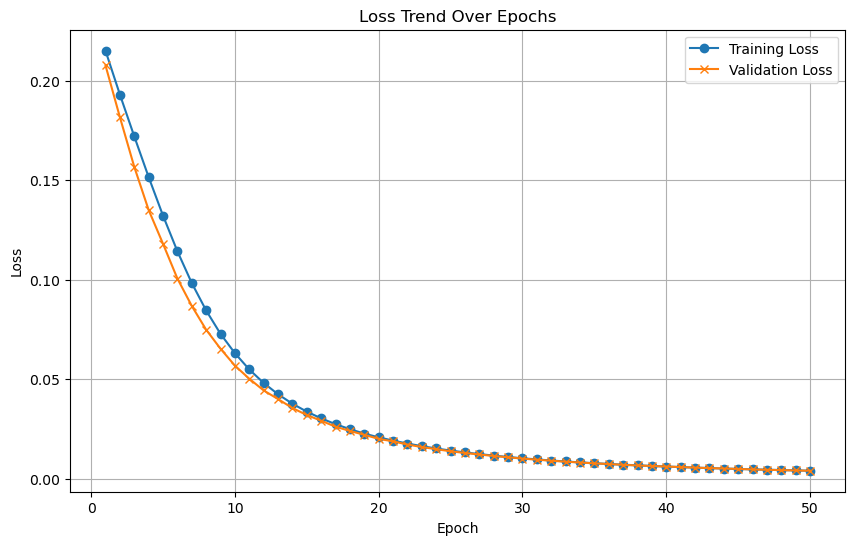

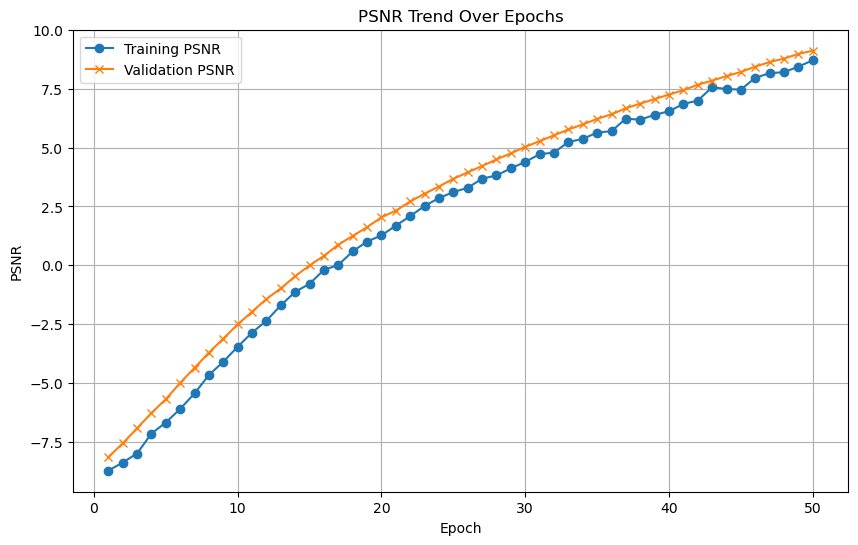

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/12 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6314
    Validation Batch [1/1], Loss: 2.6450
Validation Loss: 2.6450, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6450. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5960
    Validation Batch [1/1], Loss: 2.6450
Validation Loss: 2.6450, Validation Accuracy: 7.14%
Validation loss improved from 2.6450 to 2.6450. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5667
    Validation Batch [1/1], Loss: 2.6450
Validation Loss: 2.6450, Validation Accuracy: 7.14%
Validation loss improved from 2.6450 to 2.6450. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5308
    Validation Batch [1/1], Loss: 2.6449
Validation Loss: 2.6449, Validation Accuracy: 7.14%
Validation loss improved from 2.6450 to 2.6449. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] complete

    Validation Batch [1/1], Loss: 2.6448
Validation Loss: 2.6448, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [16/1000] - Training
Epoch [16/1000] completed, Average Training Loss: 2.3792
    Validation Batch [1/1], Loss: 2.6448
Validation Loss: 2.6448, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.3556
    Validation Batch [1/1], Loss: 2.6449
Validation Loss: 2.6449, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.3447
    Validation Batch [1/1], Loss: 2.6449
Validation Loss: 2.6449, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.3522
    Validation Batch [1/1], Loss: 2.6449
Validation Loss: 2.6449, Valida

Epoch [24/1000] completed, Average Training Loss: 2.3148
    Validation Batch [1/1], Loss: 2.6450
Validation Loss: 2.6450, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.3081
    Validation Batch [1/1], Loss: 2.6450
Validation Loss: 2.6450, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.3104
    Validation Batch [1/1], Loss: 2.6449
Validation Loss: 2.6449, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 2.2778
    Validation Batch [1/1], Loss: 2.6449
Validation Loss: 2.6449, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [28/1000] - Training
Epoch [28/1000] completed, Average Training Loss: 2.2608
    Validat

    Validation Batch [1/1], Loss: 2.6428
Validation Loss: 2.6428, Validation Accuracy: 7.14%
Validation loss improved from 2.6430 to 2.6428. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.1857
    Validation Batch [1/1], Loss: 2.6425
Validation Loss: 2.6425, Validation Accuracy: 7.14%
Validation loss improved from 2.6428 to 2.6425. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.1408
    Validation Batch [1/1], Loss: 2.6421
Validation Loss: 2.6421, Validation Accuracy: 7.14%
Validation loss improved from 2.6425 to 2.6421. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.1709
    Validation Batch [1/1], Loss: 2.6417
Validation Loss: 2.6417, Validation Accuracy: 7.14%
Validation loss improved from 2.6421 to 2.6417. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 2.1675
    Validati

    Validation Batch [1/1], Loss: 2.6345
Validation Loss: 2.6345, Validation Accuracy: 7.14%
Validation loss improved from 2.6364 to 2.6345. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 2.0971
    Validation Batch [1/1], Loss: 2.6327
Validation Loss: 2.6327, Validation Accuracy: 7.14%
Validation loss improved from 2.6345 to 2.6327. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 2.0792
    Validation Batch [1/1], Loss: 2.6310
Validation Loss: 2.6310, Validation Accuracy: 7.14%
Validation loss improved from 2.6327 to 2.6310. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 2.0609
    Validation Batch [1/1], Loss: 2.6294
Validation Loss: 2.6294, Validation Accuracy: 7.14%
Validation loss improved from 2.6310 to 2.6294. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 2.0670
    Validati

Epoch [63/1000] completed, Average Training Loss: 1.9791
    Validation Batch [1/1], Loss: 2.5671
Validation Loss: 2.5671, Validation Accuracy: 12.86%
Validation loss improved from 2.5789 to 2.5671. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 1.9831
    Validation Batch [1/1], Loss: 2.5547
Validation Loss: 2.5547, Validation Accuracy: 15.71%
Validation loss improved from 2.5671 to 2.5547. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 1.9599
    Validation Batch [1/1], Loss: 2.5433
Validation Loss: 2.5433, Validation Accuracy: 15.71%
Validation loss improved from 2.5547 to 2.5433. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [66/1000] completed, Average Training Loss: 1.9601
    Validation Batch [1/1], Loss: 2.5314
Validation Loss: 2.5314, Validation Accuracy: 15.71%
Validation loss improved from 2.5433 to 2.5314. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [6

Epoch [73/1000] completed, Average Training Loss: 1.8902
    Validation Batch [1/1], Loss: 2.4178
Validation Loss: 2.4178, Validation Accuracy: 32.86%
Validation loss improved from 2.4452 to 2.4178. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 1.8655
    Validation Batch [1/1], Loss: 2.3841
Validation Loss: 2.3841, Validation Accuracy: 38.57%
Validation loss improved from 2.4178 to 2.3841. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 1.8779
    Validation Batch [1/1], Loss: 2.3604
Validation Loss: 2.3604, Validation Accuracy: 41.43%
Validation loss improved from 2.3841 to 2.3604. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 1.8827
    Validation Batch [1/1], Loss: 2.3442
Validation Loss: 2.3442, Validation Accuracy: 41.43%
Validation loss improved from 2.3604 to 2.3442. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [7

    Validation Batch [1/1], Loss: 2.0654
Validation Loss: 2.0654, Validation Accuracy: 54.29%
Validation loss improved from 2.1093 to 2.0654. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.7867
    Validation Batch [1/1], Loss: 2.0595
Validation Loss: 2.0595, Validation Accuracy: 55.71%
Validation loss improved from 2.0654 to 2.0595. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.7562
    Validation Batch [1/1], Loss: 2.0546
Validation Loss: 2.0546, Validation Accuracy: 58.57%
Validation loss improved from 2.0595 to 2.0546. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.7623
    Validation Batch [1/1], Loss: 2.0265
Validation Loss: 2.0265, Validation Accuracy: 57.14%
Validation loss improved from 2.0546 to 2.0265. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 1.7329
    Vali

    Validation Batch [1/1], Loss: 1.8849
Validation Loss: 1.8849, Validation Accuracy: 64.29%
Validation loss improved from 1.8952 to 1.8849. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.7047
    Validation Batch [1/1], Loss: 1.8763
Validation Loss: 1.8763, Validation Accuracy: 64.29%
Validation loss improved from 1.8849 to 1.8763. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.6559
    Validation Batch [1/1], Loss: 1.8500
Validation Loss: 1.8500, Validation Accuracy: 64.29%
Validation loss improved from 1.8763 to 1.8500. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.6598
    Validation Batch [1/1], Loss: 1.8173
Validation Loss: 1.8173, Validation Accuracy: 68.57%
Validation loss improved from 1.8500 to 1.8173. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.6350
    Va

Epoch [112/1000] completed, Average Training Loss: 1.5405
    Validation Batch [1/1], Loss: 1.6957
Validation Loss: 1.6957, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 1.5223
    Validation Batch [1/1], Loss: 1.6740
Validation Loss: 1.6740, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Average Training Loss: 1.5091
    Validation Batch [1/1], Loss: 1.6600
Validation Loss: 1.6600, Validation Accuracy: 72.86%
Validation loss improved from 1.6707 to 1.6600. Saving model...

LOG: Epoch [115/1000] - Training
Epoch [115/1000] completed, Average Training Loss: 1.5310
    Validation Batch [1/1], Loss: 1.6442
Validation Loss: 1.6442, Validation Accuracy: 74.29%
Validation loss improved from 1.6600 to 1.6442. Saving model...

LOG: Epoch [116/1000] - Training
Epoch [116/1000] completed, Av

Epoch [121/1000] completed, Average Training Loss: 1.4382
    Validation Batch [1/1], Loss: 1.5831
Validation Loss: 1.5831, Validation Accuracy: 74.29%
Validation loss improved from 1.5833 to 1.5831. Saving model...

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.4726
    Validation Batch [1/1], Loss: 1.5661
Validation Loss: 1.5661, Validation Accuracy: 75.71%
Validation loss improved from 1.5831 to 1.5661. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 1.4395
    Validation Batch [1/1], Loss: 1.5476
Validation Loss: 1.5476, Validation Accuracy: 75.71%
Validation loss improved from 1.5661 to 1.5476. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 1.4466
    Validation Batch [1/1], Loss: 1.5376
Validation Loss: 1.5376, Validation Accuracy: 77.14%
Validation loss improved from 1.5476 to 1.5376. Saving model...

LOG: Epoch [125/1000] - Training


    Validation Batch [1/1], Loss: 1.4491
Validation Loss: 1.4491, Validation Accuracy: 74.29%
Validation loss improved from 1.4619 to 1.4491. Saving model...

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 1.2999
    Validation Batch [1/1], Loss: 1.4278
Validation Loss: 1.4278, Validation Accuracy: 75.71%
Validation loss improved from 1.4491 to 1.4278. Saving model...

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 1.2682
    Validation Batch [1/1], Loss: 1.4251
Validation Loss: 1.4251, Validation Accuracy: 75.71%
Validation loss improved from 1.4278 to 1.4251. Saving model...

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 1.2807
    Validation Batch [1/1], Loss: 1.4401
Validation Loss: 1.4401, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.2834
    Validation 

Epoch [147/1000] completed, Average Training Loss: 1.2218
    Validation Batch [1/1], Loss: 1.3673
Validation Loss: 1.3673, Validation Accuracy: 77.14%
Validation loss improved from 1.3830 to 1.3673. Saving model...

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 1.1960
    Validation Batch [1/1], Loss: 1.3579
Validation Loss: 1.3579, Validation Accuracy: 77.14%
Validation loss improved from 1.3673 to 1.3579. Saving model...

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 1.2038
    Validation Batch [1/1], Loss: 1.3616
Validation Loss: 1.3616, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 1.1909
    Validation Batch [1/1], Loss: 1.3691
Validation Loss: 1.3691, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Av

Epoch [162/1000] completed, Average Training Loss: 1.1199
    Validation Batch [1/1], Loss: 1.2602
Validation Loss: 1.2602, Validation Accuracy: 82.86%
Validation loss improved from 1.2642 to 1.2602. Saving model...

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 1.1033
    Validation Batch [1/1], Loss: 1.2602
Validation Loss: 1.2602, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 1.0823
    Validation Batch [1/1], Loss: 1.2641
Validation Loss: 1.2641, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 1.0618
    Validation Batch [1/1], Loss: 1.2337
Validation Loss: 1.2337, Validation Accuracy: 81.43%
Validation loss improved from 1.2602 to 1.2337. Saving model...

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Av

Epoch [169/1000] completed, Average Training Loss: 1.0789
    Validation Batch [1/1], Loss: 1.2118
Validation Loss: 1.2118, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 1.0169
    Validation Batch [1/1], Loss: 1.2135
Validation Loss: 1.2135, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 1.0158
    Validation Batch [1/1], Loss: 1.1840
Validation Loss: 1.1840, Validation Accuracy: 87.14%
Validation loss improved from 1.2034 to 1.1840. Saving model...

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training Loss: 1.0125
    Validation Batch [1/1], Loss: 1.1744
Validation Loss: 1.1744, Validation Accuracy: 87.14%
Validation loss improved from 1.1840 to 1.1744. Saving model...

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Av

Epoch [186/1000] completed, Average Training Loss: 0.9280
    Validation Batch [1/1], Loss: 1.0720
Validation Loss: 1.0720, Validation Accuracy: 88.57%
Validation loss improved from 1.0779 to 1.0720. Saving model...

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.8957
    Validation Batch [1/1], Loss: 1.0830
Validation Loss: 1.0830, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.8976
    Validation Batch [1/1], Loss: 1.0846
Validation Loss: 1.0846, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.8818
    Validation Batch [1/1], Loss: 1.0757
Validation Loss: 1.0757, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.0390
Validation Loss: 1.0390, Validation Accuracy: 88.57%
Validation loss improved from 1.0498 to 1.0390. Saving model...

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training Loss: 0.8266
    Validation Batch [1/1], Loss: 1.0434
Validation Loss: 1.0434, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [195/1000] - Training
Epoch [195/1000] completed, Average Training Loss: 0.8420
    Validation Batch [1/1], Loss: 1.0544
Validation Loss: 1.0544, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [196/1000] - Training
Epoch [196/1000] completed, Average Training Loss: 0.8257
    Validation Batch [1/1], Loss: 1.0668
Validation Loss: 1.0668, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 0.8344
    Validation Batch [1/1], Loss: 1.0619
Vali

    Validation Batch [1/1], Loss: 0.9415
Validation Loss: 0.9415, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.6889
    Validation Batch [1/1], Loss: 0.9197
Validation Loss: 0.9197, Validation Accuracy: 91.43%
Validation loss improved from 0.9233 to 0.9197. Saving model...

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.7003
    Validation Batch [1/1], Loss: 0.8977
Validation Loss: 0.8977, Validation Accuracy: 90.00%
Validation loss improved from 0.9197 to 0.8977. Saving model...

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.7122
    Validation Batch [1/1], Loss: 0.9028
Validation Loss: 0.9028, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.7030
    Validation Batch [1/1], Lo

Epoch [216/1000] completed, Average Training Loss: 0.6824
    Validation Batch [1/1], Loss: 0.8935
Validation Loss: 0.8935, Validation Accuracy: 88.57%
Validation loss improved from 0.8977 to 0.8935. Saving model...

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.6605
    Validation Batch [1/1], Loss: 0.8920
Validation Loss: 0.8920, Validation Accuracy: 88.57%
Validation loss improved from 0.8935 to 0.8920. Saving model...

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.6984
    Validation Batch [1/1], Loss: 0.8735
Validation Loss: 0.8735, Validation Accuracy: 91.43%
Validation loss improved from 0.8920 to 0.8735. Saving model...

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 0.6610
    Validation Batch [1/1], Loss: 0.8614
Validation Loss: 0.8614, Validation Accuracy: 91.43%
Validation loss improved from 0.8735 to 0.8614. Saving model...

LOG: Epoch [220/1000] - Training


Epoch [234/1000] completed, Average Training Loss: 0.6177
    Validation Batch [1/1], Loss: 0.7895
Validation Loss: 0.7895, Validation Accuracy: 92.86%
Validation loss improved from 0.8043 to 0.7895. Saving model...

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.5955
    Validation Batch [1/1], Loss: 0.7808
Validation Loss: 0.7808, Validation Accuracy: 92.86%
Validation loss improved from 0.7895 to 0.7808. Saving model...

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.5975
    Validation Batch [1/1], Loss: 0.7823
Validation Loss: 0.7823, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.5499
    Validation Batch [1/1], Loss: 0.7948
Validation Loss: 0.7948, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [238/1000] - Training


Epoch [238/1000] completed, Average Training Loss: 0.6025
    Validation Batch [1/1], Loss: 0.7894
Validation Loss: 0.7894, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.5651
    Validation Batch [1/1], Loss: 0.7818
Validation Loss: 0.7818, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.5268
    Validation Batch [1/1], Loss: 0.7695
Validation Loss: 0.7695, Validation Accuracy: 91.43%
Validation loss improved from 0.7808 to 0.7695. Saving model...

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.5471
    Validation Batch [1/1], Loss: 0.7852
Validation Loss: 0.7852, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training 

Epoch [260/1000] completed, Average Training Loss: 0.4437
    Validation Batch [1/1], Loss: 0.6755
Validation Loss: 0.6755, Validation Accuracy: 94.29%
Validation loss improved from 0.6799 to 0.6755. Saving model...

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.4482
    Validation Batch [1/1], Loss: 0.6565
Validation Loss: 0.6565, Validation Accuracy: 94.29%
Validation loss improved from 0.6755 to 0.6565. Saving model...

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.4298
    Validation Batch [1/1], Loss: 0.6451
Validation Loss: 0.6451, Validation Accuracy: 94.29%
Validation loss improved from 0.6565 to 0.6451. Saving model...

LOG: Epoch [263/1000] - Training
Epoch [263/1000] completed, Average Training Loss: 0.4196
    Validation Batch [1/1], Loss: 0.6383
Validation Loss: 0.6383, Validation Accuracy: 94.29%
Validation loss improved from 0.6451 to 0.6383. Saving model...

LOG: Epoch [264/1000] - Training


Epoch [286/1000] completed, Average Training Loss: 0.3857
    Validation Batch [1/1], Loss: 0.5790
Validation Loss: 0.5790, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.3233
    Validation Batch [1/1], Loss: 0.5882
Validation Loss: 0.5882, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.3451
    Validation Batch [1/1], Loss: 0.5747
Validation Loss: 0.5747, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.3564
    Validation Batch [1/1], Loss: 0.5683
Validation Loss: 0.5683, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.3544
  

    Validation Batch [1/1], Loss: 0.4838
Validation Loss: 0.4838, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.2698
    Validation Batch [1/1], Loss: 0.4837
Validation Loss: 0.4837, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.3004
    Validation Batch [1/1], Loss: 0.4839
Validation Loss: 0.4839, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.2765
    Validation Batch [1/1], Loss: 0.4774
Validation Loss: 0.4774, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.2416
    Validation Batch [1/1], Loss: 0.4783
Validation Loss: 0.

Epoch [339/1000] completed, Average Training Loss: 0.2271
    Validation Batch [1/1], Loss: 0.4361
Validation Loss: 0.4361, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.2247
    Validation Batch [1/1], Loss: 0.4229
Validation Loss: 0.4229, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.2103
    Validation Batch [1/1], Loss: 0.4155
Validation Loss: 0.4155, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.2107
    Validation Batch [1/1], Loss: 0.4095
Validation Loss: 0.4095, Validation Accuracy: 95.71%
Validation loss improved from 0.4113 to 0.4095. Saving model...

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training 

Epoch [363/1000] completed, Average Training Loss: 0.1782
    Validation Batch [1/1], Loss: 0.3997
Validation Loss: 0.3997, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training Loss: 0.1815
    Validation Batch [1/1], Loss: 0.3942
Validation Loss: 0.3942, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.1844
    Validation Batch [1/1], Loss: 0.3760
Validation Loss: 0.3760, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.1764
    Validation Batch [1/1], Loss: 0.3718
Validation Loss: 0.3718, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.1661
  

Epoch [386/1000] completed, Average Training Loss: 0.1678
    Validation Batch [1/1], Loss: 0.3565
Validation Loss: 0.3565, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.1333
    Validation Batch [1/1], Loss: 0.3731
Validation Loss: 0.3731, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.1634
    Validation Batch [1/1], Loss: 0.3738
Validation Loss: 0.3738, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.1500
    Validation Batch [1/1], Loss: 0.3453
Validation Loss: 0.3453, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.1606
  

Epoch [409/1000] completed, Average Training Loss: 0.1580
    Validation Batch [1/1], Loss: 0.3545
Validation Loss: 0.3545, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [410/1000] - Training
Epoch [410/1000] completed, Average Training Loss: 0.1268
    Validation Batch [1/1], Loss: 0.3323
Validation Loss: 0.3323, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [411/1000] - Training
Epoch [411/1000] completed, Average Training Loss: 0.1345
    Validation Batch [1/1], Loss: 0.3212
Validation Loss: 0.3212, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Average Training Loss: 0.1386
    Validation Batch [1/1], Loss: 0.3263
Validation Loss: 0.3263, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.151

    Validation Batch [1/1], Loss: 0.3039
Validation Loss: 0.3039, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.1160
    Validation Batch [1/1], Loss: 0.3042
Validation Loss: 0.3042, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [436/1000] - Training
Epoch [436/1000] completed, Average Training Loss: 0.1119
    Validation Batch [1/1], Loss: 0.2927
Validation Loss: 0.2927, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [437/1000] - Training
Epoch [437/1000] completed, Average Training Loss: 0.1176
    Validation Batch [1/1], Loss: 0.2899
Validation Loss: 0.2899, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [438/1000] - Training
Epoch [438/1000] completed, Average Training Loss: 0.0997
    Validation Batch [1/1], Loss: 0.2869
Validation Loss: 0.

Epoch [459/1000] completed, Average Training Loss: 0.0791
    Validation Batch [1/1], Loss: 0.2963
Validation Loss: 0.2963, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.1006
    Validation Batch [1/1], Loss: 0.2859
Validation Loss: 0.2859, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.0964
    Validation Batch [1/1], Loss: 0.2790
Validation Loss: 0.2790, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [462/1000] - Training
Epoch [462/1000] completed, Average Training Loss: 0.0853
    Validation Batch [1/1], Loss: 0.2831
Validation Loss: 0.2831, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [463/1000] - Training
Epoch [463/1000] completed, Average Training Loss: 0.1003
  

Epoch [484/1000] completed, Average Training Loss: 0.0884
    Validation Batch [1/1], Loss: 0.2663
Validation Loss: 0.2663, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.0842
    Validation Batch [1/1], Loss: 0.2648
Validation Loss: 0.2648, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [486/1000] - Training
Epoch [486/1000] completed, Average Training Loss: 0.0852
    Validation Batch [1/1], Loss: 0.2614
Validation Loss: 0.2614, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [487/1000] - Training
Epoch [487/1000] completed, Average Training Loss: 0.0855
    Validation Batch [1/1], Loss: 0.2680
Validation Loss: 0.2680, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [488/1000] - Training
Epoch [488/1000] completed, Average Training Loss: 0.0764
  

Epoch [507/1000] completed, Average Training Loss: 0.0742
    Validation Batch [1/1], Loss: 0.2817
Validation Loss: 0.2817, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [508/1000] - Training
Epoch [508/1000] completed, Average Training Loss: 0.0724
    Validation Batch [1/1], Loss: 0.2748
Validation Loss: 0.2748, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [509/1000] - Training
Epoch [509/1000] completed, Average Training Loss: 0.0784
    Validation Batch [1/1], Loss: 0.2630
Validation Loss: 0.2630, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [510/1000] - Training
Epoch [510/1000] completed, Average Training Loss: 0.0895
    Validation Batch [1/1], Loss: 0.2503
Validation Loss: 0.2503, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [511/1000] - Training
Epoch [511/1000] completed, Average Training Loss: 0.0712
  

Epoch [531/1000] completed, Average Training Loss: 0.0682
    Validation Batch [1/1], Loss: 0.2396
Validation Loss: 0.2396, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0744
    Validation Batch [1/1], Loss: 0.2698
Validation Loss: 0.2698, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.0677
    Validation Batch [1/1], Loss: 0.3061
Validation Loss: 0.3061, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.0649
    Validation Batch [1/1], Loss: 0.3130
Validation Loss: 0.3130, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [535/1000] - Training
Epoch [535/1000] completed, Average Training Loss: 0.0745
  

    Validation Batch [1/1], Loss: 0.2418
Validation Loss: 0.2418, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.0650
    Validation Batch [1/1], Loss: 0.2394
Validation Loss: 0.2394, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.0739
    Validation Batch [1/1], Loss: 0.2376
Validation Loss: 0.2376, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.0551
    Validation Batch [1/1], Loss: 0.2360
Validation Loss: 0.2360, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0721
    Validation Batch [1/1], Loss: 0.2346
Validation Loss

Epoch [580/1000] completed, Average Training Loss: 0.0585
    Validation Batch [1/1], Loss: 0.2261
Validation Loss: 0.2261, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [581/1000] - Training
Epoch [581/1000] completed, Average Training Loss: 0.0540
    Validation Batch [1/1], Loss: 0.2381
Validation Loss: 0.2381, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [582/1000] - Training
Epoch [582/1000] completed, Average Training Loss: 0.0435
    Validation Batch [1/1], Loss: 0.2465
Validation Loss: 0.2465, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [583/1000] - Training
Epoch [583/1000] completed, Average Training Loss: 0.0440
    Validation Batch [1/1], Loss: 0.2464
Validation Loss: 0.2464, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [584/1000] - Training
Epoch [584/1000] completed, Average Training Loss: 0.0518
  

    Validation Batch [1/1], Loss: 0.2165
Validation Loss: 0.2165, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [603/1000] - Training
Epoch [603/1000] completed, Average Training Loss: 0.0510
    Validation Batch [1/1], Loss: 0.2293
Validation Loss: 0.2293, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [604/1000] - Training
Epoch [604/1000] completed, Average Training Loss: 0.0467
    Validation Batch [1/1], Loss: 0.2407
Validation Loss: 0.2407, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [605/1000] - Training
Epoch [605/1000] completed, Average Training Loss: 0.0536
    Validation Batch [1/1], Loss: 0.2581
Validation Loss: 0.2581, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [606/1000] - Training
Epoch [606/1000] completed, Average Training Loss: 0.0483
    Validation Batch [1/1], Loss: 0.2738
Validation Loss: 0.

Epoch [625/1000] completed, Average Training Loss: 0.0424
    Validation Batch [1/1], Loss: 0.2127
Validation Loss: 0.2127, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [626/1000] - Training
Epoch [626/1000] completed, Average Training Loss: 0.0438
    Validation Batch [1/1], Loss: 0.2197
Validation Loss: 0.2197, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [627/1000] - Training
Epoch [627/1000] completed, Average Training Loss: 0.0449
    Validation Batch [1/1], Loss: 0.2256
Validation Loss: 0.2256, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [628/1000] - Training
Epoch [628/1000] completed, Average Training Loss: 0.0316
    Validation Batch [1/1], Loss: 0.2306
Validation Loss: 0.2306, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [629/1000] - Training
Epoch [629/1000] completed, Average Training Loss: 0.0397
  

    Validation Batch [1/1], Loss: 0.2112
Validation Loss: 0.2112, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [651/1000] - Training
Epoch [651/1000] completed, Average Training Loss: 0.0360
    Validation Batch [1/1], Loss: 0.2087
Validation Loss: 0.2087, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [652/1000] - Training
Epoch [652/1000] completed, Average Training Loss: 0.0459
    Validation Batch [1/1], Loss: 0.2097
Validation Loss: 0.2097, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [653/1000] - Training
Epoch [653/1000] completed, Average Training Loss: 0.0420
    Validation Batch [1/1], Loss: 0.2072
Validation Loss: 0.2072, Validation Accuracy: 95.71%
Validation loss improved from 0.2077 to 0.2072. Saving model...

LOG: Epoch [654/1000] - Training
Epoch [654/1000] completed, Average Training Loss: 0.0463
    Validation Batch [1/1], Loss: 0.2130
V

Epoch [676/1000] completed, Average Training Loss: 0.0526
    Validation Batch [1/1], Loss: 0.2241
Validation Loss: 0.2241, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [677/1000] - Training
Epoch [677/1000] completed, Average Training Loss: 0.0525
    Validation Batch [1/1], Loss: 0.2152
Validation Loss: 0.2152, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [678/1000] - Training
Epoch [678/1000] completed, Average Training Loss: 0.0384
    Validation Batch [1/1], Loss: 0.2065
Validation Loss: 0.2065, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [679/1000] - Training
Epoch [679/1000] completed, Average Training Loss: 0.0391
    Validation Batch [1/1], Loss: 0.2037
Validation Loss: 0.2037, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [680/1000] - Training
Epoch [680/1000] completed, Average Training Loss: 0.049

Epoch [702/1000] completed, Average Training Loss: 0.0319
    Validation Batch [1/1], Loss: 0.2163
Validation Loss: 0.2163, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [703/1000] - Training
Epoch [703/1000] completed, Average Training Loss: 0.0243
    Validation Batch [1/1], Loss: 0.2155
Validation Loss: 0.2155, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [704/1000] - Training
Epoch [704/1000] completed, Average Training Loss: 0.0346
    Validation Batch [1/1], Loss: 0.2204
Validation Loss: 0.2204, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [705/1000] - Training
Epoch [705/1000] completed, Average Training Loss: 0.0329
    Validation Batch [1/1], Loss: 0.2236
Validation Loss: 0.2236, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [706/1000] - Training
Epoch [706/1000] completed, Average Training Loss: 0.038

    Validation Batch [1/1], Loss: 0.2094
Validation Loss: 0.2094, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [729/1000] - Training
Epoch [729/1000] completed, Average Training Loss: 0.0321
    Validation Batch [1/1], Loss: 0.2012
Validation Loss: 0.2012, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [730/1000] - Training
Epoch [730/1000] completed, Average Training Loss: 0.0504
    Validation Batch [1/1], Loss: 0.1935
Validation Loss: 0.1935, Validation Accuracy: 95.71%
Validation loss improved from 0.1991 to 0.1935. Saving model...

LOG: Epoch [731/1000] - Training
Epoch [731/1000] completed, Average Training Loss: 0.0310
    Validation Batch [1/1], Loss: 0.1920
Validation Loss: 0.1920, Validation Accuracy: 95.71%
Validation loss improved from 0.1935 to 0.1920. Saving model...

LOG: Epoch [732/1000] - Training
Epoch [732/1000] completed, Average Training Loss: 0.0278
    Validation Batch [1/1], Lo

Epoch [755/1000] completed, Average Training Loss: 0.0206
    Validation Batch [1/1], Loss: 0.2482
Validation Loss: 0.2482, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [756/1000] - Training
Epoch [756/1000] completed, Average Training Loss: 0.0233
    Validation Batch [1/1], Loss: 0.2431
Validation Loss: 0.2431, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [757/1000] - Training
Epoch [757/1000] completed, Average Training Loss: 0.0387
    Validation Batch [1/1], Loss: 0.2425
Validation Loss: 0.2425, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [758/1000] - Training
Epoch [758/1000] completed, Average Training Loss: 0.0240
    Validation Batch [1/1], Loss: 0.2436
Validation Loss: 0.2436, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [759/1000] - Training
Epoch [759/1000] completed, Average Training Loss: 0.027

Epoch [781/1000] completed, Average Training Loss: 0.0262
    Validation Batch [1/1], Loss: 0.2154
Validation Loss: 0.2154, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [782/1000] - Training
Epoch [782/1000] completed, Average Training Loss: 0.0273
    Validation Batch [1/1], Loss: 0.2220
Validation Loss: 0.2220, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [783/1000] - Training
Epoch [783/1000] completed, Average Training Loss: 0.0273
    Validation Batch [1/1], Loss: 0.2255
Validation Loss: 0.2255, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [784/1000] - Training
Epoch [784/1000] completed, Average Training Loss: 0.0294
    Validation Batch [1/1], Loss: 0.2260
Validation Loss: 0.2260, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [785/1000] - Training
Epoch [785/1000] completed, Average Training Loss: 0.0226

Epoch [805/1000] completed, Average Training Loss: 0.0246
    Validation Batch [1/1], Loss: 0.2007
Validation Loss: 0.2007, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [806/1000] - Training
Epoch [806/1000] completed, Average Training Loss: 0.0242
    Validation Batch [1/1], Loss: 0.2008
Validation Loss: 0.2008, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [807/1000] - Training
Epoch [807/1000] completed, Average Training Loss: 0.0261
    Validation Batch [1/1], Loss: 0.2038
Validation Loss: 0.2038, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [808/1000] - Training
Epoch [808/1000] completed, Average Training Loss: 0.0224
    Validation Batch [1/1], Loss: 0.2070
Validation Loss: 0.2070, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [809/1000] - Training
Epoch [809/1000] completed, Average Training Loss: 0.021

Epoch [828/1000] completed, Average Training Loss: 0.0278
    Validation Batch [1/1], Loss: 0.1683
Validation Loss: 0.1683, Validation Accuracy: 94.29%
Validation loss improved from 0.1688 to 0.1683. Saving model...

LOG: Epoch [829/1000] - Training
Epoch [829/1000] completed, Average Training Loss: 0.0177
    Validation Batch [1/1], Loss: 0.1705
Validation Loss: 0.1705, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [830/1000] - Training
Epoch [830/1000] completed, Average Training Loss: 0.0260
    Validation Batch [1/1], Loss: 0.1797
Validation Loss: 0.1797, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [831/1000] - Training
Epoch [831/1000] completed, Average Training Loss: 0.0224
    Validation Batch [1/1], Loss: 0.1915
Validation Loss: 0.1915, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [832/1000] - Training
Epoch [832/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.1866
Validation Loss: 0.1866, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [852/1000] - Training
Epoch [852/1000] completed, Average Training Loss: 0.0156
    Validation Batch [1/1], Loss: 0.1952
Validation Loss: 0.1952, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [853/1000] - Training
Epoch [853/1000] completed, Average Training Loss: 0.0294
    Validation Batch [1/1], Loss: 0.2008
Validation Loss: 0.2008, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [854/1000] - Training
Epoch [854/1000] completed, Average Training Loss: 0.0237
    Validation Batch [1/1], Loss: 0.2085
Validation Loss: 0.2085, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [855/1000] - Training
Epoch [855/1000] completed, Average Training Loss: 0.0292
    Validation Batch [1/1], Loss: 0.2149
Validation Loss

    Validation Batch [1/1], Loss: 0.1956
Validation Loss: 0.1956, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [876/1000] - Training
Epoch [876/1000] completed, Average Training Loss: 0.0175
    Validation Batch [1/1], Loss: 0.2029
Validation Loss: 0.2029, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [877/1000] - Training
Epoch [877/1000] completed, Average Training Loss: 0.0231
    Validation Batch [1/1], Loss: 0.2099
Validation Loss: 0.2099, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [878/1000] - Training
Epoch [878/1000] completed, Average Training Loss: 0.0208
    Validation Batch [1/1], Loss: 0.2128
Validation Loss: 0.2128, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [879/1000] - Training
Epoch [879/1000] completed, Average Training Loss: 0.0206
    Validation Batch [1/1], Loss: 0.2181
Validation Loss

Epoch [902/1000] completed, Average Training Loss: 0.0160
    Validation Batch [1/1], Loss: 0.1867
Validation Loss: 0.1867, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [903/1000] - Training
Epoch [903/1000] completed, Average Training Loss: 0.0211
    Validation Batch [1/1], Loss: 0.1875
Validation Loss: 0.1875, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [904/1000] - Training
Epoch [904/1000] completed, Average Training Loss: 0.0164
    Validation Batch [1/1], Loss: 0.1908
Validation Loss: 0.1908, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [905/1000] - Training
Epoch [905/1000] completed, Average Training Loss: 0.0268
    Validation Batch [1/1], Loss: 0.1911
Validation Loss: 0.1911, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [906/1000] - Training
Epoch [906/1000] completed, Average Training Loss: 0.020

Epoch [928/1000] completed, Average Training Loss: 0.0201
    Validation Batch [1/1], Loss: 0.1796
Validation Loss: 0.1796, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 928. No improvement for 100 epochs.
Loading the best model weights...


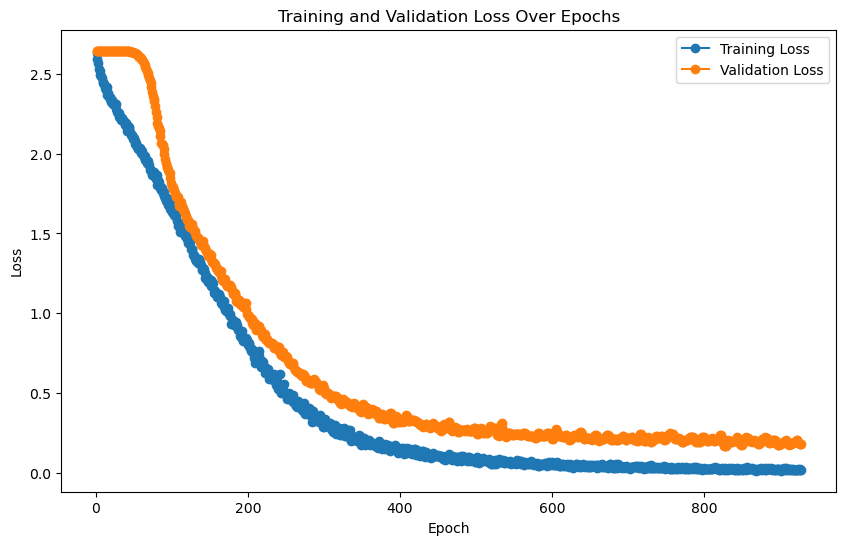

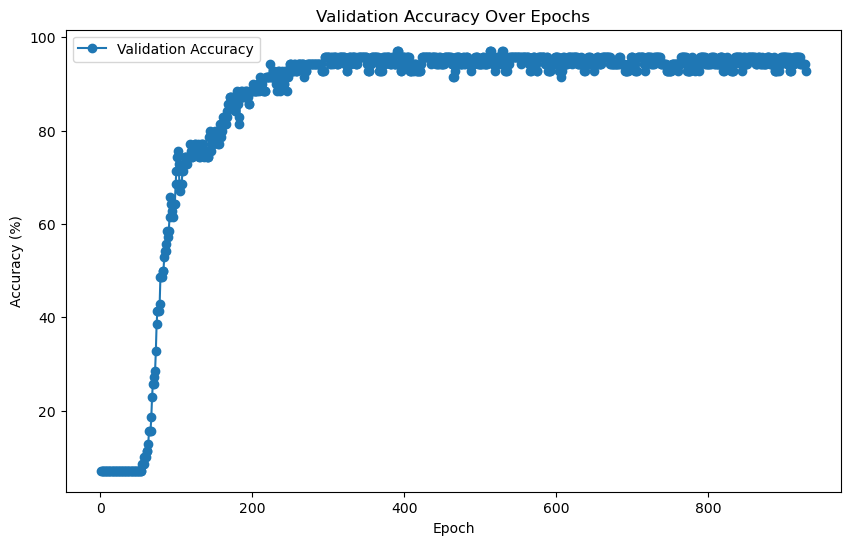


Evaluating on the test set...
    Test Batch [1/12], Loss: 0.0397

Final Test Loss: 0.1928, Test Accuracy: 95.16%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)

LOG: Training features shape: (140, 64), Training labels shape: (140,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (3038, 64), Test labels shape: (3038,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 71.43%

Validation Classification Report:
               precision    recall  f1

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)
Train reps shape: (140, 64)
Train labels shape: (140,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (3038, 64)
Test labels shape: (3038,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9315  |  Val Loss: 2.7504
Validation loss improved from inf to 2.7504.
[Epoch 2/1000] Train Loss: 2.7324  |  Val Loss: 2.6785
Validation loss improved from 2.7504 to 2.6785.
[Epoch 3/1000] Train Loss: 2.6665  |  Val Loss: 2.6440
Validation loss improved from 2.6785 to 2.6440.
[Epoch 4/1000] Train Loss: 2.6491  |  Val Loss: 2.6460
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 5/1000] Train Loss: 2.6466  |  Val Loss: 2.6402
Validation loss improved from 2.6440 to 2.6402.
[Epoch 6/1000] Train Loss: 2.6365  |  Val Loss: 2.6284
Validation loss improved from 2.6402 to 2.6284.
[Epoch 7/1000] Train Loss: 2.6301  |  Val Loss: 2.6217
Validation loss improved from 2.6284 to 2.6217.
[Epoch 8/1000] Train Loss: 2.6161  |  Val Loss: 2.6070
Validation loss improved from 2.6217 to 2.6070.
[Epoch 9/1000] Train Loss: 2.6000  |  Val Loss: 2.5975
Validation loss improved from 2.6070 to 2.5975.
[Epoch 10/1000] Train Loss: 2.5972  |  Val Loss: 2.6015
!! Validation 

[Epoch 20/1000] Train Loss: 2.5322  |  Val Loss: 2.5357
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 21/1000] Train Loss: 2.5214  |  Val Loss: 2.5181
Validation loss improved from 2.5342 to 2.5181.
[Epoch 22/1000] Train Loss: 2.5098  |  Val Loss: 2.5057
Validation loss improved from 2.5181 to 2.5057.
[Epoch 23/1000] Train Loss: 2.4934  |  Val Loss: 2.4908
Validation loss improved from 2.5057 to 2.4908.
[Epoch 24/1000] Train Loss: 2.4786  |  Val Loss: 2.4750
Validation loss improved from 2.4908 to 2.4750.
[Epoch 25/1000] Train Loss: 2.4573  |  Val Loss: 2.4560
Validation loss improved from 2.4750 to 2.4560.
[Epoch 26/1000] Train Loss: 2.4446  |  Val Loss: 2.4564
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 27/1000] Train Loss: 2.4454  |  Val Loss: 2.4397
Validation loss improved from 2.4560 to 2.4397.


[Epoch 28/1000] Train Loss: 2.4213  |  Val Loss: 2.4138
Validation loss improved from 2.4397 to 2.4138.
[Epoch 29/1000] Train Loss: 2.4021  |  Val Loss: 2.4022
Validation loss improved from 2.4138 to 2.4022.
[Epoch 30/1000] Train Loss: 2.3863  |  Val Loss: 2.3840
Validation loss improved from 2.4022 to 2.3840.
[Epoch 31/1000] Train Loss: 2.3664  |  Val Loss: 2.3678
Validation loss improved from 2.3840 to 2.3678.
[Epoch 32/1000] Train Loss: 2.3494  |  Val Loss: 2.3559
Validation loss improved from 2.3678 to 2.3559.
[Epoch 33/1000] Train Loss: 2.3332  |  Val Loss: 2.3324
Validation loss improved from 2.3559 to 2.3324.
[Epoch 34/1000] Train Loss: 2.3138  |  Val Loss: 2.3300
Validation loss improved from 2.3324 to 2.3300.
[Epoch 35/1000] Train Loss: 2.3051  |  Val Loss: 2.3070
Validation loss improved from 2.3300 to 2.3070.
[Epoch 36/1000] Train Loss: 2.2816  |  Val Loss: 2.2728
Validation loss improved from 2.3070 to 2.2728.
[Epoch 37/1000] Train Loss: 2.2566  |  Val Loss: 2.2700
Validati

[Epoch 47/1000] Train Loss: 2.0507  |  Val Loss: 2.0878
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 48/1000] Train Loss: 2.0407  |  Val Loss: 2.0401
Validation loss improved from 2.0731 to 2.0401.
[Epoch 49/1000] Train Loss: 2.0260  |  Val Loss: 2.0154
Validation loss improved from 2.0401 to 2.0154.
[Epoch 50/1000] Train Loss: 1.9861  |  Val Loss: 2.0158
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 51/1000] Train Loss: 1.9804  |  Val Loss: 1.9850
Validation loss improved from 2.0154 to 1.9850.
[Epoch 52/1000] Train Loss: 1.9567  |  Val Loss: 1.9586
Validation loss improved from 1.9850 to 1.9586.
[Epoch 53/1000] Train Loss: 1.9477  |  Val Loss: 1.9688
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 54/1000] Train Loss: 1.9226  |  Val Loss: 1.9305
Validation loss improved from 1.9586 to 1.9305.
[Epoch 55/1000] Train Loss: 1.9071  |  Val Loss: 1.9134
Validation loss improved from 1.9305 to 1.9134.
[Epoch 56/1000] Train Loss: 1.8779  |  Val Los

[Epoch 57/1000] Train Loss: 1.8541  |  Val Loss: 1.8638
Validation loss improved from 1.8949 to 1.8638.
[Epoch 58/1000] Train Loss: 1.8456  |  Val Loss: 1.8737
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 59/1000] Train Loss: 1.8425  |  Val Loss: 1.8592
Validation loss improved from 1.8638 to 1.8592.
[Epoch 60/1000] Train Loss: 1.8197  |  Val Loss: 1.8312
Validation loss improved from 1.8592 to 1.8312.
[Epoch 61/1000] Train Loss: 1.8013  |  Val Loss: 1.8319
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 62/1000] Train Loss: 1.7927  |  Val Loss: 1.8072
Validation loss improved from 1.8312 to 1.8072.
[Epoch 63/1000] Train Loss: 1.7660  |  Val Loss: 1.8342
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 64/1000] Train Loss: 1.7739  |  Val Loss: 1.8064
Validation loss improved from 1.8072 to 1.8064.
[Epoch 65/1000] Train Loss: 1.7843  |  Val Loss: 1.7884
Validation loss improved from 1.8064 to 1.7884.
[Epoch 66/1000] Train Loss: 1.7519  |  Val Los

[Epoch 77/1000] Train Loss: 1.6447  |  Val Loss: 1.6501
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 78/1000] Train Loss: 1.6120  |  Val Loss: 1.6243
Validation loss improved from 1.6367 to 1.6243.
[Epoch 79/1000] Train Loss: 1.5843  |  Val Loss: 1.6161
Validation loss improved from 1.6243 to 1.6161.
[Epoch 80/1000] Train Loss: 1.5929  |  Val Loss: 1.5993
Validation loss improved from 1.6161 to 1.5993.
[Epoch 81/1000] Train Loss: 1.5746  |  Val Loss: 1.6071
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 82/1000] Train Loss: 1.5647  |  Val Loss: 1.5863
Validation loss improved from 1.5993 to 1.5863.
[Epoch 83/1000] Train Loss: 1.5625  |  Val Loss: 1.6010
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 84/1000] Train Loss: 1.5479  |  Val Loss: 1.5836
Validation loss improved from 1.5863 to 1.5836.
[Epoch 85/1000] Train Loss: 1.5383  |  Val Loss: 1.5585
Validation loss improved from 1.5836 to 1.5585.
[Epoch 86/1000] Train Loss: 1.5341  |  Val Los

[Epoch 87/1000] Train Loss: 1.5181  |  Val Loss: 1.6077
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 88/1000] Train Loss: 1.5322  |  Val Loss: 1.5445
Validation loss improved from 1.5585 to 1.5445.
[Epoch 89/1000] Train Loss: 1.5257  |  Val Loss: 1.5332
Validation loss improved from 1.5445 to 1.5332.
[Epoch 90/1000] Train Loss: 1.5129  |  Val Loss: 1.5214
Validation loss improved from 1.5332 to 1.5214.
[Epoch 91/1000] Train Loss: 1.4964  |  Val Loss: 1.5456
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 92/1000] Train Loss: 1.4936  |  Val Loss: 1.5074
Validation loss improved from 1.5214 to 1.5074.
[Epoch 93/1000] Train Loss: 1.4795  |  Val Loss: 1.5321
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 94/1000] Train Loss: 1.4733  |  Val Loss: 1.5608
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 95/1000] Train Loss: 1.5018  |  Val Loss: 1.5339
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 96/1000] Train Loss: 1.4708

[Epoch 104/1000] Train Loss: 1.4273  |  Val Loss: 1.4580
Validation loss improved from 1.4584 to 1.4580.
[Epoch 105/1000] Train Loss: 1.4325  |  Val Loss: 1.5172
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 106/1000] Train Loss: 1.4575  |  Val Loss: 1.4567
Validation loss improved from 1.4580 to 1.4567.
[Epoch 107/1000] Train Loss: 1.4712  |  Val Loss: 1.4197
Validation loss improved from 1.4567 to 1.4197.
[Epoch 108/1000] Train Loss: 1.4066  |  Val Loss: 1.4471
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 109/1000] Train Loss: 1.3990  |  Val Loss: 1.4390
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 110/1000] Train Loss: 1.4367  |  Val Loss: 1.4705
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 111/1000] Train Loss: 1.4059  |  Val Loss: 1.4467
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 112/1000] Train Loss: 1.3872  |  Val Loss: 1.4524
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 113/1000] Tr

[Epoch 115/1000] Train Loss: 1.3965  |  Val Loss: 1.4692
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 116/1000] Train Loss: 1.3923  |  Val Loss: 1.4168
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 117/1000] Train Loss: 1.4105  |  Val Loss: 1.4427
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 118/1000] Train Loss: 1.3864  |  Val Loss: 1.4184
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 119/1000] Train Loss: 1.3726  |  Val Loss: 1.4246
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 120/1000] Train Loss: 1.3641  |  Val Loss: 1.4336
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 121/1000] Train Loss: 1.3956  |  Val Loss: 1.4449
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 122/1000] Train Loss: 1.4453  |  Val Loss: 1.4513
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 123/1000] Train Loss: 1.4000  |  Val Loss: 1.4607
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 134/1000] Train Loss: 1.3546  |  Val Loss: 1.3333
Validation loss improved from 1.3537 to 1.3333.
[Epoch 135/1000] Train Loss: 1.3421  |  Val Loss: 1.4788
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 136/1000] Train Loss: 1.3559  |  Val Loss: 1.3442
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 137/1000] Train Loss: 1.3470  |  Val Loss: 1.3887
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 138/1000] Train Loss: 1.3468  |  Val Loss: 1.4044
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 139/1000] Train Loss: 1.3401  |  Val Loss: 1.4074
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 140/1000] Train Loss: 1.3456  |  Val Loss: 1.4815
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 141/1000] Train Loss: 1.3389  |  Val Loss: 1.3794
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 142/1000] Train Loss: 1.3524  |  Val Loss: 1.4352
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 145/1000] Train Loss: 1.3813  |  Val Loss: 1.4601
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 146/1000] Train Loss: 1.3987  |  Val Loss: 1.3743
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 147/1000] Train Loss: 1.3499  |  Val Loss: 1.3442
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 148/1000] Train Loss: 1.3270  |  Val Loss: 1.5022
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 149/1000] Train Loss: 1.3480  |  Val Loss: 1.3591
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 150/1000] Train Loss: 1.3514  |  Val Loss: 1.3559
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 151/1000] Train Loss: 1.3102  |  Val Loss: 1.4165
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 152/1000] Train Loss: 1.3092  |  Val Loss: 1.3386
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 153/1000] Train Loss: 1.3355  |  Val Loss: 1.3821
!! Validation loss did NOT improve !! Patience:

[Epoch 163/1000] Train Loss: 1.2844  |  Val Loss: 1.3425
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 164/1000] Train Loss: 1.2975  |  Val Loss: 1.3404
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 165/1000] Train Loss: 1.2850  |  Val Loss: 1.3130
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 166/1000] Train Loss: 1.2722  |  Val Loss: 1.3209
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 167/1000] Train Loss: 1.2816  |  Val Loss: 1.3036
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 168/1000] Train Loss: 1.2729  |  Val Loss: 1.2836
Validation loss improved from 1.2982 to 1.2836.
[Epoch 169/1000] Train Loss: 1.2684  |  Val Loss: 1.3202
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 170/1000] Train Loss: 1.2790  |  Val Loss: 1.3057
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 171/1000] Train Loss: 1.2887  |  Val Loss: 1.3282
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch

[Epoch 174/1000] Train Loss: 1.2546  |  Val Loss: 1.3337
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 175/1000] Train Loss: 1.2585  |  Val Loss: 1.2982
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 176/1000] Train Loss: 1.2560  |  Val Loss: 1.3207
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 177/1000] Train Loss: 1.2682  |  Val Loss: 1.3049
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 178/1000] Train Loss: 1.2632  |  Val Loss: 1.2874
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 179/1000] Train Loss: 1.2591  |  Val Loss: 1.4159
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 180/1000] Train Loss: 1.2869  |  Val Loss: 1.3025
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 181/1000] Train Loss: 1.2597  |  Val Loss: 1.3056
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 182/1000] Train Loss: 1.2895  |  Val Loss: 1.4257
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 194/1000] Train Loss: 1.2739  |  Val Loss: 1.3025
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 195/1000] Train Loss: 1.2774  |  Val Loss: 1.5240
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 196/1000] Train Loss: 1.3335  |  Val Loss: 1.2921
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 197/1000] Train Loss: 1.2537  |  Val Loss: 1.3452
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 198/1000] Train Loss: 1.2567  |  Val Loss: 1.2532
Validation loss improved from 1.2739 to 1.2532.
[Epoch 199/1000] Train Loss: 1.2671  |  Val Loss: 1.2669
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 200/1000] Train Loss: 1.2603  |  Val Loss: 1.2966
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 201/1000] Train Loss: 1.2228  |  Val Loss: 1.2754
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 202/1000] Train Loss: 1.3011  |  Val Loss: 1.3900
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 205/1000] Train Loss: 1.2692  |  Val Loss: 1.4063
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 206/1000] Train Loss: 1.2470  |  Val Loss: 1.2771
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 207/1000] Train Loss: 1.3041  |  Val Loss: 1.2893
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 208/1000] Train Loss: 1.2565  |  Val Loss: 1.2969
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 209/1000] Train Loss: 1.2333  |  Val Loss: 1.2434
Validation loss improved from 1.2532 to 1.2434.
[Epoch 210/1000] Train Loss: 1.2372  |  Val Loss: 1.4123
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 211/1000] Train Loss: 1.2904  |  Val Loss: 1.2562
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 212/1000] Train Loss: 1.2731  |  Val Loss: 1.2590
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 213/1000] Train Loss: 1.2510  |  Val Loss: 1.3807
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch

[Epoch 225/1000] Train Loss: 1.2405  |  Val Loss: 1.2899
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 226/1000] Train Loss: 1.2194  |  Val Loss: 1.2375
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 227/1000] Train Loss: 1.2284  |  Val Loss: 1.2804
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 228/1000] Train Loss: 1.2412  |  Val Loss: 1.3064
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 229/1000] Train Loss: 1.2208  |  Val Loss: 1.2489
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 230/1000] Train Loss: 1.2216  |  Val Loss: 1.4797
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 231/1000] Train Loss: 1.3124  |  Val Loss: 1.2493
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 232/1000] Train Loss: 1.2787  |  Val Loss: 1.2486
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 233/1000] Train Loss: 1.2172  |  Val Loss: 1.4613
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 234/1000] Train Loss: 1.2660  |  Val Loss: 1.2451
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 235/1000] Train Loss: 1.2964  |  Val Loss: 1.2470
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 236/1000] Train Loss: 1.2376  |  Val Loss: 1.3876
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 237/1000] Train Loss: 1.2331  |  Val Loss: 1.2686
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 238/1000] Train Loss: 1.2488  |  Val Loss: 1.2722
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 239/1000] Train Loss: 1.2318  |  Val Loss: 1.2513
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 240/1000] Train Loss: 1.2185  |  Val Loss: 1.2351
Validation loss improved from 1.2374 to 1.2351.
[Epoch 241/1000] Train Loss: 1.2196  |  Val Loss: 1.2525
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 242/1000] Train Loss: 1.2038  |  Val Loss: 1.2963
!! Validation loss did NOT improve !! Patience: 2/100
[

[Epoch 256/1000] Train Loss: 1.2476  |  Val Loss: 1.2251
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 257/1000] Train Loss: 1.2014  |  Val Loss: 1.3949
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 258/1000] Train Loss: 1.2228  |  Val Loss: 1.2006
Validation loss improved from 1.2221 to 1.2006.
[Epoch 259/1000] Train Loss: 1.2339  |  Val Loss: 1.2552
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 260/1000] Train Loss: 1.2207  |  Val Loss: 1.3651
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 261/1000] Train Loss: 1.1982  |  Val Loss: 1.2473
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 262/1000] Train Loss: 1.3318  |  Val Loss: 1.2715
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 263/1000] Train Loss: 1.2440  |  Val Loss: 1.4758
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 264/1000] Train Loss: 1.2340  |  Val Loss: 1.2595
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 265/1000] Train Loss: 1.2873  |  Val Loss: 1.3133
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 266/1000] Train Loss: 1.2131  |  Val Loss: 1.4008
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 267/1000] Train Loss: 1.2160  |  Val Loss: 1.2105
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 268/1000] Train Loss: 1.1971  |  Val Loss: 1.2744
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 269/1000] Train Loss: 1.1950  |  Val Loss: 1.2545
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 270/1000] Train Loss: 1.2050  |  Val Loss: 1.2252
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 271/1000] Train Loss: 1.1982  |  Val Loss: 1.3894
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 272/1000] Train Loss: 1.2276  |  Val Loss: 1.2589
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 286/1000] Train Loss: 1.1858  |  Val Loss: 1.2121
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 287/1000] Train Loss: 1.1788  |  Val Loss: 1.3515
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 288/1000] Train Loss: 1.2218  |  Val Loss: 1.2715
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 289/1000] Train Loss: 1.1621  |  Val Loss: 1.1994
Validation loss improved from 1.2006 to 1.1994.
[Epoch 290/1000] Train Loss: 1.2333  |  Val Loss: 1.2509
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 291/1000] Train Loss: 1.2086  |  Val Loss: 1.4123
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 292/1000] Train Loss: 1.2070  |  Val Loss: 1.2084
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 293/1000] Train Loss: 1.2458  |  Val Loss: 1.2109
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 294/1000] Train Loss: 1.1631  |  Val Loss: 1.2659
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 295/1000] Train Loss: 1.1698  |  Val Loss: 1.2106
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 296/1000] Train Loss: 1.1961  |  Val Loss: 1.3062
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 297/1000] Train Loss: 1.2084  |  Val Loss: 1.2929
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 298/1000] Train Loss: 1.1694  |  Val Loss: 1.1958
Validation loss improved from 1.1994 to 1.1958.
[Epoch 299/1000] Train Loss: 1.2002  |  Val Loss: 1.2978
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 300/1000] Train Loss: 1.2194  |  Val Loss: 1.3355
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 301/1000] Train Loss: 1.1942  |  Val Loss: 1.2044
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 302/1000] Train Loss: 1.1965  |  Val Loss: 1.3126
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 303/1000] Train Loss: 1.1963  |  Val Loss: 1.1824
Validation loss improved from 1.1958 to 1.1824.
[Epoch 304/10

[Epoch 315/1000] Train Loss: 1.1607  |  Val Loss: 1.2340
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 316/1000] Train Loss: 1.1566  |  Val Loss: 1.2294
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 317/1000] Train Loss: 1.1594  |  Val Loss: 1.3174
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 318/1000] Train Loss: 1.1682  |  Val Loss: 1.1704
Validation loss improved from 1.1780 to 1.1704.
[Epoch 319/1000] Train Loss: 1.1934  |  Val Loss: 1.1878
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 320/1000] Train Loss: 1.1623  |  Val Loss: 1.3002
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 321/1000] Train Loss: 1.1750  |  Val Loss: 1.1767
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 322/1000] Train Loss: 1.1652  |  Val Loss: 1.2169
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 323/1000] Train Loss: 1.1583  |  Val Loss: 1.2740
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 324/1000] Train Loss: 1.1643  |  Val Loss: 1.2666
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 325/1000] Train Loss: 1.1708  |  Val Loss: 1.3039
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 326/1000] Train Loss: 1.1566  |  Val Loss: 1.1971
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 327/1000] Train Loss: 1.1390  |  Val Loss: 1.2194
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 328/1000] Train Loss: 1.1581  |  Val Loss: 1.2619
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 329/1000] Train Loss: 1.1707  |  Val Loss: 1.2411
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 330/1000] Train Loss: 1.1849  |  Val Loss: 1.2895
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 331/1000] Train Loss: 1.1670  |  Val Loss: 1.2236
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 344/1000] Train Loss: 1.1982  |  Val Loss: 1.5408
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 345/1000] Train Loss: 1.2763  |  Val Loss: 1.1792
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 346/1000] Train Loss: 1.2302  |  Val Loss: 1.1643
Validation loss improved from 1.1704 to 1.1643.
[Epoch 347/1000] Train Loss: 1.1556  |  Val Loss: 1.4875
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 348/1000] Train Loss: 1.2300  |  Val Loss: 1.2143
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 349/1000] Train Loss: 1.1728  |  Val Loss: 1.2012
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 350/1000] Train Loss: 1.1695  |  Val Loss: 1.3082
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 351/1000] Train Loss: 1.1492  |  Val Loss: 1.2523
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 352/1000] Train Loss: 1.1403  |  Val Loss: 1.2053
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 353/1000] Train Loss: 1.1561  |  Val Loss: 1.2780
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 354/1000] Train Loss: 1.1527  |  Val Loss: 1.3419
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 355/1000] Train Loss: 1.1328  |  Val Loss: 1.1892
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 356/1000] Train Loss: 1.2116  |  Val Loss: 1.2072
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 357/1000] Train Loss: 1.1729  |  Val Loss: 1.4257
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 358/1000] Train Loss: 1.1931  |  Val Loss: 1.1683
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 359/1000] Train Loss: 1.1861  |  Val Loss: 1.1860
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 360/1000] Train Loss: 1.1944  |  Val Loss: 1.3746
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 361/1000] Train Loss: 1.1744  |  Val Loss: 1.2155
!! Validation loss did NOT improve !! Patience: 15

[Epoch 373/1000] Train Loss: 1.1578  |  Val Loss: 1.2532
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 374/1000] Train Loss: 1.1713  |  Val Loss: 1.3361
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 375/1000] Train Loss: 1.1488  |  Val Loss: 1.1893
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 376/1000] Train Loss: 1.1587  |  Val Loss: 1.2001
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 377/1000] Train Loss: 1.1191  |  Val Loss: 1.2824
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 378/1000] Train Loss: 1.1305  |  Val Loss: 1.2112
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 379/1000] Train Loss: 1.1476  |  Val Loss: 1.2012
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 380/1000] Train Loss: 1.1311  |  Val Loss: 1.2341
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 381/1000] Train Loss: 1.1282  |  Val Loss: 1.1662
!! Validation loss did NOT improve !! Patience:

[Epoch 384/1000] Train Loss: 1.1301  |  Val Loss: 1.1936
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 385/1000] Train Loss: 1.1527  |  Val Loss: 1.2314
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 386/1000] Train Loss: 1.1261  |  Val Loss: 1.2572
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 387/1000] Train Loss: 1.1238  |  Val Loss: 1.1691
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 388/1000] Train Loss: 1.1235  |  Val Loss: 1.1484
Validation loss improved from 1.1643 to 1.1484.
[Epoch 389/1000] Train Loss: 1.1083  |  Val Loss: 1.1625
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 390/1000] Train Loss: 1.1123  |  Val Loss: 1.2044
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 391/1000] Train Loss: 1.1222  |  Val Loss: 1.2414
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 392/1000] Train Loss: 1.1255  |  Val Loss: 1.1530
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 404/1000] Train Loss: 1.1236  |  Val Loss: 1.2404
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 405/1000] Train Loss: 1.1143  |  Val Loss: 1.2079
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 406/1000] Train Loss: 1.1023  |  Val Loss: 1.1808
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 407/1000] Train Loss: 1.1169  |  Val Loss: 1.2006
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 408/1000] Train Loss: 1.1099  |  Val Loss: 1.1864
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 409/1000] Train Loss: 1.0993  |  Val Loss: 1.1581
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 410/1000] Train Loss: 1.0899  |  Val Loss: 1.1562
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 411/1000] Train Loss: 1.0960  |  Val Loss: 1.1448
Validation loss improved from 1.1484 to 1.1448.
[Epoch 412/1000] Train Loss: 1.0939  |  Val Loss: 1.1676
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 413/1000] Train Loss: 1.1020  |  Val Loss: 1.1681
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 414/1000] Train Loss: 1.1023  |  Val Loss: 1.1766
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 415/1000] Train Loss: 1.0824  |  Val Loss: 1.1834
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 416/1000] Train Loss: 1.1029  |  Val Loss: 1.1711
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 417/1000] Train Loss: 1.1176  |  Val Loss: 1.2194
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 418/1000] Train Loss: 1.1093  |  Val Loss: 1.1557
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 419/1000] Train Loss: 1.0915  |  Val Loss: 1.1519
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 420/1000] Train Loss: 1.0926  |  Val Loss: 1.3229
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 421/1000] Train Loss: 1.1604  |  Val Loss: 1.2166
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 433/1000] Train Loss: 1.1364  |  Val Loss: 1.1422
Validation loss improved from 1.1448 to 1.1422.
[Epoch 434/1000] Train Loss: 1.1619  |  Val Loss: 1.1441
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 435/1000] Train Loss: 1.1115  |  Val Loss: 1.2848
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 436/1000] Train Loss: 1.1222  |  Val Loss: 1.1471
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 437/1000] Train Loss: 1.0951  |  Val Loss: 1.1368
Validation loss improved from 1.1422 to 1.1368.
[Epoch 438/1000] Train Loss: 1.0855  |  Val Loss: 1.2272
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 439/1000] Train Loss: 1.1007  |  Val Loss: 1.1396
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 440/1000] Train Loss: 1.1001  |  Val Loss: 1.1289
Validation loss improved from 1.1368 to 1.1289.
[Epoch 441/1000] Train Loss: 1.0981  |  Val Loss: 1.2303
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 442/1000] Tr

[Epoch 443/1000] Train Loss: 1.1012  |  Val Loss: 1.1676
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 444/1000] Train Loss: 1.0909  |  Val Loss: 1.2602
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 445/1000] Train Loss: 1.1042  |  Val Loss: 1.1542
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 446/1000] Train Loss: 1.1116  |  Val Loss: 1.1681
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 447/1000] Train Loss: 1.1008  |  Val Loss: 1.1466
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 448/1000] Train Loss: 1.1247  |  Val Loss: 1.1207
Validation loss improved from 1.1289 to 1.1207.
[Epoch 449/1000] Train Loss: 1.1074  |  Val Loss: 1.2325
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 450/1000] Train Loss: 1.0972  |  Val Loss: 1.1556
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 451/1000] Train Loss: 1.1714  |  Val Loss: 1.3165
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 

[Epoch 464/1000] Train Loss: 1.0829  |  Val Loss: 1.1545
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 465/1000] Train Loss: 1.0666  |  Val Loss: 1.1316
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 466/1000] Train Loss: 1.0848  |  Val Loss: 1.2233
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 467/1000] Train Loss: 1.0956  |  Val Loss: 1.1519
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 468/1000] Train Loss: 1.0654  |  Val Loss: 1.1275
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 469/1000] Train Loss: 1.0830  |  Val Loss: 1.2160
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 470/1000] Train Loss: 1.0827  |  Val Loss: 1.2006
!! Validation loss did NOT improve !! Patience: 14/100


[Epoch 471/1000] Train Loss: 1.0790  |  Val Loss: 1.1252
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 472/1000] Train Loss: 1.0584  |  Val Loss: 1.1877
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 473/1000] Train Loss: 1.0723  |  Val Loss: 1.2095
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 474/1000] Train Loss: 1.0762  |  Val Loss: 1.1327
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 475/1000] Train Loss: 1.0750  |  Val Loss: 1.1171
Validation loss improved from 1.1200 to 1.1171.
[Epoch 476/1000] Train Loss: 1.0784  |  Val Loss: 1.1129
Validation loss improved from 1.1171 to 1.1129.
[Epoch 477/1000] Train Loss: 1.0659  |  Val Loss: 1.1292
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 478/1000] Train Loss: 1.0586  |  Val Loss: 1.1624
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 479/1000] Train Loss: 1.0646  |  Val Loss: 1.1387
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 48

[Epoch 492/1000] Train Loss: 1.0777  |  Val Loss: 1.1396
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 493/1000] Train Loss: 1.0729  |  Val Loss: 1.1127
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 494/1000] Train Loss: 1.0511  |  Val Loss: 1.1525
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 495/1000] Train Loss: 1.0492  |  Val Loss: 1.1503
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 496/1000] Train Loss: 1.0634  |  Val Loss: 1.1989
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 497/1000] Train Loss: 1.0513  |  Val Loss: 1.1408
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 498/1000] Train Loss: 1.0631  |  Val Loss: 1.1554
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 499/1000] Train Loss: 1.0511  |  Val Loss: 1.1446
!! Validation loss did NOT improve !! Patience: 11/100


[Epoch 500/1000] Train Loss: 1.0655  |  Val Loss: 1.2255
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 501/1000] Train Loss: 1.0778  |  Val Loss: 1.1413
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 502/1000] Train Loss: 1.0472  |  Val Loss: 1.1685
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 503/1000] Train Loss: 1.1013  |  Val Loss: 1.1963
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 504/1000] Train Loss: 1.0707  |  Val Loss: 1.1834
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 505/1000] Train Loss: 1.1020  |  Val Loss: 1.1516
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 506/1000] Train Loss: 1.0570  |  Val Loss: 1.1561
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 507/1000] Train Loss: 1.0831  |  Val Loss: 1.1221
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 508/1000] Train Loss: 1.1567  |  Val Loss: 1.1485
!! Validation loss did NOT improve !! Patience:

[Epoch 518/1000] Train Loss: 1.0868  |  Val Loss: 1.1812
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 519/1000] Train Loss: 1.0498  |  Val Loss: 1.1128
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 520/1000] Train Loss: 1.0348  |  Val Loss: 1.1739
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 521/1000] Train Loss: 1.0613  |  Val Loss: 1.1644
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 522/1000] Train Loss: 1.0483  |  Val Loss: 1.1485
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 523/1000] Train Loss: 1.0459  |  Val Loss: 1.1561
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 524/1000] Train Loss: 1.0328  |  Val Loss: 1.1378
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 525/1000] Train Loss: 1.0377  |  Val Loss: 1.1580
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 526/1000] Train Loss: 1.0537  |  Val Loss: 1.1449
!! Validation loss did NOT improve !! Patience:

[Epoch 530/1000] Train Loss: 1.0693  |  Val Loss: 1.1239
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 531/1000] Train Loss: 1.0404  |  Val Loss: 1.3169
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 532/1000] Train Loss: 1.0731  |  Val Loss: 1.0927
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 533/1000] Train Loss: 1.1215  |  Val Loss: 1.1188
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 534/1000] Train Loss: 1.0569  |  Val Loss: 1.3925
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 535/1000] Train Loss: 1.1071  |  Val Loss: 1.0919
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 536/1000] Train Loss: 1.0524  |  Val Loss: 1.0871
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 537/1000] Train Loss: 1.0543  |  Val Loss: 1.2001
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 538/1000] Train Loss: 1.0577  |  Val Loss: 1.0901
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 550/1000] Train Loss: 1.0173  |  Val Loss: 1.1713
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 551/1000] Train Loss: 1.0294  |  Val Loss: 1.1043
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 552/1000] Train Loss: 1.0600  |  Val Loss: 1.0941
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 553/1000] Train Loss: 1.0438  |  Val Loss: 1.1465
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 554/1000] Train Loss: 1.0602  |  Val Loss: 1.0956
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 555/1000] Train Loss: 1.0203  |  Val Loss: 1.1623
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 556/1000] Train Loss: 1.0565  |  Val Loss: 1.0856
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 557/1000] Train Loss: 1.0352  |  Val Loss: 1.1078
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 558/1000] Train Loss: 1.0300  |  Val Loss: 1.2240
!! Validation loss did NOT improve !! Patience:

[Epoch 560/1000] Train Loss: 1.0109  |  Val Loss: 1.1070
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 561/1000] Train Loss: 1.0172  |  Val Loss: 1.1384
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 562/1000] Train Loss: 1.0235  |  Val Loss: 1.0851
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 563/1000] Train Loss: 1.0313  |  Val Loss: 1.1988
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 564/1000] Train Loss: 1.0499  |  Val Loss: 1.1941
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 565/1000] Train Loss: 1.0420  |  Val Loss: 1.0933
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 566/1000] Train Loss: 1.0341  |  Val Loss: 1.1055
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 567/1000] Train Loss: 1.0160  |  Val Loss: 1.1137
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 568/1000] Train Loss: 1.0052  |  Val Loss: 1.1304
!! Validation loss did NOT improve !! Patience:

[Epoch 579/1000] Train Loss: 0.9959  |  Val Loss: 1.0746
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 580/1000] Train Loss: 1.0187  |  Val Loss: 1.0685
Validation loss improved from 1.0706 to 1.0685.
[Epoch 581/1000] Train Loss: 0.9983  |  Val Loss: 1.0802
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 582/1000] Train Loss: 0.9930  |  Val Loss: 1.0857
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 583/1000] Train Loss: 1.0006  |  Val Loss: 1.1247
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 584/1000] Train Loss: 1.0181  |  Val Loss: 1.1337
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 585/1000] Train Loss: 0.9936  |  Val Loss: 1.0784
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 586/1000] Train Loss: 1.0102  |  Val Loss: 1.1873
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 587/1000] Train Loss: 1.0433  |  Val Loss: 1.1605
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch

[Epoch 590/1000] Train Loss: 1.0111  |  Val Loss: 1.0894
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 591/1000] Train Loss: 1.0312  |  Val Loss: 1.1928
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 592/1000] Train Loss: 1.0482  |  Val Loss: 1.1357
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 593/1000] Train Loss: 1.0170  |  Val Loss: 1.1070
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 594/1000] Train Loss: 1.0003  |  Val Loss: 1.2589
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 595/1000] Train Loss: 1.0189  |  Val Loss: 1.0799
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 596/1000] Train Loss: 1.1073  |  Val Loss: 1.1037
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 597/1000] Train Loss: 1.0088  |  Val Loss: 1.2378
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 598/1000] Train Loss: 1.0307  |  Val Loss: 1.0645
Validation loss improved from 1.0685 to 1.0645.

[Epoch 606/1000] Train Loss: 1.0412  |  Val Loss: 1.0555
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 607/1000] Train Loss: 0.9964  |  Val Loss: 1.1245
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 608/1000] Train Loss: 0.9996  |  Val Loss: 1.1109
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 609/1000] Train Loss: 0.9981  |  Val Loss: 1.0914
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 610/1000] Train Loss: 0.9826  |  Val Loss: 1.0648
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 611/1000] Train Loss: 0.9749  |  Val Loss: 1.0869
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 612/1000] Train Loss: 0.9902  |  Val Loss: 1.1077
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 613/1000] Train Loss: 0.9938  |  Val Loss: 1.2880
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 614/1000] Train Loss: 1.0651  |  Val Loss: 1.0975
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 621/1000] Train Loss: 0.9813  |  Val Loss: 1.1732
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 622/1000] Train Loss: 0.9854  |  Val Loss: 1.0971
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 623/1000] Train Loss: 0.9700  |  Val Loss: 1.1407
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 624/1000] Train Loss: 1.0017  |  Val Loss: 1.1138
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 625/1000] Train Loss: 0.9633  |  Val Loss: 1.0431
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 626/1000] Train Loss: 0.9902  |  Val Loss: 1.1179
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 627/1000] Train Loss: 0.9773  |  Val Loss: 1.0788
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 628/1000] Train Loss: 0.9876  |  Val Loss: 1.1227
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 629/1000] Train Loss: 0.9975  |  Val Loss: 1.1720
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 636/1000] Train Loss: 0.9724  |  Val Loss: 1.1236
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 637/1000] Train Loss: 0.9927  |  Val Loss: 1.0166
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 638/1000] Train Loss: 1.0536  |  Val Loss: 1.0211
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 639/1000] Train Loss: 1.0150  |  Val Loss: 1.1985
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 640/1000] Train Loss: 0.9863  |  Val Loss: 1.0397
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 641/1000] Train Loss: 1.0592  |  Val Loss: 1.1440
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 642/1000] Train Loss: 1.0022  |  Val Loss: 1.1945
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 643/1000] Train Loss: 0.9807  |  Val Loss: 1.0470
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 644/1000] Train Loss: 0.9967  |  Val Loss: 1.1387
!! Validation loss did NOT improve !! Patience:

[Epoch 652/1000] Train Loss: 0.9434  |  Val Loss: 1.0297
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 653/1000] Train Loss: 1.0243  |  Val Loss: 1.0950
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 654/1000] Train Loss: 0.9773  |  Val Loss: 1.2240
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 655/1000] Train Loss: 1.0132  |  Val Loss: 1.0692
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 656/1000] Train Loss: 0.9576  |  Val Loss: 1.0582
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 657/1000] Train Loss: 0.9676  |  Val Loss: 1.0575
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 658/1000] Train Loss: 0.9449  |  Val Loss: 1.1309
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 659/1000] Train Loss: 0.9754  |  Val Loss: 1.0564
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 660/1000] Train Loss: 0.9733  |  Val Loss: 1.1043
!! Validation loss did NOT improve !! Patience:

[Epoch 666/1000] Train Loss: 0.9550  |  Val Loss: 1.1679
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 667/1000] Train Loss: 0.9672  |  Val Loss: 1.0757
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 668/1000] Train Loss: 0.9347  |  Val Loss: 1.0161
Validation loss improved from 1.0164 to 1.0161.
[Epoch 669/1000] Train Loss: 0.9636  |  Val Loss: 1.0788
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 670/1000] Train Loss: 0.9616  |  Val Loss: 1.0970
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 671/1000] Train Loss: 0.9387  |  Val Loss: 1.0203
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 672/1000] Train Loss: 0.9444  |  Val Loss: 1.0942
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 673/1000] Train Loss: 0.9978  |  Val Loss: 1.0469
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 674/1000] Train Loss: 0.9466  |  Val Loss: 1.0358
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 684/1000] Train Loss: 0.9722  |  Val Loss: 1.0288
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 685/1000] Train Loss: 0.9573  |  Val Loss: 1.0240
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 686/1000] Train Loss: 0.9711  |  Val Loss: 1.0936
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 687/1000] Train Loss: 0.9812  |  Val Loss: 1.0213
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 688/1000] Train Loss: 0.9788  |  Val Loss: 1.1238
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 689/1000] Train Loss: 0.9982  |  Val Loss: 1.0774
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 690/1000] Train Loss: 0.9407  |  Val Loss: 1.0123
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 691/1000] Train Loss: 0.9507  |  Val Loss: 1.1568
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 692/1000] Train Loss: 0.9538  |  Val Loss: 1.0578
!! Validation loss did NOT improve !! Patience: 15

[Epoch 698/1000] Train Loss: 0.9229  |  Val Loss: 1.1054
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 699/1000] Train Loss: 0.9289  |  Val Loss: 1.0215
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 700/1000] Train Loss: 0.9132  |  Val Loss: 1.0275
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 701/1000] Train Loss: 0.9425  |  Val Loss: 1.0561
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 702/1000] Train Loss: 0.9146  |  Val Loss: 1.0382
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 703/1000] Train Loss: 0.9468  |  Val Loss: 1.0336
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 704/1000] Train Loss: 0.9365  |  Val Loss: 1.1201
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 705/1000] Train Loss: 0.9289  |  Val Loss: 0.9962
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 706/1000] Train Loss: 0.9479  |  Val Loss: 1.0217
!! Validation loss did NOT improve !! Patience:

[Epoch 715/1000] Train Loss: 0.9067  |  Val Loss: 1.2348
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 716/1000] Train Loss: 0.9628  |  Val Loss: 1.0494
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 717/1000] Train Loss: 1.0438  |  Val Loss: 1.0107
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 718/1000] Train Loss: 0.9495  |  Val Loss: 1.1638
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 719/1000] Train Loss: 0.9259  |  Val Loss: 1.0266
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 720/1000] Train Loss: 0.9085  |  Val Loss: 1.0401
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 721/1000] Train Loss: 0.9132  |  Val Loss: 1.1282
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 722/1000] Train Loss: 0.9485  |  Val Loss: 1.0350
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 723/1000] Train Loss: 0.9317  |  Val Loss: 0.9752
Validation loss improved from 0.9916 to 0.9752.

[Epoch 728/1000] Train Loss: 0.9947  |  Val Loss: 0.9859
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 729/1000] Train Loss: 0.9743  |  Val Loss: 1.0845
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 730/1000] Train Loss: 1.0051  |  Val Loss: 1.1923
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 731/1000] Train Loss: 0.9437  |  Val Loss: 1.0382
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 732/1000] Train Loss: 0.9503  |  Val Loss: 1.0554
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 733/1000] Train Loss: 0.9145  |  Val Loss: 1.0320
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 734/1000] Train Loss: 0.8842  |  Val Loss: 1.0340
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 735/1000] Train Loss: 0.9045  |  Val Loss: 1.1328
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 736/1000] Train Loss: 0.9217  |  Val Loss: 1.0252
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 746/1000] Train Loss: 0.9667  |  Val Loss: 1.1353
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 747/1000] Train Loss: 0.9113  |  Val Loss: 0.9883
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 748/1000] Train Loss: 0.9258  |  Val Loss: 1.1740
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 749/1000] Train Loss: 0.9529  |  Val Loss: 1.0871
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 750/1000] Train Loss: 0.9202  |  Val Loss: 1.0089
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 751/1000] Train Loss: 0.9075  |  Val Loss: 1.1473
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 752/1000] Train Loss: 0.9040  |  Val Loss: 0.9857
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 753/1000] Train Loss: 0.9012  |  Val Loss: 1.0852
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 754/1000] Train Loss: 0.9368  |  Val Loss: 1.1212
!! Validation loss did NOT improve !! Patience: 15

[Epoch 759/1000] Train Loss: 0.9114  |  Val Loss: 1.2186
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 760/1000] Train Loss: 0.9827  |  Val Loss: 1.0173
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 761/1000] Train Loss: 0.9210  |  Val Loss: 1.0251
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 762/1000] Train Loss: 0.9241  |  Val Loss: 1.2736
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 763/1000] Train Loss: 0.9651  |  Val Loss: 1.0104
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 764/1000] Train Loss: 0.9733  |  Val Loss: 1.0012
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 765/1000] Train Loss: 0.9385  |  Val Loss: 1.1053
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 766/1000] Train Loss: 0.9213  |  Val Loss: 1.0454
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 767/1000] Train Loss: 0.9099  |  Val Loss: 1.0044
!! Validation loss did NOT improve !! Patience:

[Epoch 777/1000] Train Loss: 0.9061  |  Val Loss: 0.9686
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 778/1000] Train Loss: 0.9009  |  Val Loss: 0.9662
Validation loss improved from 0.9674 to 0.9662.
[Epoch 779/1000] Train Loss: 0.9058  |  Val Loss: 1.0251
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 780/1000] Train Loss: 0.8887  |  Val Loss: 0.9475
Validation loss improved from 0.9662 to 0.9475.
[Epoch 781/1000] Train Loss: 0.8714  |  Val Loss: 1.1777
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 782/1000] Train Loss: 0.9180  |  Val Loss: 1.0245
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 783/1000] Train Loss: 0.8851  |  Val Loss: 1.0150
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 784/1000] Train Loss: 0.8803  |  Val Loss: 1.0895
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 785/1000] Train Loss: 0.8762  |  Val Loss: 0.9639
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 786/1

[Epoch 790/1000] Train Loss: 0.8754  |  Val Loss: 1.1112
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 791/1000] Train Loss: 0.9365  |  Val Loss: 1.0112
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 792/1000] Train Loss: 0.8711  |  Val Loss: 0.9505
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 793/1000] Train Loss: 0.9094  |  Val Loss: 1.2148
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 794/1000] Train Loss: 0.9159  |  Val Loss: 0.9884
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 795/1000] Train Loss: 0.8616  |  Val Loss: 0.9666
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 796/1000] Train Loss: 0.8658  |  Val Loss: 1.0629
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 797/1000] Train Loss: 0.8635  |  Val Loss: 0.9739
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 798/1000] Train Loss: 0.8616  |  Val Loss: 0.9744
!! Validation loss did NOT improve !! Patience:

[Epoch 807/1000] Train Loss: 0.8811  |  Val Loss: 0.9479
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 808/1000] Train Loss: 0.8557  |  Val Loss: 0.9771
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 809/1000] Train Loss: 0.8515  |  Val Loss: 0.9917
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 810/1000] Train Loss: 0.8344  |  Val Loss: 1.0430
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 811/1000] Train Loss: 0.8460  |  Val Loss: 0.9410
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 812/1000] Train Loss: 0.8835  |  Val Loss: 1.0844
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 813/1000] Train Loss: 0.8718  |  Val Loss: 1.0494
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 814/1000] Train Loss: 0.8924  |  Val Loss: 0.9999
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 815/1000] Train Loss: 0.8850  |  Val Loss: 1.3064
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 821/1000] Train Loss: 0.8494  |  Val Loss: 1.0979
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 822/1000] Train Loss: 0.8767  |  Val Loss: 1.0429
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 823/1000] Train Loss: 0.8330  |  Val Loss: 0.9414
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 824/1000] Train Loss: 0.8422  |  Val Loss: 1.0353
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 825/1000] Train Loss: 0.8362  |  Val Loss: 1.0884
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 826/1000] Train Loss: 0.8704  |  Val Loss: 0.9705
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 827/1000] Train Loss: 0.8447  |  Val Loss: 0.9774
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 828/1000] Train Loss: 0.8461  |  Val Loss: 1.1535
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 829/1000] Train Loss: 0.8624  |  Val Loss: 0.9285
!! Validation loss did NOT improve !! Patience:

[Epoch 838/1000] Train Loss: 0.8149  |  Val Loss: 1.0013
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 839/1000] Train Loss: 0.8045  |  Val Loss: 0.9922
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 840/1000] Train Loss: 0.8263  |  Val Loss: 1.0562
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 841/1000] Train Loss: 0.8388  |  Val Loss: 1.0072
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 842/1000] Train Loss: 0.8333  |  Val Loss: 0.9814
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 843/1000] Train Loss: 0.8256  |  Val Loss: 0.9624
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 844/1000] Train Loss: 0.8168  |  Val Loss: 1.0236
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 845/1000] Train Loss: 0.8076  |  Val Loss: 0.9566
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 846/1000] Train Loss: 0.8034  |  Val Loss: 0.9526
!! Validation loss did NOT improve !! Patience:

[Epoch 851/1000] Train Loss: 0.8427  |  Val Loss: 0.9927
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 852/1000] Train Loss: 0.8270  |  Val Loss: 1.0206
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 853/1000] Train Loss: 0.8116  |  Val Loss: 0.9607
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 854/1000] Train Loss: 0.8548  |  Val Loss: 1.0871
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 855/1000] Train Loss: 0.8821  |  Val Loss: 1.1240
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 856/1000] Train Loss: 0.8478  |  Val Loss: 0.9458
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 857/1000] Train Loss: 0.8154  |  Val Loss: 1.0313
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 858/1000] Train Loss: 0.8293  |  Val Loss: 1.0068
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 859/1000] Train Loss: 0.8385  |  Val Loss: 0.9021
Validation loss improved from 0.9155 to 0.9021.

[Epoch 867/1000] Train Loss: 0.7960  |  Val Loss: 0.9271
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 868/1000] Train Loss: 0.8058  |  Val Loss: 0.9795
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 869/1000] Train Loss: 0.8181  |  Val Loss: 0.9928
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 870/1000] Train Loss: 0.8103  |  Val Loss: 0.9468
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 871/1000] Train Loss: 0.8169  |  Val Loss: 1.0034
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 872/1000] Train Loss: 0.8054  |  Val Loss: 0.9324
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 873/1000] Train Loss: 0.8002  |  Val Loss: 1.0066
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 874/1000] Train Loss: 0.8298  |  Val Loss: 1.1032
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 875/1000] Train Loss: 0.8145  |  Val Loss: 0.9505
!! Validation loss did NOT improve !! Patience: 1

[Epoch 882/1000] Train Loss: 0.7803  |  Val Loss: 1.0596
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 883/1000] Train Loss: 0.8280  |  Val Loss: 0.9352
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 884/1000] Train Loss: 0.8008  |  Val Loss: 0.9008
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 885/1000] Train Loss: 0.7845  |  Val Loss: 1.1867
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 886/1000] Train Loss: 0.8960  |  Val Loss: 0.9554
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 887/1000] Train Loss: 0.8324  |  Val Loss: 0.9284
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 888/1000] Train Loss: 0.8135  |  Val Loss: 1.2049
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 889/1000] Train Loss: 0.8572  |  Val Loss: 0.9403
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 890/1000] Train Loss: 0.8109  |  Val Loss: 0.9918
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 897/1000] Train Loss: 0.9123  |  Val Loss: 1.2559
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 898/1000] Train Loss: 0.8650  |  Val Loss: 0.9341
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 899/1000] Train Loss: 0.9604  |  Val Loss: 0.9447
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 900/1000] Train Loss: 0.8078  |  Val Loss: 1.1601
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 901/1000] Train Loss: 0.8292  |  Val Loss: 0.9154
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 902/1000] Train Loss: 0.8628  |  Val Loss: 0.9612
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 903/1000] Train Loss: 0.7870  |  Val Loss: 1.0513
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 904/1000] Train Loss: 0.7917  |  Val Loss: 0.9254
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 905/1000] Train Loss: 0.7766  |  Val Loss: 1.0118
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 912/1000] Train Loss: 0.7916  |  Val Loss: 0.9119
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 913/1000] Train Loss: 0.7862  |  Val Loss: 0.9164
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 914/1000] Train Loss: 0.7684  |  Val Loss: 1.0361
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 915/1000] Train Loss: 0.7687  |  Val Loss: 0.9377
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 916/1000] Train Loss: 0.7580  |  Val Loss: 0.9777
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 917/1000] Train Loss: 0.7558  |  Val Loss: 0.9817
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 918/1000] Train Loss: 0.7518  |  Val Loss: 0.9441
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 919/1000] Train Loss: 0.7570  |  Val Loss: 0.8986
Validation loss improved from 0.8991 to 0.8986.
[Epoch 920/1000] Train Loss: 0.7408  |  Val Loss: 1.0087
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 928/1000] Train Loss: 0.7723  |  Val Loss: 0.9297
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 929/1000] Train Loss: 0.7457  |  Val Loss: 0.9893
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 930/1000] Train Loss: 0.7575  |  Val Loss: 0.8958
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 931/1000] Train Loss: 0.7822  |  Val Loss: 0.9162
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 932/1000] Train Loss: 0.7435  |  Val Loss: 0.9154
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 933/1000] Train Loss: 0.7199  |  Val Loss: 0.9373
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 934/1000] Train Loss: 0.7374  |  Val Loss: 0.9221
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 935/1000] Train Loss: 0.7170  |  Val Loss: 0.9111
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 936/1000] Train Loss: 0.7468  |  Val Loss: 0.9150
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 943/1000] Train Loss: 0.7402  |  Val Loss: 0.9193
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 944/1000] Train Loss: 0.7283  |  Val Loss: 0.9009
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 945/1000] Train Loss: 0.7531  |  Val Loss: 0.9682
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 946/1000] Train Loss: 0.7638  |  Val Loss: 0.9292
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 947/1000] Train Loss: 0.7420  |  Val Loss: 0.9401
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 948/1000] Train Loss: 0.7799  |  Val Loss: 1.0357
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 949/1000] Train Loss: 0.7632  |  Val Loss: 0.8717
Validation loss improved from 0.8953 to 0.8717.
[Epoch 950/1000] Train Loss: 0.7537  |  Val Loss: 0.9371
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 951/1000] Train Loss: 0.7488  |  Val Loss: 1.0153
!! Validation loss did NOT improve !! Patience: 2/100
[

[Epoch 961/1000] Train Loss: 0.7095  |  Val Loss: 0.9170
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 962/1000] Train Loss: 0.7310  |  Val Loss: 0.9805
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 963/1000] Train Loss: 0.7309  |  Val Loss: 0.9406
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 964/1000] Train Loss: 0.7074  |  Val Loss: 0.9546
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 965/1000] Train Loss: 0.7382  |  Val Loss: 0.9171
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 966/1000] Train Loss: 0.7055  |  Val Loss: 0.8851
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 967/1000] Train Loss: 0.7293  |  Val Loss: 0.9203
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 968/1000] Train Loss: 0.6998  |  Val Loss: 1.0181
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 969/1000] Train Loss: 0.7215  |  Val Loss: 0.8904
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 971/1000] Train Loss: 0.7037  |  Val Loss: 0.9485
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 972/1000] Train Loss: 0.7272  |  Val Loss: 0.8744
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 973/1000] Train Loss: 0.7376  |  Val Loss: 0.8943
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 974/1000] Train Loss: 0.6952  |  Val Loss: 0.9472
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 975/1000] Train Loss: 0.7370  |  Val Loss: 0.8948
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 976/1000] Train Loss: 0.7085  |  Val Loss: 0.8902
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 977/1000] Train Loss: 0.6879  |  Val Loss: 0.9332
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 978/1000] Train Loss: 0.7015  |  Val Loss: 0.8603
Validation loss improved from 0.8611 to 0.8603.
[Epoch 979/1000] Train Loss: 0.7035  |  Val Loss: 0.8529
Validation loss improved from 0.8603 to 0.8529.
[Epoch

[Epoch 993/1000] Train Loss: 0.6792  |  Val Loss: 0.8474
Validation loss improved from 0.8529 to 0.8474.
[Epoch 994/1000] Train Loss: 0.7433  |  Val Loss: 1.0313
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 995/1000] Train Loss: 0.7909  |  Val Loss: 0.9626
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 996/1000] Train Loss: 0.6943  |  Val Loss: 0.8161
Validation loss improved from 0.8474 to 0.8161.
[Epoch 997/1000] Train Loss: 0.7048  |  Val Loss: 0.9930
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 998/1000] Train Loss: 0.7098  |  Val Loss: 0.8584
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 999/1000] Train Loss: 0.6974  |  Val Loss: 0.8273
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 1000/1000] Train Loss: 0.6898  |  Val Loss: 0.9825
!! Validation loss did NOT improve !! Patience: 4/100


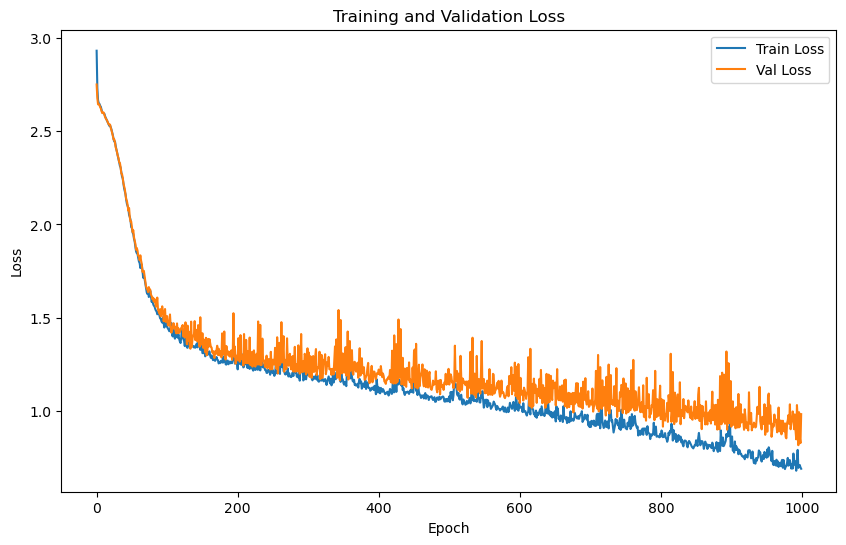

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.9890 | Test Accuracy: 63.82%


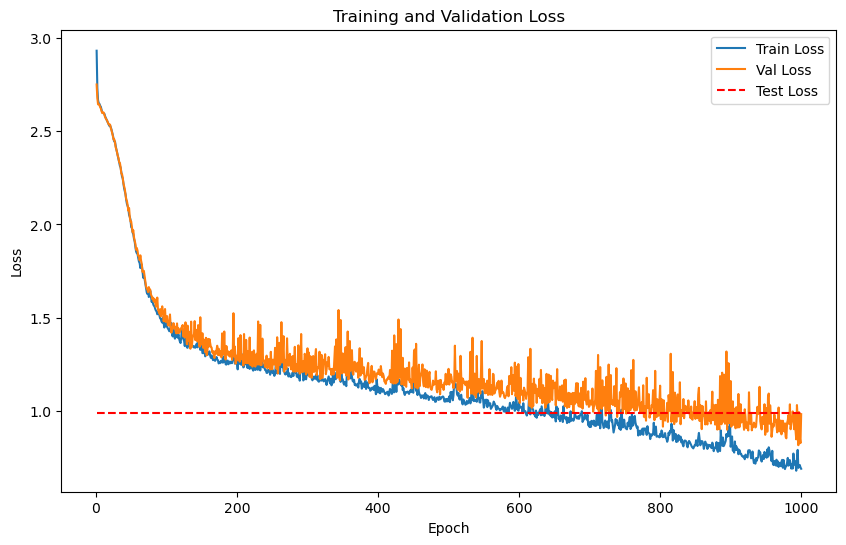

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)


Train embeddings shape: (140, 64), 
Train labels shape: (140,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3038, 64), 
Test labels shape: (3038,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10}
Training batch size: 140


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 8.3331
Epoch [1/2000], Avg Train Loss: 8.3331
Epoch [1/2000], Avg Val Loss: 3.5523
Validation loss improved from inf to 3.5523. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.1113
Epoch [2/2000], Avg Train Loss: 8.1113
Epoch [2/2000], Avg Val Loss: 3.5342
Validation loss improved from 3.5523 to 3.5342. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.9573
Epoch [3/2000], Avg Train Loss: 7.9573
Epoch [3/2000], Avg Val Loss: 3.5173
Validation loss improved from 3.5342 to 3.5173. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.9340
Epoch [4/2000], Avg Train Loss: 7.9340
Epoch [4/2000], Avg Val Loss: 3.5013
Validation loss improved from 3.5173 to 3.5013. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.8974
Epoch [5/2000], Avg Train Loss: 7.8974


Epoch [5/2000], Avg Val Loss: 3.4860
Validation loss improved from 3.5013 to 3.4860. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.8138
Epoch [6/2000], Avg Train Loss: 7.8138
Epoch [6/2000], Avg Val Loss: 3.4713
Validation loss improved from 3.4860 to 3.4713. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 7.7739
Epoch [7/2000], Avg Train Loss: 7.7739
Epoch [7/2000], Avg Val Loss: 3.4572
Validation loss improved from 3.4713 to 3.4572. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 7.6817
Epoch [8/2000], Avg Train Loss: 7.6817
Epoch [8/2000], Avg Val Loss: 3.4438
Validation loss improved from 3.4572 to 3.4438. Saving model...

LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 7.7169
Epoch [9/2000], Avg Train Loss: 7.7169
Epoch [9/2000], Avg Val Loss: 3.4310
Validation loss improved from 3.4438 to 3.4310. Saving model...

LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 7.442

    Batch [1/1], Train Loss: 6.4418
Epoch [21/2000], Avg Train Loss: 6.4418
Epoch [21/2000], Avg Val Loss: 3.3203
Validation loss improved from 3.3270 to 3.3203. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 6.4778
Epoch [22/2000], Avg Train Loss: 6.4778
Epoch [22/2000], Avg Val Loss: 3.3140
Validation loss improved from 3.3203 to 3.3140. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 6.6057
Epoch [23/2000], Avg Train Loss: 6.6057
Epoch [23/2000], Avg Val Loss: 3.3081
Validation loss improved from 3.3140 to 3.3081. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.6239
Epoch [24/2000], Avg Train Loss: 6.6239
Epoch [24/2000], Avg Val Loss: 3.3025
Validation loss improved from 3.3081 to 3.3025. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.6491
Epoch [25/2000], Avg Train Loss: 6.6491
Epoch [25/2000], Avg Val Loss: 3.2973
Validation loss improved from 3.3025 to 3.

    Batch [1/1], Train Loss: 6.1970
Epoch [31/2000], Avg Train Loss: 6.1970
Epoch [31/2000], Avg Val Loss: 3.2726
Validation loss improved from 3.2760 to 3.2726. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.2717
Epoch [32/2000], Avg Train Loss: 6.2717
Epoch [32/2000], Avg Val Loss: 3.2696
Validation loss improved from 3.2726 to 3.2696. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.2134
Epoch [33/2000], Avg Train Loss: 6.2134
Epoch [33/2000], Avg Val Loss: 3.2667
Validation loss improved from 3.2696 to 3.2667. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 6.0388
Epoch [34/2000], Avg Train Loss: 6.0388
Epoch [34/2000], Avg Val Loss: 3.2641
Validation loss improved from 3.2667 to 3.2641. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 6.2134
Epoch [35/2000], Avg Train Loss: 6.2134
Epoch [35/2000], Avg Val Loss: 3.2616
Validation loss improved from 3.2641 to 3.

    Batch [1/1], Train Loss: 5.3632
Epoch [51/2000], Avg Train Loss: 5.3632
Epoch [51/2000], Avg Val Loss: 3.2401
Validation loss improved from 3.2408 to 3.2401. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.5144
Epoch [52/2000], Avg Train Loss: 5.5144
Epoch [52/2000], Avg Val Loss: 3.2394
Validation loss improved from 3.2401 to 3.2394. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.4032
Epoch [53/2000], Avg Train Loss: 5.4032
Epoch [53/2000], Avg Val Loss: 3.2388
Validation loss improved from 3.2394 to 3.2388. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 5.2762
Epoch [54/2000], Avg Train Loss: 5.2762
Epoch [54/2000], Avg Val Loss: 3.2383
Validation loss improved from 3.2388 to 3.2383. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.4352
Epoch [55/2000], Avg Train Loss: 5.4352
Epoch [55/2000], Avg Val Loss: 3.2378
Validation loss improved from 3.2383 to 3.

Epoch [65/2000], Avg Val Loss: 3.2344
Validation loss improved from 3.2347 to 3.2344. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 5.1202
Epoch [66/2000], Avg Train Loss: 5.1202
Epoch [66/2000], Avg Val Loss: 3.2341
Validation loss improved from 3.2344 to 3.2341. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 5.1038
Epoch [67/2000], Avg Train Loss: 5.1038
Epoch [67/2000], Avg Val Loss: 3.2339
Validation loss improved from 3.2341 to 3.2339. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 4.9846
Epoch [68/2000], Avg Train Loss: 4.9846
Epoch [68/2000], Avg Val Loss: 3.2336
Validation loss improved from 3.2339 to 3.2336. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 5.0245
Epoch [69/2000], Avg Train Loss: 5.0245
Epoch [69/2000], Avg Val Loss: 3.2334
Validation loss improved from 3.2336 to 3.2334. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.9720
Epoch [72/2000], Avg Train Loss: 4.9720
Epoch [72/2000], Avg Val Loss: 3.2328
Validation loss improved from 3.2330 to 3.2328. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 4.8622
Epoch [73/2000], Avg Train Loss: 4.8622
Epoch [73/2000], Avg Val Loss: 3.2327
Validation loss improved from 3.2328 to 3.2327. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 4.9396
Epoch [74/2000], Avg Train Loss: 4.9396
Epoch [74/2000], Avg Val Loss: 3.2325
Validation loss improved from 3.2327 to 3.2325. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 4.9552
Epoch [75/2000], Avg Train Loss: 4.9552
Epoch [75/2000], Avg Val Loss: 3.2323
Validation loss improved from 3.2325 to 3.2323. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 4.7876
Epoch [76/2000], Avg Train Loss: 4.7876
Epoch [76/2000], Avg Val Loss: 3.2321
Validation loss improved from 3.2323 to 3.

    Batch [1/1], Train Loss: 4.8105
Epoch [91/2000], Avg Train Loss: 4.8105
Epoch [91/2000], Avg Val Loss: 3.2291
Validation loss improved from 3.2293 to 3.2291. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 4.7172
Epoch [92/2000], Avg Train Loss: 4.7172
Epoch [92/2000], Avg Val Loss: 3.2288
Validation loss improved from 3.2291 to 3.2288. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 4.7199
Epoch [93/2000], Avg Train Loss: 4.7199
Epoch [93/2000], Avg Val Loss: 3.2286
Validation loss improved from 3.2288 to 3.2286. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 4.6566
Epoch [94/2000], Avg Train Loss: 4.6566
Epoch [94/2000], Avg Val Loss: 3.2282
Validation loss improved from 3.2286 to 3.2282. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 4.6710
Epoch [95/2000], Avg Train Loss: 4.6710
Epoch [95/2000], Avg Val Loss: 3.2279
Validation loss improved from 3.2282 to 3.

Epoch [110/2000], Avg Val Loss: 3.2208
Validation loss improved from 3.2213 to 3.2208. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.5282
Epoch [111/2000], Avg Train Loss: 4.5282
Epoch [111/2000], Avg Val Loss: 3.2202
Validation loss improved from 3.2208 to 3.2202. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 4.4728
Epoch [112/2000], Avg Train Loss: 4.4728
Epoch [112/2000], Avg Val Loss: 3.2197
Validation loss improved from 3.2202 to 3.2197. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 4.4920
Epoch [113/2000], Avg Train Loss: 4.4920
Epoch [113/2000], Avg Val Loss: 3.2191
Validation loss improved from 3.2197 to 3.2191. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 4.5444
Epoch [114/2000], Avg Train Loss: 4.5444
Epoch [114/2000], Avg Val Loss: 3.2185
Validation loss improved from 3.2191 to 3.2185. Saving model...

LOG: Epoch [115/2000] - Training
    Bat

Epoch [132/2000], Avg Val Loss: 3.2067
Validation loss improved from 3.2074 to 3.2067. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 4.4140
Epoch [133/2000], Avg Train Loss: 4.4140
Epoch [133/2000], Avg Val Loss: 3.2059
Validation loss improved from 3.2067 to 3.2059. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 4.4461
Epoch [134/2000], Avg Train Loss: 4.4461
Epoch [134/2000], Avg Val Loss: 3.2051
Validation loss improved from 3.2059 to 3.2051. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 4.4546
Epoch [135/2000], Avg Train Loss: 4.4546
Epoch [135/2000], Avg Val Loss: 3.2043
Validation loss improved from 3.2051 to 3.2043. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 4.3965
Epoch [136/2000], Avg Train Loss: 4.3965
Epoch [136/2000], Avg Val Loss: 3.2035
Validation loss improved from 3.2043 to 3.2035. Saving model...

LOG: Epoch [137/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3589
Epoch [151/2000], Avg Train Loss: 4.3589
Epoch [151/2000], Avg Val Loss: 3.1922
Validation loss improved from 3.1930 to 3.1922. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 4.4321
Epoch [152/2000], Avg Train Loss: 4.4321
Epoch [152/2000], Avg Val Loss: 3.1914
Validation loss improved from 3.1922 to 3.1914. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 4.3521
Epoch [153/2000], Avg Train Loss: 4.3521
Epoch [153/2000], Avg Val Loss: 3.1907
Validation loss improved from 3.1914 to 3.1907. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 4.3281
Epoch [154/2000], Avg Train Loss: 4.3281
Epoch [154/2000], Avg Val Loss: 3.1899
Validation loss improved from 3.1907 to 3.1899. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 4.3719
Epoch [155/2000], Avg Train Loss: 4.3719
Epoch [155/2000], Avg Val Loss: 3.1891
Validation loss improved fro

Epoch [175/2000], Avg Val Loss: 3.1691
Validation loss improved from 3.1702 to 3.1691. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 4.2966
Epoch [176/2000], Avg Train Loss: 4.2966
Epoch [176/2000], Avg Val Loss: 3.1680
Validation loss improved from 3.1691 to 3.1680. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 4.2554
Epoch [177/2000], Avg Train Loss: 4.2554
Epoch [177/2000], Avg Val Loss: 3.1668
Validation loss improved from 3.1680 to 3.1668. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 4.2888
Epoch [178/2000], Avg Train Loss: 4.2888
Epoch [178/2000], Avg Val Loss: 3.1657
Validation loss improved from 3.1668 to 3.1657. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 4.2273
Epoch [179/2000], Avg Train Loss: 4.2273
Epoch [179/2000], Avg Val Loss: 3.1646
Validation loss improved from 3.1657 to 3.1646. Saving model...

LOG: Epoch [180/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2651
Epoch [192/2000], Avg Train Loss: 4.2651
Epoch [192/2000], Avg Val Loss: 3.1504
Validation loss improved from 3.1515 to 3.1504. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 4.1802
Epoch [193/2000], Avg Train Loss: 4.1802
Epoch [193/2000], Avg Val Loss: 3.1493
Validation loss improved from 3.1504 to 3.1493. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 4.2486
Epoch [194/2000], Avg Train Loss: 4.2486
Epoch [194/2000], Avg Val Loss: 3.1481
Validation loss improved from 3.1493 to 3.1481. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 4.2523
Epoch [195/2000], Avg Train Loss: 4.2523
Epoch [195/2000], Avg Val Loss: 3.1470
Validation loss improved from 3.1481 to 3.1470. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 4.1935
Epoch [196/2000], Avg Train Loss: 4.1935
Epoch [196/2000], Avg Val Loss: 3.1459
Validation loss improved fro

Epoch [220/2000], Avg Val Loss: 3.1201
Validation loss improved from 3.1212 to 3.1201. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 4.1317
Epoch [221/2000], Avg Train Loss: 4.1317
Epoch [221/2000], Avg Val Loss: 3.1190
Validation loss improved from 3.1201 to 3.1190. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 4.1067
Epoch [222/2000], Avg Train Loss: 4.1067
Epoch [222/2000], Avg Val Loss: 3.1178
Validation loss improved from 3.1190 to 3.1178. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 4.1083
Epoch [223/2000], Avg Train Loss: 4.1083
Epoch [223/2000], Avg Val Loss: 3.1167
Validation loss improved from 3.1178 to 3.1167. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 4.1111
Epoch [224/2000], Avg Train Loss: 4.1111
Epoch [224/2000], Avg Val Loss: 3.1155
Validation loss improved from 3.1167 to 3.1155. Saving model...

LOG: Epoch [225/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1167
Epoch [236/2000], Avg Train Loss: 4.1167
Epoch [236/2000], Avg Val Loss: 3.1016
Validation loss improved from 3.1027 to 3.1016. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 4.1341
Epoch [237/2000], Avg Train Loss: 4.1341
Epoch [237/2000], Avg Val Loss: 3.1006
Validation loss improved from 3.1016 to 3.1006. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 4.1381
Epoch [238/2000], Avg Train Loss: 4.1381
Epoch [238/2000], Avg Val Loss: 3.0995
Validation loss improved from 3.1006 to 3.0995. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 4.0837
Epoch [239/2000], Avg Train Loss: 4.0837
Epoch [239/2000], Avg Val Loss: 3.0984
Validation loss improved from 3.0995 to 3.0984. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 4.1302
Epoch [240/2000], Avg Train Loss: 4.1302
Epoch [240/2000], Avg Val Loss: 3.0974
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0600
Epoch [266/2000], Avg Train Loss: 4.0600
Epoch [266/2000], Avg Val Loss: 3.0695
Validation loss improved from 3.0706 to 3.0695. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 3.9974
Epoch [267/2000], Avg Train Loss: 3.9974
Epoch [267/2000], Avg Val Loss: 3.0685
Validation loss improved from 3.0695 to 3.0685. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 4.0028
Epoch [268/2000], Avg Train Loss: 4.0028
Epoch [268/2000], Avg Val Loss: 3.0674
Validation loss improved from 3.0685 to 3.0674. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 4.0302
Epoch [269/2000], Avg Train Loss: 4.0302
Epoch [269/2000], Avg Val Loss: 3.0663
Validation loss improved from 3.0674 to 3.0663. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 4.0727
Epoch [270/2000], Avg Train Loss: 4.0727
Epoch [270/2000], Avg Val Loss: 3.0652
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0167
Epoch [281/2000], Avg Train Loss: 4.0167
Epoch [281/2000], Avg Val Loss: 3.0538
Validation loss improved from 3.0549 to 3.0538. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 4.0182
Epoch [282/2000], Avg Train Loss: 4.0182
Epoch [282/2000], Avg Val Loss: 3.0527
Validation loss improved from 3.0538 to 3.0527. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 4.0113
Epoch [283/2000], Avg Train Loss: 4.0113
Epoch [283/2000], Avg Val Loss: 3.0516
Validation loss improved from 3.0527 to 3.0516. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 4.0734
Epoch [284/2000], Avg Train Loss: 4.0734
Epoch [284/2000], Avg Val Loss: 3.0506
Validation loss improved from 3.0516 to 3.0506. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 4.0046
Epoch [285/2000], Avg Train Loss: 4.0046
Epoch [285/2000], Avg Val Loss: 3.0495
Validation loss improved fro

Epoch [306/2000], Avg Val Loss: 3.0286
Validation loss improved from 3.0296 to 3.0286. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 3.9391
Epoch [307/2000], Avg Train Loss: 3.9391
Epoch [307/2000], Avg Val Loss: 3.0275
Validation loss improved from 3.0286 to 3.0275. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 3.9936
Epoch [308/2000], Avg Train Loss: 3.9936
Epoch [308/2000], Avg Val Loss: 3.0265
Validation loss improved from 3.0275 to 3.0265. Saving model...

LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 3.9882
Epoch [309/2000], Avg Train Loss: 3.9882
Epoch [309/2000], Avg Val Loss: 3.0255
Validation loss improved from 3.0265 to 3.0255. Saving model...

LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 3.9457
Epoch [310/2000], Avg Train Loss: 3.9457
Epoch [310/2000], Avg Val Loss: 3.0244
Validation loss improved from 3.0255 to 3.0244. Saving model...

LOG: Epoch [311/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9615
Epoch [325/2000], Avg Train Loss: 3.9615
Epoch [325/2000], Avg Val Loss: 3.0092
Validation loss improved from 3.0101 to 3.0092. Saving model...

LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 3.9909
Epoch [326/2000], Avg Train Loss: 3.9909
Epoch [326/2000], Avg Val Loss: 3.0082
Validation loss improved from 3.0092 to 3.0082. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 3.9412
Epoch [327/2000], Avg Train Loss: 3.9412
Epoch [327/2000], Avg Val Loss: 3.0073
Validation loss improved from 3.0082 to 3.0073. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 3.9590
Epoch [328/2000], Avg Train Loss: 3.9590
Epoch [328/2000], Avg Val Loss: 3.0064
Validation loss improved from 3.0073 to 3.0064. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 3.9728
Epoch [329/2000], Avg Train Loss: 3.9728
Epoch [329/2000], Avg Val Loss: 3.0055
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8704
Epoch [354/2000], Avg Train Loss: 3.8704
Epoch [354/2000], Avg Val Loss: 2.9826
Validation loss improved from 2.9835 to 2.9826. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 3.8812
Epoch [355/2000], Avg Train Loss: 3.8812
Epoch [355/2000], Avg Val Loss: 2.9817
Validation loss improved from 2.9826 to 2.9817. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 3.9116
Epoch [356/2000], Avg Train Loss: 3.9116
Epoch [356/2000], Avg Val Loss: 2.9807
Validation loss improved from 2.9817 to 2.9807. Saving model...

LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 3.8881
Epoch [357/2000], Avg Train Loss: 3.8881
Epoch [357/2000], Avg Val Loss: 2.9798
Validation loss improved from 2.9807 to 2.9798. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 3.8847
Epoch [358/2000], Avg Train Loss: 3.8847
Epoch [358/2000], Avg Val Loss: 2.9790
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8942
Epoch [369/2000], Avg Train Loss: 3.8942
Epoch [369/2000], Avg Val Loss: 2.9695
Validation loss improved from 2.9703 to 2.9695. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 3.8141
Epoch [370/2000], Avg Train Loss: 3.8141
Epoch [370/2000], Avg Val Loss: 2.9686
Validation loss improved from 2.9695 to 2.9686. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 3.8176
Epoch [371/2000], Avg Train Loss: 3.8176
Epoch [371/2000], Avg Val Loss: 2.9677
Validation loss improved from 2.9686 to 2.9677. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 3.9316
Epoch [372/2000], Avg Train Loss: 3.9316
Epoch [372/2000], Avg Val Loss: 2.9668
Validation loss improved from 2.9677 to 2.9668. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 3.7926
Epoch [373/2000], Avg Train Loss: 3.7926
Epoch [373/2000], Avg Val Loss: 2.9659
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7950
Epoch [398/2000], Avg Train Loss: 3.7950
Epoch [398/2000], Avg Val Loss: 2.9447
Validation loss improved from 2.9456 to 2.9447. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 3.8194
Epoch [399/2000], Avg Train Loss: 3.8194
Epoch [399/2000], Avg Val Loss: 2.9439
Validation loss improved from 2.9447 to 2.9439. Saving model...

LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 3.8058
Epoch [400/2000], Avg Train Loss: 3.8058
Epoch [400/2000], Avg Val Loss: 2.9430
Validation loss improved from 2.9439 to 2.9430. Saving model...

LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 3.8167
Epoch [401/2000], Avg Train Loss: 3.8167
Epoch [401/2000], Avg Val Loss: 2.9422
Validation loss improved from 2.9430 to 2.9422. Saving model...

LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 3.8421
Epoch [402/2000], Avg Train Loss: 3.8421
Epoch [402/2000], Avg Val Loss: 2.9413
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7802
Epoch [415/2000], Avg Train Loss: 3.7802
Epoch [415/2000], Avg Val Loss: 2.9309
Validation loss improved from 2.9317 to 2.9309. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 3.8090
Epoch [416/2000], Avg Train Loss: 3.8090
Epoch [416/2000], Avg Val Loss: 2.9301
Validation loss improved from 2.9309 to 2.9301. Saving model...

LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 3.7756
Epoch [417/2000], Avg Train Loss: 3.7756
Epoch [417/2000], Avg Val Loss: 2.9293
Validation loss improved from 2.9301 to 2.9293. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 3.7050
Epoch [418/2000], Avg Train Loss: 3.7050
Epoch [418/2000], Avg Val Loss: 2.9286
Validation loss improved from 2.9293 to 2.9286. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 3.7848
Epoch [419/2000], Avg Train Loss: 3.7848
Epoch [419/2000], Avg Val Loss: 2.9278
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7997
Epoch [444/2000], Avg Train Loss: 3.7997
Epoch [444/2000], Avg Val Loss: 2.9113
Validation loss improved from 2.9119 to 2.9113. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 3.8129
Epoch [445/2000], Avg Train Loss: 3.8129
Epoch [445/2000], Avg Val Loss: 2.9107
Validation loss improved from 2.9113 to 2.9107. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 3.7600
Epoch [446/2000], Avg Train Loss: 3.7600
Epoch [446/2000], Avg Val Loss: 2.9101
Validation loss improved from 2.9107 to 2.9101. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 3.7721
Epoch [447/2000], Avg Train Loss: 3.7721
Epoch [447/2000], Avg Val Loss: 2.9094
Validation loss improved from 2.9101 to 2.9094. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 3.7623
Epoch [448/2000], Avg Train Loss: 3.7623
Epoch [448/2000], Avg Val Loss: 2.9088
Validation loss improved fro

Epoch [456/2000], Avg Val Loss: 2.9038
Validation loss improved from 2.9044 to 2.9038. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 3.8036
Epoch [457/2000], Avg Train Loss: 3.8036
Epoch [457/2000], Avg Val Loss: 2.9032
Validation loss improved from 2.9038 to 2.9032. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 3.6859
Epoch [458/2000], Avg Train Loss: 3.6859
Epoch [458/2000], Avg Val Loss: 2.9026
Validation loss improved from 2.9032 to 2.9026. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 3.7085
Epoch [459/2000], Avg Train Loss: 3.7085
Epoch [459/2000], Avg Val Loss: 2.9019
Validation loss improved from 2.9026 to 2.9019. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 3.7591
Epoch [460/2000], Avg Train Loss: 3.7591
Epoch [460/2000], Avg Val Loss: 2.9014
Validation loss improved from 2.9019 to 2.9014. Saving model...

LOG: Epoch [461/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7554
Epoch [485/2000], Avg Train Loss: 3.7554
Epoch [485/2000], Avg Val Loss: 2.8872
Validation loss improved from 2.8876 to 2.8872. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 3.7020
Epoch [486/2000], Avg Train Loss: 3.7020
Epoch [486/2000], Avg Val Loss: 2.8866
Validation loss improved from 2.8872 to 2.8866. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 3.7283
Epoch [487/2000], Avg Train Loss: 3.7283
Epoch [487/2000], Avg Val Loss: 2.8860
Validation loss improved from 2.8866 to 2.8860. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 3.6872
Epoch [488/2000], Avg Train Loss: 3.6872
Epoch [488/2000], Avg Val Loss: 2.8854
Validation loss improved from 2.8860 to 2.8854. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 3.6457
Epoch [489/2000], Avg Train Loss: 3.6457
Epoch [489/2000], Avg Val Loss: 2.8848
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7458
Epoch [498/2000], Avg Train Loss: 3.7458
Epoch [498/2000], Avg Val Loss: 2.8794
Validation loss improved from 2.8800 to 2.8794. Saving model...

LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 3.7049
Epoch [499/2000], Avg Train Loss: 3.7049
Epoch [499/2000], Avg Val Loss: 2.8790
Validation loss improved from 2.8794 to 2.8790. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 3.6930
Epoch [500/2000], Avg Train Loss: 3.6930
Epoch [500/2000], Avg Val Loss: 2.8784
Validation loss improved from 2.8790 to 2.8784. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 3.6914
Epoch [501/2000], Avg Train Loss: 3.6914
Epoch [501/2000], Avg Val Loss: 2.8779
Validation loss improved from 2.8784 to 2.8779. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 3.6714
Epoch [502/2000], Avg Train Loss: 3.6714
Epoch [502/2000], Avg Val Loss: 2.8774
Validation loss improved fro

Epoch [530/2000], Avg Val Loss: 2.8624
Validation loss improved from 2.8630 to 2.8624. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 3.6293
Epoch [531/2000], Avg Train Loss: 3.6293
Epoch [531/2000], Avg Val Loss: 2.8618
Validation loss improved from 2.8624 to 2.8618. Saving model...

LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 3.5962
Epoch [532/2000], Avg Train Loss: 3.5962
Epoch [532/2000], Avg Val Loss: 2.8612
Validation loss improved from 2.8618 to 2.8612. Saving model...

LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 3.6620
Epoch [533/2000], Avg Train Loss: 3.6620
Epoch [533/2000], Avg Val Loss: 2.8607
Validation loss improved from 2.8612 to 2.8607. Saving model...

LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 3.5879
Epoch [534/2000], Avg Train Loss: 3.5879
Epoch [534/2000], Avg Val Loss: 2.8601
Validation loss improved from 2.8607 to 2.8601. Saving model...

LOG: Epoch [535/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5886
Epoch [543/2000], Avg Train Loss: 3.5886
Epoch [543/2000], Avg Val Loss: 2.8550
Validation loss improved from 2.8556 to 2.8550. Saving model...

LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 3.6313
Epoch [544/2000], Avg Train Loss: 3.6313
Epoch [544/2000], Avg Val Loss: 2.8545
Validation loss improved from 2.8550 to 2.8545. Saving model...

LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 3.6473
Epoch [545/2000], Avg Train Loss: 3.6473
Epoch [545/2000], Avg Val Loss: 2.8539
Validation loss improved from 2.8545 to 2.8539. Saving model...

LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 3.6305
Epoch [546/2000], Avg Train Loss: 3.6305
Epoch [546/2000], Avg Val Loss: 2.8533
Validation loss improved from 2.8539 to 2.8533. Saving model...

LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 3.5708
Epoch [547/2000], Avg Train Loss: 3.5708
Epoch [547/2000], Avg Val Loss: 2.8526
Validation loss improved fro

Epoch [573/2000], Avg Val Loss: 2.8392
Validation loss improved from 2.8396 to 2.8392. Saving model...

LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 3.6113
Epoch [574/2000], Avg Train Loss: 3.6113
Epoch [574/2000], Avg Val Loss: 2.8388
Validation loss improved from 2.8392 to 2.8388. Saving model...

LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 3.5771
Epoch [575/2000], Avg Train Loss: 3.5771
Epoch [575/2000], Avg Val Loss: 2.8383
Validation loss improved from 2.8388 to 2.8383. Saving model...

LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 3.5195
Epoch [576/2000], Avg Train Loss: 3.5195
Epoch [576/2000], Avg Val Loss: 2.8379
Validation loss improved from 2.8383 to 2.8379. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 3.5950
Epoch [577/2000], Avg Train Loss: 3.5950
Epoch [577/2000], Avg Val Loss: 2.8375
Validation loss improved from 2.8379 to 2.8375. Saving model...

LOG: Epoch [578/2000] - Training
    Bat

Epoch [589/2000], Avg Val Loss: 2.8308
Validation loss improved from 2.8314 to 2.8308. Saving model...

LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 3.5934
Epoch [590/2000], Avg Train Loss: 3.5934
Epoch [590/2000], Avg Val Loss: 2.8303
Validation loss improved from 2.8308 to 2.8303. Saving model...

LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 3.6043
Epoch [591/2000], Avg Train Loss: 3.6043
Epoch [591/2000], Avg Val Loss: 2.8298
Validation loss improved from 2.8303 to 2.8298. Saving model...

LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 3.5795
Epoch [592/2000], Avg Train Loss: 3.5795
Epoch [592/2000], Avg Val Loss: 2.8293
Validation loss improved from 2.8298 to 2.8293. Saving model...

LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 3.5902
Epoch [593/2000], Avg Train Loss: 3.5902
Epoch [593/2000], Avg Val Loss: 2.8289
Validation loss improved from 2.8293 to 2.8289. Saving model...

LOG: Epoch [594/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5925
Epoch [615/2000], Avg Train Loss: 3.5925
Epoch [615/2000], Avg Val Loss: 2.8227
Validation loss improved from 2.8230 to 2.8227. Saving model...

LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 3.5699
Epoch [616/2000], Avg Train Loss: 3.5699
Epoch [616/2000], Avg Val Loss: 2.8224
Validation loss improved from 2.8227 to 2.8224. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 3.5130
Epoch [617/2000], Avg Train Loss: 3.5130
Epoch [617/2000], Avg Val Loss: 2.8220
Validation loss improved from 2.8224 to 2.8220. Saving model...

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 3.4974
Epoch [618/2000], Avg Train Loss: 3.4974
Epoch [618/2000], Avg Val Loss: 2.8217
Validation loss improved from 2.8220 to 2.8217. Saving model...

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 3.5332
Epoch [619/2000], Avg Train Loss: 3.5332
Epoch [619/2000], Avg Val Loss: 2.8214
Validation loss improved fro

Epoch [634/2000], Avg Val Loss: 2.8159
Validation loss improved from 2.8163 to 2.8159. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 3.5072
Epoch [635/2000], Avg Train Loss: 3.5072
Epoch [635/2000], Avg Val Loss: 2.8155
Validation loss improved from 2.8159 to 2.8155. Saving model...

LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 3.5614
Epoch [636/2000], Avg Train Loss: 3.5614
Epoch [636/2000], Avg Val Loss: 2.8151
Validation loss improved from 2.8155 to 2.8151. Saving model...

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 3.5420
Epoch [637/2000], Avg Train Loss: 3.5420
Epoch [637/2000], Avg Val Loss: 2.8147
Validation loss improved from 2.8151 to 2.8147. Saving model...

LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 3.4917
Epoch [638/2000], Avg Train Loss: 3.4917
Epoch [638/2000], Avg Val Loss: 2.8143
Validation loss improved from 2.8147 to 2.8143. Saving model...

LOG: Epoch [639/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4786
Epoch [661/2000], Avg Train Loss: 3.4786
Epoch [661/2000], Avg Val Loss: 2.8060
Validation loss improved from 2.8063 to 2.8060. Saving model...

LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 3.5319
Epoch [662/2000], Avg Train Loss: 3.5319
Epoch [662/2000], Avg Val Loss: 2.8057
Validation loss improved from 2.8060 to 2.8057. Saving model...

LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 3.4435
Epoch [663/2000], Avg Train Loss: 3.4435
Epoch [663/2000], Avg Val Loss: 2.8055
Validation loss improved from 2.8057 to 2.8055. Saving model...

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 3.4914
Epoch [664/2000], Avg Train Loss: 3.4914
Epoch [664/2000], Avg Val Loss: 2.8053
Validation loss improved from 2.8055 to 2.8053. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 3.5381
Epoch [665/2000], Avg Train Loss: 3.5381
Epoch [665/2000], Avg Val Loss: 2.8051
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4643
Epoch [669/2000], Avg Train Loss: 3.4643
Epoch [669/2000], Avg Val Loss: 2.8040
Validation loss improved from 2.8044 to 2.8040. Saving model...

LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 3.4662
Epoch [670/2000], Avg Train Loss: 3.4662
Epoch [670/2000], Avg Val Loss: 2.8036
Validation loss improved from 2.8040 to 2.8036. Saving model...

LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 3.4423
Epoch [671/2000], Avg Train Loss: 3.4423
Epoch [671/2000], Avg Val Loss: 2.8032
Validation loss improved from 2.8036 to 2.8032. Saving model...

LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 3.4320
Epoch [672/2000], Avg Train Loss: 3.4320
Epoch [672/2000], Avg Val Loss: 2.8029
Validation loss improved from 2.8032 to 2.8029. Saving model...

LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 3.4744
Epoch [673/2000], Avg Train Loss: 3.4744
Epoch [673/2000], Avg Val Loss: 2.8025
Validation loss improved fro

Epoch [703/2000], Avg Val Loss: 2.7925
Validation loss improved from 2.7928 to 2.7925. Saving model...

LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 3.4710
Epoch [704/2000], Avg Train Loss: 3.4710
Epoch [704/2000], Avg Val Loss: 2.7922
Validation loss improved from 2.7925 to 2.7922. Saving model...

LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 3.4437
Epoch [705/2000], Avg Train Loss: 3.4437
Epoch [705/2000], Avg Val Loss: 2.7919
Validation loss improved from 2.7922 to 2.7919. Saving model...

LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 3.4236
Epoch [706/2000], Avg Train Loss: 3.4236
Epoch [706/2000], Avg Val Loss: 2.7917
Validation loss improved from 2.7919 to 2.7917. Saving model...

LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 3.4103
Epoch [707/2000], Avg Train Loss: 3.4103
Epoch [707/2000], Avg Val Loss: 2.7914
Validation loss improved from 2.7917 to 2.7914. Saving model...

LOG: Epoch [708/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4083
Epoch [710/2000], Avg Train Loss: 3.4083
Epoch [710/2000], Avg Val Loss: 2.7904
Validation loss improved from 2.7908 to 2.7904. Saving model...

LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 3.4406
Epoch [711/2000], Avg Train Loss: 3.4406
Epoch [711/2000], Avg Val Loss: 2.7901
Validation loss improved from 2.7904 to 2.7901. Saving model...

LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 3.4434
Epoch [712/2000], Avg Train Loss: 3.4434
Epoch [712/2000], Avg Val Loss: 2.7897
Validation loss improved from 2.7901 to 2.7897. Saving model...

LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 3.4232
Epoch [713/2000], Avg Train Loss: 3.4232
Epoch [713/2000], Avg Val Loss: 2.7894
Validation loss improved from 2.7897 to 2.7894. Saving model...

LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 3.4509
Epoch [714/2000], Avg Train Loss: 3.4509
Epoch [714/2000], Avg Val Loss: 2.7891
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4016
Epoch [748/2000], Avg Train Loss: 3.4016
Epoch [748/2000], Avg Val Loss: 2.7790
Validation loss improved from 2.7794 to 2.7790. Saving model...

LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 3.4414
Epoch [749/2000], Avg Train Loss: 3.4414
Epoch [749/2000], Avg Val Loss: 2.7785
Validation loss improved from 2.7790 to 2.7785. Saving model...

LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 3.3872
Epoch [750/2000], Avg Train Loss: 3.3872
Epoch [750/2000], Avg Val Loss: 2.7780
Validation loss improved from 2.7785 to 2.7780. Saving model...

LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 3.4591
Epoch [751/2000], Avg Train Loss: 3.4591
Epoch [751/2000], Avg Val Loss: 2.7776
Validation loss improved from 2.7780 to 2.7776. Saving model...

LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 3.3847
Epoch [752/2000], Avg Train Loss: 3.3847
Epoch [752/2000], Avg Val Loss: 2.7771
Validation loss improved fro

Epoch [791/2000], Avg Val Loss: 2.7679
Validation loss did not improve. Patience: 2/100

LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 3.3652
Epoch [792/2000], Avg Train Loss: 3.3652
Epoch [792/2000], Avg Val Loss: 2.7679
Validation loss improved from 2.7679 to 2.7679. Saving model...

LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 3.3247
Epoch [793/2000], Avg Train Loss: 3.3247
Epoch [793/2000], Avg Val Loss: 2.7678
Validation loss improved from 2.7679 to 2.7678. Saving model...

LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 3.3354
Epoch [794/2000], Avg Train Loss: 3.3354
Epoch [794/2000], Avg Val Loss: 2.7677
Validation loss improved from 2.7678 to 2.7677. Saving model...

LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 3.3712
Epoch [795/2000], Avg Train Loss: 3.3712
Epoch [795/2000], Avg Val Loss: 2.7676
Validation loss improved from 2.7677 to 2.7676. Saving model...

LOG: Epoch [796/2000] - Training
    Batch [1/1], Train

Epoch [837/2000], Avg Train Loss: 3.3287
Epoch [837/2000], Avg Val Loss: 2.7559
Validation loss improved from 2.7560 to 2.7559. Saving model...

LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 3.3483
Epoch [838/2000], Avg Train Loss: 3.3483
Epoch [838/2000], Avg Val Loss: 2.7559
Validation loss improved from 2.7559 to 2.7559. Saving model...

LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 3.3254
Epoch [839/2000], Avg Train Loss: 3.3254
Epoch [839/2000], Avg Val Loss: 2.7558
Validation loss improved from 2.7559 to 2.7558. Saving model...

LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 3.3341
Epoch [840/2000], Avg Train Loss: 3.3341
Epoch [840/2000], Avg Val Loss: 2.7558
Validation loss did not improve. Patience: 1/100

LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 3.3279
Epoch [841/2000], Avg Train Loss: 3.3279
Epoch [841/2000], Avg Val Loss: 2.7558
Validation loss did not improve. Patience: 2/100

LOG: Epoch [842/2000] - Train

    Batch [1/1], Train Loss: 3.3181
Epoch [879/2000], Avg Train Loss: 3.3181
Epoch [879/2000], Avg Val Loss: 2.7449
Validation loss improved from 2.7451 to 2.7449. Saving model...

LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 3.3096
Epoch [880/2000], Avg Train Loss: 3.3096
Epoch [880/2000], Avg Val Loss: 2.7447
Validation loss improved from 2.7449 to 2.7447. Saving model...

LOG: Epoch [881/2000] - Training
    Batch [1/1], Train Loss: 3.3015
Epoch [881/2000], Avg Train Loss: 3.3015
Epoch [881/2000], Avg Val Loss: 2.7444
Validation loss improved from 2.7447 to 2.7444. Saving model...

LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 3.3147
Epoch [882/2000], Avg Train Loss: 3.3147
Epoch [882/2000], Avg Val Loss: 2.7442
Validation loss improved from 2.7444 to 2.7442. Saving model...

LOG: Epoch [883/2000] - Training
    Batch [1/1], Train Loss: 3.2428
Epoch [883/2000], Avg Train Loss: 3.2428
Epoch [883/2000], Avg Val Loss: 2.7439
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2749
Epoch [922/2000], Avg Train Loss: 3.2749
Epoch [922/2000], Avg Val Loss: 2.7308
Validation loss improved from 2.7313 to 2.7308. Saving model...

LOG: Epoch [923/2000] - Training
    Batch [1/1], Train Loss: 3.2151
Epoch [923/2000], Avg Train Loss: 3.2151
Epoch [923/2000], Avg Val Loss: 2.7304
Validation loss improved from 2.7308 to 2.7304. Saving model...

LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 3.2776
Epoch [924/2000], Avg Train Loss: 3.2776
Epoch [924/2000], Avg Val Loss: 2.7299
Validation loss improved from 2.7304 to 2.7299. Saving model...

LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 3.2801
Epoch [925/2000], Avg Train Loss: 3.2801
Epoch [925/2000], Avg Val Loss: 2.7294
Validation loss improved from 2.7299 to 2.7294. Saving model...

LOG: Epoch [926/2000] - Training
    Batch [1/1], Train Loss: 3.2729
Epoch [926/2000], Avg Train Loss: 3.2729
Epoch [926/2000], Avg Val Loss: 2.7289
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2036
Epoch [967/2000], Avg Train Loss: 3.2036
Epoch [967/2000], Avg Val Loss: 2.7178
Validation loss improved from 2.7180 to 2.7178. Saving model...

LOG: Epoch [968/2000] - Training
    Batch [1/1], Train Loss: 3.2306
Epoch [968/2000], Avg Train Loss: 3.2306
Epoch [968/2000], Avg Val Loss: 2.7176
Validation loss improved from 2.7178 to 2.7176. Saving model...

LOG: Epoch [969/2000] - Training
    Batch [1/1], Train Loss: 3.2225
Epoch [969/2000], Avg Train Loss: 3.2225
Epoch [969/2000], Avg Val Loss: 2.7175
Validation loss improved from 2.7176 to 2.7175. Saving model...

LOG: Epoch [970/2000] - Training
    Batch [1/1], Train Loss: 3.2179
Epoch [970/2000], Avg Train Loss: 3.2179
Epoch [970/2000], Avg Val Loss: 2.7174
Validation loss improved from 2.7175 to 2.7174. Saving model...

LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 3.2365
Epoch [971/2000], Avg Train Loss: 3.2365
Epoch [971/2000], Avg Val Loss: 2.7174
Validation loss improved fro

Epoch [1011/2000], Avg Val Loss: 2.7102
Validation loss improved from 2.7108 to 2.7102. Saving model...

LOG: Epoch [1012/2000] - Training
    Batch [1/1], Train Loss: 3.2257
Epoch [1012/2000], Avg Train Loss: 3.2257
Epoch [1012/2000], Avg Val Loss: 2.7097
Validation loss improved from 2.7102 to 2.7097. Saving model...

LOG: Epoch [1013/2000] - Training
    Batch [1/1], Train Loss: 3.1952
Epoch [1013/2000], Avg Train Loss: 3.1952
Epoch [1013/2000], Avg Val Loss: 2.7092
Validation loss improved from 2.7097 to 2.7092. Saving model...

LOG: Epoch [1014/2000] - Training
    Batch [1/1], Train Loss: 3.2101
Epoch [1014/2000], Avg Train Loss: 3.2101
Epoch [1014/2000], Avg Val Loss: 2.7086
Validation loss improved from 2.7092 to 2.7086. Saving model...

LOG: Epoch [1015/2000] - Training
    Batch [1/1], Train Loss: 3.2270
Epoch [1015/2000], Avg Train Loss: 3.2270
Epoch [1015/2000], Avg Val Loss: 2.7083
Validation loss improved from 2.7086 to 2.7083. Saving model...

LOG: Epoch [1016/2000] - Tr

    Batch [1/1], Train Loss: 3.1821
Epoch [1055/2000], Avg Train Loss: 3.1821
Epoch [1055/2000], Avg Val Loss: 2.6946
Validation loss improved from 2.6948 to 2.6946. Saving model...

LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 3.1481
Epoch [1056/2000], Avg Train Loss: 3.1481
Epoch [1056/2000], Avg Val Loss: 2.6944
Validation loss improved from 2.6946 to 2.6944. Saving model...

LOG: Epoch [1057/2000] - Training
    Batch [1/1], Train Loss: 3.1192
Epoch [1057/2000], Avg Train Loss: 3.1192
Epoch [1057/2000], Avg Val Loss: 2.6941
Validation loss improved from 2.6944 to 2.6941. Saving model...

LOG: Epoch [1058/2000] - Training
    Batch [1/1], Train Loss: 3.1466
Epoch [1058/2000], Avg Train Loss: 3.1466
Epoch [1058/2000], Avg Val Loss: 2.6938
Validation loss improved from 2.6941 to 2.6938. Saving model...

LOG: Epoch [1059/2000] - Training
    Batch [1/1], Train Loss: 3.1299
Epoch [1059/2000], Avg Train Loss: 3.1299
Epoch [1059/2000], Avg Val Loss: 2.6935
Validation los

    Batch [1/1], Train Loss: 3.0944
Epoch [1099/2000], Avg Train Loss: 3.0944
Epoch [1099/2000], Avg Val Loss: 2.6823
Validation loss improved from 2.6824 to 2.6823. Saving model...

LOG: Epoch [1100/2000] - Training
    Batch [1/1], Train Loss: 3.1518
Epoch [1100/2000], Avg Train Loss: 3.1518
Epoch [1100/2000], Avg Val Loss: 2.6820
Validation loss improved from 2.6823 to 2.6820. Saving model...

LOG: Epoch [1101/2000] - Training
    Batch [1/1], Train Loss: 3.0907
Epoch [1101/2000], Avg Train Loss: 3.0907
Epoch [1101/2000], Avg Val Loss: 2.6817
Validation loss improved from 2.6820 to 2.6817. Saving model...

LOG: Epoch [1102/2000] - Training
    Batch [1/1], Train Loss: 3.1547
Epoch [1102/2000], Avg Train Loss: 3.1547
Epoch [1102/2000], Avg Val Loss: 2.6815
Validation loss improved from 2.6817 to 2.6815. Saving model...

LOG: Epoch [1103/2000] - Training
    Batch [1/1], Train Loss: 3.1349
Epoch [1103/2000], Avg Train Loss: 3.1349
Epoch [1103/2000], Avg Val Loss: 2.6812
Validation los

Epoch [1140/2000], Avg Val Loss: 2.6747
Validation loss improved from 2.6748 to 2.6747. Saving model...

LOG: Epoch [1141/2000] - Training
    Batch [1/1], Train Loss: 3.1015
Epoch [1141/2000], Avg Train Loss: 3.1015
Epoch [1141/2000], Avg Val Loss: 2.6744
Validation loss improved from 2.6747 to 2.6744. Saving model...

LOG: Epoch [1142/2000] - Training
    Batch [1/1], Train Loss: 3.1242
Epoch [1142/2000], Avg Train Loss: 3.1242
Epoch [1142/2000], Avg Val Loss: 2.6744
Validation loss improved from 2.6744 to 2.6744. Saving model...

LOG: Epoch [1143/2000] - Training
    Batch [1/1], Train Loss: 3.1034
Epoch [1143/2000], Avg Train Loss: 3.1034
Epoch [1143/2000], Avg Val Loss: 2.6745
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1144/2000] - Training
    Batch [1/1], Train Loss: 3.1155
Epoch [1144/2000], Avg Train Loss: 3.1155
Epoch [1144/2000], Avg Val Loss: 2.6745
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1145/2000] - Training
    Batch [1/1], Train 

Epoch [1185/2000], Avg Val Loss: 2.6670
Validation loss improved from 2.6671 to 2.6670. Saving model...

LOG: Epoch [1186/2000] - Training
    Batch [1/1], Train Loss: 3.0872
Epoch [1186/2000], Avg Train Loss: 3.0872
Epoch [1186/2000], Avg Val Loss: 2.6667
Validation loss improved from 2.6670 to 2.6667. Saving model...

LOG: Epoch [1187/2000] - Training
    Batch [1/1], Train Loss: 3.0707
Epoch [1187/2000], Avg Train Loss: 3.0707
Epoch [1187/2000], Avg Val Loss: 2.6665
Validation loss improved from 2.6667 to 2.6665. Saving model...

LOG: Epoch [1188/2000] - Training
    Batch [1/1], Train Loss: 3.0704
Epoch [1188/2000], Avg Train Loss: 3.0704
Epoch [1188/2000], Avg Val Loss: 2.6663
Validation loss improved from 2.6665 to 2.6663. Saving model...

LOG: Epoch [1189/2000] - Training
    Batch [1/1], Train Loss: 3.0502
Epoch [1189/2000], Avg Train Loss: 3.0502
Epoch [1189/2000], Avg Val Loss: 2.6661
Validation loss improved from 2.6663 to 2.6661. Saving model...

LOG: Epoch [1190/2000] - Tr

Epoch [1231/2000], Avg Val Loss: 2.6534
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1232/2000] - Training
    Batch [1/1], Train Loss: 3.0187
Epoch [1232/2000], Avg Train Loss: 3.0187
Epoch [1232/2000], Avg Val Loss: 2.6533
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1233/2000] - Training
    Batch [1/1], Train Loss: 3.0518
Epoch [1233/2000], Avg Train Loss: 3.0518
Epoch [1233/2000], Avg Val Loss: 2.6533
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1234/2000] - Training
    Batch [1/1], Train Loss: 3.0129
Epoch [1234/2000], Avg Train Loss: 3.0129
Epoch [1234/2000], Avg Val Loss: 2.6533
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1235/2000] - Training
    Batch [1/1], Train Loss: 3.0517
Epoch [1235/2000], Avg Train Loss: 3.0517
Epoch [1235/2000], Avg Val Loss: 2.6531
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1236/2000] - Training
    Batch [1/1], Train Loss: 3.0853
Epoch [1236/2000], Avg Train Los

    Batch [1/1], Train Loss: 3.0445
Epoch [1274/2000], Avg Train Loss: 3.0445
Epoch [1274/2000], Avg Val Loss: 2.6479
Validation loss improved from 2.6483 to 2.6479. Saving model...

LOG: Epoch [1275/2000] - Training
    Batch [1/1], Train Loss: 3.0144
Epoch [1275/2000], Avg Train Loss: 3.0144
Epoch [1275/2000], Avg Val Loss: 2.6475
Validation loss improved from 2.6479 to 2.6475. Saving model...

LOG: Epoch [1276/2000] - Training
    Batch [1/1], Train Loss: 2.9823
Epoch [1276/2000], Avg Train Loss: 2.9823
Epoch [1276/2000], Avg Val Loss: 2.6470
Validation loss improved from 2.6475 to 2.6470. Saving model...

LOG: Epoch [1277/2000] - Training
    Batch [1/1], Train Loss: 3.0307
Epoch [1277/2000], Avg Train Loss: 3.0307
Epoch [1277/2000], Avg Val Loss: 2.6465
Validation loss improved from 2.6470 to 2.6465. Saving model...

LOG: Epoch [1278/2000] - Training
    Batch [1/1], Train Loss: 2.9829
Epoch [1278/2000], Avg Train Loss: 2.9829
Epoch [1278/2000], Avg Val Loss: 2.6459
Validation los

    Batch [1/1], Train Loss: 3.0137
Epoch [1319/2000], Avg Train Loss: 3.0137
Epoch [1319/2000], Avg Val Loss: 2.6358
Validation loss improved from 2.6358 to 2.6358. Saving model...

LOG: Epoch [1320/2000] - Training
    Batch [1/1], Train Loss: 2.9674
Epoch [1320/2000], Avg Train Loss: 2.9674
Epoch [1320/2000], Avg Val Loss: 2.6358
Validation loss improved from 2.6358 to 2.6358. Saving model...

LOG: Epoch [1321/2000] - Training
    Batch [1/1], Train Loss: 2.9877
Epoch [1321/2000], Avg Train Loss: 2.9877
Epoch [1321/2000], Avg Val Loss: 2.6356
Validation loss improved from 2.6358 to 2.6356. Saving model...

LOG: Epoch [1322/2000] - Training
    Batch [1/1], Train Loss: 2.9864
Epoch [1322/2000], Avg Train Loss: 2.9864
Epoch [1322/2000], Avg Val Loss: 2.6355
Validation loss improved from 2.6356 to 2.6355. Saving model...

LOG: Epoch [1323/2000] - Training
    Batch [1/1], Train Loss: 2.9572
Epoch [1323/2000], Avg Train Loss: 2.9572
Epoch [1323/2000], Avg Val Loss: 2.6354
Validation los

    Batch [1/1], Train Loss: 2.9538
Epoch [1364/2000], Avg Train Loss: 2.9538
Epoch [1364/2000], Avg Val Loss: 2.6348
Validation loss improved from 2.6349 to 2.6348. Saving model...

LOG: Epoch [1365/2000] - Training
    Batch [1/1], Train Loss: 2.9067
Epoch [1365/2000], Avg Train Loss: 2.9067
Epoch [1365/2000], Avg Val Loss: 2.6349
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1366/2000] - Training
    Batch [1/1], Train Loss: 2.9349
Epoch [1366/2000], Avg Train Loss: 2.9349
Epoch [1366/2000], Avg Val Loss: 2.6349
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1367/2000] - Training
    Batch [1/1], Train Loss: 2.9627
Epoch [1367/2000], Avg Train Loss: 2.9627
Epoch [1367/2000], Avg Val Loss: 2.6349
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1368/2000] - Training
    Batch [1/1], Train Loss: 2.9205
Epoch [1368/2000], Avg Train Loss: 2.9205
Epoch [1368/2000], Avg Val Loss: 2.6348
Validation loss improved from 2.6348 to 2.6348. Saving mode

Epoch [1408/2000], Avg Val Loss: 2.6344
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1409/2000] - Training
    Batch [1/1], Train Loss: 2.8991
Epoch [1409/2000], Avg Train Loss: 2.8991
Epoch [1409/2000], Avg Val Loss: 2.6343
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1410/2000] - Training
    Batch [1/1], Train Loss: 2.9047
Epoch [1410/2000], Avg Train Loss: 2.9047
Epoch [1410/2000], Avg Val Loss: 2.6342
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1411/2000] - Training
    Batch [1/1], Train Loss: 2.9283
Epoch [1411/2000], Avg Train Loss: 2.9283
Epoch [1411/2000], Avg Val Loss: 2.6341
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1412/2000] - Training
    Batch [1/1], Train Loss: 2.9553
Epoch [1412/2000], Avg Train Loss: 2.9553
Epoch [1412/2000], Avg Val Loss: 2.6338
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1413/2000] - Training
    Batch [1/1], Train Loss: 2.9021
Epoch [1413/2000], Avg Trai

    Batch [1/1], Train Loss: 2.8884
Epoch [1454/2000], Avg Train Loss: 2.8884
Epoch [1454/2000], Avg Val Loss: 2.6331
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1455/2000] - Training
    Batch [1/1], Train Loss: 2.9067
Epoch [1455/2000], Avg Train Loss: 2.9067
Epoch [1455/2000], Avg Val Loss: 2.6330
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1456/2000] - Training
    Batch [1/1], Train Loss: 2.9364
Epoch [1456/2000], Avg Train Loss: 2.9364
Epoch [1456/2000], Avg Val Loss: 2.6331
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1457/2000] - Training
    Batch [1/1], Train Loss: 2.9520
Epoch [1457/2000], Avg Train Loss: 2.9520
Epoch [1457/2000], Avg Val Loss: 2.6333
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1458/2000] - Training
    Batch [1/1], Train Loss: 2.8810
Epoch [1458/2000], Avg Train Loss: 2.8810
Epoch [1458/2000], Avg Val Loss: 2.6335
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1459/20

    Batch [1/1], Train Loss: 2.8965
Epoch [1497/2000], Avg Train Loss: 2.8965
Epoch [1497/2000], Avg Val Loss: 2.6306
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1498/2000] - Training
    Batch [1/1], Train Loss: 2.9114
Epoch [1498/2000], Avg Train Loss: 2.9114
Epoch [1498/2000], Avg Val Loss: 2.6307
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1499/2000] - Training
    Batch [1/1], Train Loss: 2.9276
Epoch [1499/2000], Avg Train Loss: 2.9276
Epoch [1499/2000], Avg Val Loss: 2.6309
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1500/2000] - Training
    Batch [1/1], Train Loss: 2.9138
Epoch [1500/2000], Avg Train Loss: 2.9138
Epoch [1500/2000], Avg Val Loss: 2.6312
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1501/2000] - Training
    Batch [1/1], Train Loss: 2.8568
Epoch [1501/2000], Avg Train Loss: 2.8568
Epoch [1501/2000], Avg Val Loss: 2.6315
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1502/2000] -

Epoch [1541/2000], Avg Val Loss: 2.6344
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1542/2000] - Training
    Batch [1/1], Train Loss: 2.8948
Epoch [1542/2000], Avg Train Loss: 2.8948
Epoch [1542/2000], Avg Val Loss: 2.6343
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1543/2000] - Training
    Batch [1/1], Train Loss: 2.8604
Epoch [1543/2000], Avg Train Loss: 2.8604
Epoch [1543/2000], Avg Val Loss: 2.6342
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1544/2000] - Training
    Batch [1/1], Train Loss: 2.8944
Epoch [1544/2000], Avg Train Loss: 2.8944
Epoch [1544/2000], Avg Val Loss: 2.6341
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1545/2000] - Training
    Batch [1/1], Train Loss: 2.8569
Epoch [1545/2000], Avg Train Loss: 2.8569
Epoch [1545/2000], Avg Val Loss: 2.6342
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1546/2000] - Training
    Batch [1/1], Train Loss: 2.8452
Epoch [1546/2000], Avg Trai

    Batch [1/1], Train Loss: 2.9229
Epoch [1582/2000], Avg Train Loss: 2.9229
Epoch [1582/2000], Avg Val Loss: 2.6387
Validation loss did not improve. Patience: 88/100

LOG: Epoch [1583/2000] - Training
    Batch [1/1], Train Loss: 2.8867
Epoch [1583/2000], Avg Train Loss: 2.8867
Epoch [1583/2000], Avg Val Loss: 2.6393
Validation loss did not improve. Patience: 89/100

LOG: Epoch [1584/2000] - Training
    Batch [1/1], Train Loss: 2.8636
Epoch [1584/2000], Avg Train Loss: 2.8636
Epoch [1584/2000], Avg Val Loss: 2.6397
Validation loss did not improve. Patience: 90/100

LOG: Epoch [1585/2000] - Training
    Batch [1/1], Train Loss: 2.9163
Epoch [1585/2000], Avg Train Loss: 2.9163
Epoch [1585/2000], Avg Val Loss: 2.6400
Validation loss did not improve. Patience: 91/100

LOG: Epoch [1586/2000] - Training
    Batch [1/1], Train Loss: 2.8714
Epoch [1586/2000], Avg Train Loss: 2.8714
Epoch [1586/2000], Avg Val Loss: 2.6403
Validation loss did not improve. Patience: 92/100

LOG: Epoch [1587/20

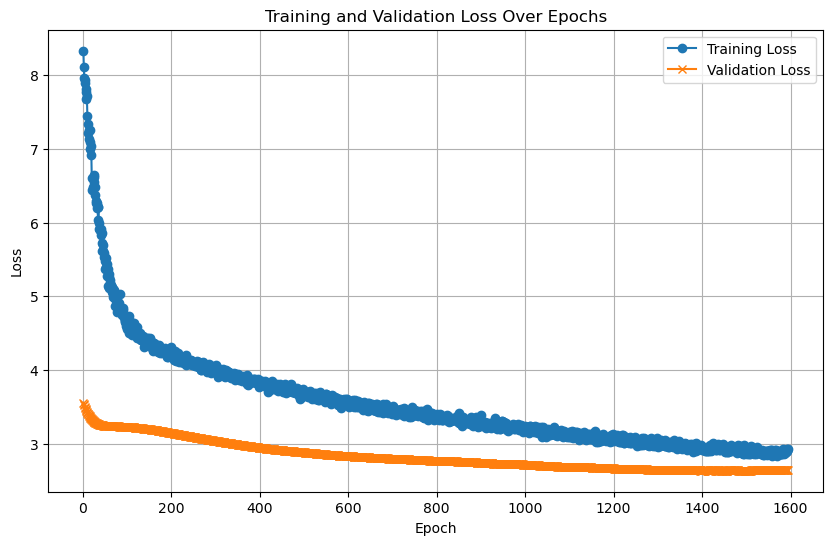

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/12], Loss: 5.2721



Test Loss: 4.9221


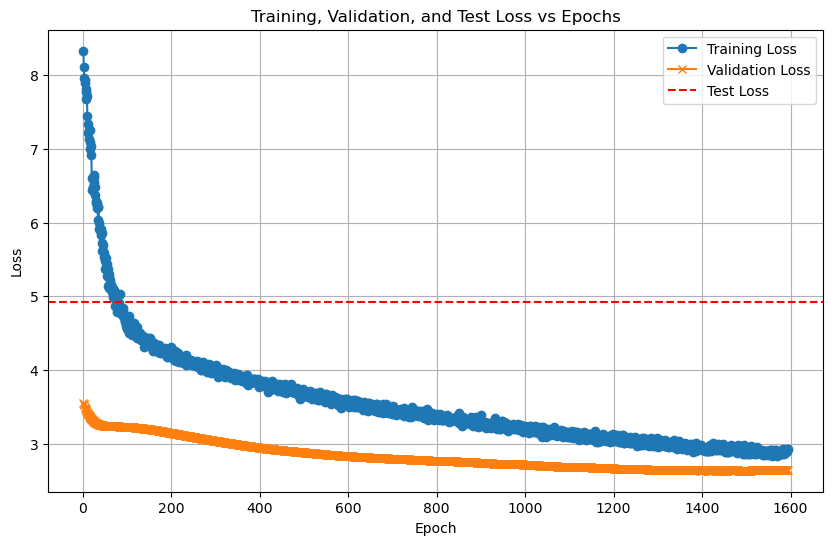

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 81.43%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       1.00      0.60      0.75         5
           3       0.71      1.00      0.83         5
           4       1.00      0.60      0.75         5
           5       0.40      0.40      0.40         5
           6       1.00      1.00      1.00         5
           7       0.62      1.00      0.77         5
           8       0.60      0.60      0.60         5
           9       0.83      1.00      0.91         5
          10       1.00      0.60      0.75         5
          11       1.00      1.00      1.00         5
          12       0.67      0.80      0.73         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6964  |  Val Loss: 2.6712
Validation loss improved from inf to 2.6712.
[Epoch 2/1000] Train Loss: 2.6645  |  Val Loss: 2.6469
Validation loss improved from 2.6712 to 2.6469.
[Epoch 3/1000] Train Loss: 2.6359  |  Val Loss: 2.6234
Validation loss improved from 2.6469 to 2.6234.
[Epoch 4/1000] Train Loss: 2.6101  |  Val Loss: 2.6017
Validation loss improved from 2.6234 to 2.6017.
[Epoch 5/1000] Train Loss: 2.5832  |  Val Loss: 2.5826
Validation loss improved from 2.6017 to 2.5826.
[Epoch 6/1000] Train Loss: 2.5600  |  Val Loss: 2.5654
Validation loss improved from 2.5826 to 2.5654.
[Epoch 7/1000] Train Loss: 2.5386  |  Val Loss: 2.5490
Validation loss improved from 2.5654 to 2.5490.
[Epoch 8/1000] Train Loss: 2.5198  |  Val Loss: 2.5323
Validation loss improved from 2.5490 to 2.5323.
[Epoch 9/1000] Train Loss: 2.5014  |  Val Loss: 2.5162
Validation loss improved from 2.5323 to 2.5162.
[Epoch 10/1000] Train Loss: 2.4832  |  Val Loss: 2.5005
Validation loss impr

[Epoch 18/1000] Train Loss: 2.3504  |  Val Loss: 2.3868
Validation loss improved from 2.4003 to 2.3868.
[Epoch 19/1000] Train Loss: 2.3366  |  Val Loss: 2.3738
Validation loss improved from 2.3868 to 2.3738.
[Epoch 20/1000] Train Loss: 2.3227  |  Val Loss: 2.3616
Validation loss improved from 2.3738 to 2.3616.
[Epoch 21/1000] Train Loss: 2.3094  |  Val Loss: 2.3501
Validation loss improved from 2.3616 to 2.3501.
[Epoch 22/1000] Train Loss: 2.2966  |  Val Loss: 2.3391
Validation loss improved from 2.3501 to 2.3391.
[Epoch 23/1000] Train Loss: 2.2847  |  Val Loss: 2.3283
Validation loss improved from 2.3391 to 2.3283.


[Epoch 24/1000] Train Loss: 2.2730  |  Val Loss: 2.3176
Validation loss improved from 2.3283 to 2.3176.


[Epoch 25/1000] Train Loss: 2.2606  |  Val Loss: 2.3069
Validation loss improved from 2.3176 to 2.3069.
[Epoch 26/1000] Train Loss: 2.2494  |  Val Loss: 2.2964
Validation loss improved from 2.3069 to 2.2964.
[Epoch 27/1000] Train Loss: 2.2378  |  Val Loss: 2.2862
Validation loss improved from 2.2964 to 2.2862.
[Epoch 28/1000] Train Loss: 2.2262  |  Val Loss: 2.2759
Validation loss improved from 2.2862 to 2.2759.
[Epoch 29/1000] Train Loss: 2.2147  |  Val Loss: 2.2657
Validation loss improved from 2.2759 to 2.2657.
[Epoch 30/1000] Train Loss: 2.2037  |  Val Loss: 2.2557
Validation loss improved from 2.2657 to 2.2557.
[Epoch 31/1000] Train Loss: 2.1921  |  Val Loss: 2.2462
Validation loss improved from 2.2557 to 2.2462.
[Epoch 32/1000] Train Loss: 2.1813  |  Val Loss: 2.2368
Validation loss improved from 2.2462 to 2.2368.
[Epoch 33/1000] Train Loss: 2.1706  |  Val Loss: 2.2274
Validation loss improved from 2.2368 to 2.2274.
[Epoch 34/1000] Train Loss: 2.1597  |  Val Loss: 2.2181
Validati

[Epoch 48/1000] Train Loss: 2.0165  |  Val Loss: 2.1000
Validation loss improved from 2.1078 to 2.1000.
[Epoch 49/1000] Train Loss: 2.0066  |  Val Loss: 2.0922
Validation loss improved from 2.1000 to 2.0922.
[Epoch 50/1000] Train Loss: 1.9966  |  Val Loss: 2.0846
Validation loss improved from 2.0922 to 2.0846.
[Epoch 51/1000] Train Loss: 1.9867  |  Val Loss: 2.0771
Validation loss improved from 2.0846 to 2.0771.
[Epoch 52/1000] Train Loss: 1.9771  |  Val Loss: 2.0695
Validation loss improved from 2.0771 to 2.0695.
[Epoch 53/1000] Train Loss: 1.9674  |  Val Loss: 2.0619
Validation loss improved from 2.0695 to 2.0619.


[Epoch 54/1000] Train Loss: 1.9579  |  Val Loss: 2.0543
Validation loss improved from 2.0619 to 2.0543.
[Epoch 55/1000] Train Loss: 1.9483  |  Val Loss: 2.0467
Validation loss improved from 2.0543 to 2.0467.
[Epoch 56/1000] Train Loss: 1.9390  |  Val Loss: 2.0392
Validation loss improved from 2.0467 to 2.0392.
[Epoch 57/1000] Train Loss: 1.9297  |  Val Loss: 2.0320
Validation loss improved from 2.0392 to 2.0320.
[Epoch 58/1000] Train Loss: 1.9197  |  Val Loss: 2.0248
Validation loss improved from 2.0320 to 2.0248.
[Epoch 59/1000] Train Loss: 1.9104  |  Val Loss: 2.0176
Validation loss improved from 2.0248 to 2.0176.
[Epoch 60/1000] Train Loss: 1.9007  |  Val Loss: 2.0104
Validation loss improved from 2.0176 to 2.0104.
[Epoch 61/1000] Train Loss: 1.8908  |  Val Loss: 2.0031
Validation loss improved from 2.0104 to 2.0031.
[Epoch 62/1000] Train Loss: 1.8818  |  Val Loss: 1.9958
Validation loss improved from 2.0031 to 1.9958.
[Epoch 63/1000] Train Loss: 1.8722  |  Val Loss: 1.9884
Validati

[Epoch 76/1000] Train Loss: 1.7572  |  Val Loss: 1.8974
Validation loss improved from 1.9042 to 1.8974.
[Epoch 77/1000] Train Loss: 1.7486  |  Val Loss: 1.8909
Validation loss improved from 1.8974 to 1.8909.
[Epoch 78/1000] Train Loss: 1.7400  |  Val Loss: 1.8843
Validation loss improved from 1.8909 to 1.8843.
[Epoch 79/1000] Train Loss: 1.7312  |  Val Loss: 1.8778
Validation loss improved from 1.8843 to 1.8778.
[Epoch 80/1000] Train Loss: 1.7227  |  Val Loss: 1.8713
Validation loss improved from 1.8778 to 1.8713.
[Epoch 81/1000] Train Loss: 1.7136  |  Val Loss: 1.8645
Validation loss improved from 1.8713 to 1.8645.


[Epoch 82/1000] Train Loss: 1.7052  |  Val Loss: 1.8575
Validation loss improved from 1.8645 to 1.8575.
[Epoch 83/1000] Train Loss: 1.6963  |  Val Loss: 1.8505
Validation loss improved from 1.8575 to 1.8505.
[Epoch 84/1000] Train Loss: 1.6877  |  Val Loss: 1.8438
Validation loss improved from 1.8505 to 1.8438.
[Epoch 85/1000] Train Loss: 1.6796  |  Val Loss: 1.8374
Validation loss improved from 1.8438 to 1.8374.
[Epoch 86/1000] Train Loss: 1.6706  |  Val Loss: 1.8308
Validation loss improved from 1.8374 to 1.8308.
[Epoch 87/1000] Train Loss: 1.6623  |  Val Loss: 1.8243
Validation loss improved from 1.8308 to 1.8243.
[Epoch 88/1000] Train Loss: 1.6539  |  Val Loss: 1.8180
Validation loss improved from 1.8243 to 1.8180.
[Epoch 89/1000] Train Loss: 1.6455  |  Val Loss: 1.8116
Validation loss improved from 1.8180 to 1.8116.
[Epoch 90/1000] Train Loss: 1.6367  |  Val Loss: 1.8050
Validation loss improved from 1.8116 to 1.8050.
[Epoch 91/1000] Train Loss: 1.6282  |  Val Loss: 1.7981
Validati

[Epoch 106/1000] Train Loss: 1.4963  |  Val Loss: 1.6939
Validation loss improved from 1.7009 to 1.6939.
[Epoch 107/1000] Train Loss: 1.4874  |  Val Loss: 1.6870
Validation loss improved from 1.6939 to 1.6870.
[Epoch 108/1000] Train Loss: 1.4787  |  Val Loss: 1.6803
Validation loss improved from 1.6870 to 1.6803.
[Epoch 109/1000] Train Loss: 1.4699  |  Val Loss: 1.6736
Validation loss improved from 1.6803 to 1.6736.
[Epoch 110/1000] Train Loss: 1.4610  |  Val Loss: 1.6668
Validation loss improved from 1.6736 to 1.6668.
[Epoch 111/1000] Train Loss: 1.4525  |  Val Loss: 1.6600
Validation loss improved from 1.6668 to 1.6600.


[Epoch 112/1000] Train Loss: 1.4438  |  Val Loss: 1.6535
Validation loss improved from 1.6600 to 1.6535.
[Epoch 113/1000] Train Loss: 1.4355  |  Val Loss: 1.6472
Validation loss improved from 1.6535 to 1.6472.
[Epoch 114/1000] Train Loss: 1.4270  |  Val Loss: 1.6408
Validation loss improved from 1.6472 to 1.6408.
[Epoch 115/1000] Train Loss: 1.4183  |  Val Loss: 1.6342
Validation loss improved from 1.6408 to 1.6342.
[Epoch 116/1000] Train Loss: 1.4095  |  Val Loss: 1.6276
Validation loss improved from 1.6342 to 1.6276.
[Epoch 117/1000] Train Loss: 1.4009  |  Val Loss: 1.6208
Validation loss improved from 1.6276 to 1.6208.
[Epoch 118/1000] Train Loss: 1.3923  |  Val Loss: 1.6140
Validation loss improved from 1.6208 to 1.6140.
[Epoch 119/1000] Train Loss: 1.3836  |  Val Loss: 1.6071
Validation loss improved from 1.6140 to 1.6071.
[Epoch 120/1000] Train Loss: 1.3750  |  Val Loss: 1.6002
Validation loss improved from 1.6071 to 1.6002.
[Epoch 121/1000] Train Loss: 1.3664  |  Val Loss: 1.593

[Epoch 140/1000] Train Loss: 1.2010  |  Val Loss: 1.4663
Validation loss improved from 1.4733 to 1.4663.
[Epoch 141/1000] Train Loss: 1.1925  |  Val Loss: 1.4590
Validation loss improved from 1.4663 to 1.4590.
[Epoch 142/1000] Train Loss: 1.1836  |  Val Loss: 1.4514
Validation loss improved from 1.4590 to 1.4514.
[Epoch 143/1000] Train Loss: 1.1748  |  Val Loss: 1.4437
Validation loss improved from 1.4514 to 1.4437.
[Epoch 144/1000] Train Loss: 1.1661  |  Val Loss: 1.4363
Validation loss improved from 1.4437 to 1.4363.
[Epoch 145/1000] Train Loss: 1.1578  |  Val Loss: 1.4292
Validation loss improved from 1.4363 to 1.4292.
[Epoch 146/1000] Train Loss: 1.1490  |  Val Loss: 1.4224
Validation loss improved from 1.4292 to 1.4224.
[Epoch 147/1000] Train Loss: 1.1409  |  Val Loss: 1.4157
Validation loss improved from 1.4224 to 1.4157.
[Epoch 148/1000] Train Loss: 1.1322  |  Val Loss: 1.4089
Validation loss improved from 1.4157 to 1.4089.
[Epoch 149/1000] Train Loss: 1.1238  |  Val Loss: 1.402

[Epoch 171/1000] Train Loss: 0.9531  |  Val Loss: 1.2640
Validation loss improved from 1.2701 to 1.2640.
[Epoch 172/1000] Train Loss: 0.9461  |  Val Loss: 1.2580
Validation loss improved from 1.2640 to 1.2580.
[Epoch 173/1000] Train Loss: 0.9392  |  Val Loss: 1.2519
Validation loss improved from 1.2580 to 1.2519.
[Epoch 174/1000] Train Loss: 0.9324  |  Val Loss: 1.2465
Validation loss improved from 1.2519 to 1.2465.
[Epoch 175/1000] Train Loss: 0.9255  |  Val Loss: 1.2408
Validation loss improved from 1.2465 to 1.2408.
[Epoch 176/1000] Train Loss: 0.9187  |  Val Loss: 1.2348
Validation loss improved from 1.2408 to 1.2348.
[Epoch 177/1000] Train Loss: 0.9120  |  Val Loss: 1.2289
Validation loss improved from 1.2348 to 1.2289.
[Epoch 178/1000] Train Loss: 0.9050  |  Val Loss: 1.2229
Validation loss improved from 1.2289 to 1.2229.
[Epoch 179/1000] Train Loss: 0.8985  |  Val Loss: 1.2172
Validation loss improved from 1.2229 to 1.2172.
[Epoch 180/1000] Train Loss: 0.8918  |  Val Loss: 1.211

[Epoch 204/1000] Train Loss: 0.7440  |  Val Loss: 1.0919
Validation loss improved from 1.0957 to 1.0919.
[Epoch 205/1000] Train Loss: 0.7380  |  Val Loss: 1.0875
Validation loss improved from 1.0919 to 1.0875.
[Epoch 206/1000] Train Loss: 0.7320  |  Val Loss: 1.0824
Validation loss improved from 1.0875 to 1.0824.
[Epoch 207/1000] Train Loss: 0.7264  |  Val Loss: 1.0776
Validation loss improved from 1.0824 to 1.0776.
[Epoch 208/1000] Train Loss: 0.7205  |  Val Loss: 1.0731
Validation loss improved from 1.0776 to 1.0731.
[Epoch 209/1000] Train Loss: 0.7152  |  Val Loss: 1.0690
Validation loss improved from 1.0731 to 1.0690.
[Epoch 210/1000] Train Loss: 0.7097  |  Val Loss: 1.0650
Validation loss improved from 1.0690 to 1.0650.
[Epoch 211/1000] Train Loss: 0.7045  |  Val Loss: 1.0607
Validation loss improved from 1.0650 to 1.0607.
[Epoch 212/1000] Train Loss: 0.6987  |  Val Loss: 1.0554
Validation loss improved from 1.0607 to 1.0554.
[Epoch 213/1000] Train Loss: 0.6935  |  Val Loss: 1.049

[Epoch 235/1000] Train Loss: 0.5802  |  Val Loss: 0.9637
Validation loss improved from 0.9670 to 0.9637.
[Epoch 236/1000] Train Loss: 0.5758  |  Val Loss: 0.9599
Validation loss improved from 0.9637 to 0.9599.
[Epoch 237/1000] Train Loss: 0.5709  |  Val Loss: 0.9558
Validation loss improved from 0.9599 to 0.9558.
[Epoch 238/1000] Train Loss: 0.5665  |  Val Loss: 0.9517
Validation loss improved from 0.9558 to 0.9517.
[Epoch 239/1000] Train Loss: 0.5619  |  Val Loss: 0.9481
Validation loss improved from 0.9517 to 0.9481.
[Epoch 240/1000] Train Loss: 0.5574  |  Val Loss: 0.9450
Validation loss improved from 0.9481 to 0.9450.
[Epoch 241/1000] Train Loss: 0.5530  |  Val Loss: 0.9423
Validation loss improved from 0.9450 to 0.9423.
[Epoch 242/1000] Train Loss: 0.5484  |  Val Loss: 0.9404
Validation loss improved from 0.9423 to 0.9404.
[Epoch 243/1000] Train Loss: 0.5437  |  Val Loss: 0.9387
Validation loss improved from 0.9404 to 0.9387.
[Epoch 244/1000] Train Loss: 0.5393  |  Val Loss: 0.936

[Epoch 266/1000] Train Loss: 0.4509  |  Val Loss: 0.8742
Validation loss improved from 0.8763 to 0.8742.
[Epoch 267/1000] Train Loss: 0.4472  |  Val Loss: 0.8726
Validation loss improved from 0.8742 to 0.8726.
[Epoch 268/1000] Train Loss: 0.4439  |  Val Loss: 0.8711
Validation loss improved from 0.8726 to 0.8711.
[Epoch 269/1000] Train Loss: 0.4403  |  Val Loss: 0.8683
Validation loss improved from 0.8711 to 0.8683.
[Epoch 270/1000] Train Loss: 0.4368  |  Val Loss: 0.8656
Validation loss improved from 0.8683 to 0.8656.
[Epoch 271/1000] Train Loss: 0.4338  |  Val Loss: 0.8631
Validation loss improved from 0.8656 to 0.8631.
[Epoch 272/1000] Train Loss: 0.4306  |  Val Loss: 0.8604
Validation loss improved from 0.8631 to 0.8604.
[Epoch 273/1000] Train Loss: 0.4269  |  Val Loss: 0.8573
Validation loss improved from 0.8604 to 0.8573.
[Epoch 274/1000] Train Loss: 0.4235  |  Val Loss: 0.8548
Validation loss improved from 0.8573 to 0.8548.
[Epoch 275/1000] Train Loss: 0.4201  |  Val Loss: 0.852

[Epoch 297/1000] Train Loss: 0.3536  |  Val Loss: 0.8226
Validation loss improved from 0.8239 to 0.8226.
[Epoch 298/1000] Train Loss: 0.3511  |  Val Loss: 0.8205
Validation loss improved from 0.8226 to 0.8205.
[Epoch 299/1000] Train Loss: 0.3481  |  Val Loss: 0.8172
Validation loss improved from 0.8205 to 0.8172.
[Epoch 300/1000] Train Loss: 0.3455  |  Val Loss: 0.8135
Validation loss improved from 0.8172 to 0.8135.
[Epoch 301/1000] Train Loss: 0.3428  |  Val Loss: 0.8106
Validation loss improved from 0.8135 to 0.8106.
[Epoch 302/1000] Train Loss: 0.3404  |  Val Loss: 0.8087
Validation loss improved from 0.8106 to 0.8087.
[Epoch 303/1000] Train Loss: 0.3376  |  Val Loss: 0.8070
Validation loss improved from 0.8087 to 0.8070.
[Epoch 304/1000] Train Loss: 0.3353  |  Val Loss: 0.8061
Validation loss improved from 0.8070 to 0.8061.
[Epoch 305/1000] Train Loss: 0.3331  |  Val Loss: 0.8059
Validation loss improved from 0.8061 to 0.8059.
[Epoch 306/1000] Train Loss: 0.3307  |  Val Loss: 0.807

[Epoch 328/1000] Train Loss: 0.2829  |  Val Loss: 0.7866
Validation loss improved from 0.7896 to 0.7866.
[Epoch 329/1000] Train Loss: 0.2807  |  Val Loss: 0.7837
Validation loss improved from 0.7866 to 0.7837.
[Epoch 330/1000] Train Loss: 0.2788  |  Val Loss: 0.7809
Validation loss improved from 0.7837 to 0.7809.
[Epoch 331/1000] Train Loss: 0.2769  |  Val Loss: 0.7785
Validation loss improved from 0.7809 to 0.7785.
[Epoch 332/1000] Train Loss: 0.2755  |  Val Loss: 0.7778
Validation loss improved from 0.7785 to 0.7778.
[Epoch 333/1000] Train Loss: 0.2734  |  Val Loss: 0.7792
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 334/1000] Train Loss: 0.2720  |  Val Loss: 0.7808
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 335/1000] Train Loss: 0.2701  |  Val Loss: 0.7832
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 336/1000] Train Loss: 0.2682  |  Val Loss: 0.7850
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 337/1000] Train Loss: 0.

[Epoch 359/1000] Train Loss: 0.2324  |  Val Loss: 0.7737
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 360/1000] Train Loss: 0.2310  |  Val Loss: 0.7743
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 361/1000] Train Loss: 0.2302  |  Val Loss: 0.7748
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 362/1000] Train Loss: 0.2289  |  Val Loss: 0.7724
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 363/1000] Train Loss: 0.2272  |  Val Loss: 0.7693
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 364/1000] Train Loss: 0.2257  |  Val Loss: 0.7670
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 365/1000] Train Loss: 0.2240  |  Val Loss: 0.7656
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 366/1000] Train Loss: 0.2228  |  Val Loss: 0.7629
Validation loss improved from 0.7649 to 0.7629.
[Epoch 367/1000] Train Loss: 0.2216  |  Val Loss: 0.7615
Validation loss improved from 0.7629 to 0.7615.
[Epoch 

[Epoch 390/1000] Train Loss: 0.1952  |  Val Loss: 0.7537
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 391/1000] Train Loss: 0.1942  |  Val Loss: 0.7542
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 392/1000] Train Loss: 0.1927  |  Val Loss: 0.7554
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 393/1000] Train Loss: 0.1917  |  Val Loss: 0.7568
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 394/1000] Train Loss: 0.1905  |  Val Loss: 0.7574
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 395/1000] Train Loss: 0.1895  |  Val Loss: 0.7577
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 396/1000] Train Loss: 0.1885  |  Val Loss: 0.7573
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 397/1000] Train Loss: 0.1877  |  Val Loss: 0.7567
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 398/1000] Train Loss: 0.1869  |  Val Loss: 0.7565
!! Validation loss did NOT improve !! Patience:

[Epoch 421/1000] Train Loss: 0.1663  |  Val Loss: 0.7536
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 422/1000] Train Loss: 0.1657  |  Val Loss: 0.7568
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 423/1000] Train Loss: 0.1649  |  Val Loss: 0.7593
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 424/1000] Train Loss: 0.1648  |  Val Loss: 0.7617
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 425/1000] Train Loss: 0.1641  |  Val Loss: 0.7626
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 426/1000] Train Loss: 0.1634  |  Val Loss: 0.7617
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 427/1000] Train Loss: 0.1625  |  Val Loss: 0.7602
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 428/1000] Train Loss: 0.1613  |  Val Loss: 0.7595
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 429/1000] Train Loss: 0.1607  |  Val Loss: 0.7595
!! Validation loss did NOT improve !! Patience:

[Epoch 453/1000] Train Loss: 0.1440  |  Val Loss: 0.7689
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 454/1000] Train Loss: 0.1431  |  Val Loss: 0.7710
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 455/1000] Train Loss: 0.1431  |  Val Loss: 0.7725
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 456/1000] Train Loss: 0.1422  |  Val Loss: 0.7731
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 457/1000] Train Loss: 0.1416  |  Val Loss: 0.7733
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 458/1000] Train Loss: 0.1409  |  Val Loss: 0.7723
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 459/1000] Train Loss: 0.1403  |  Val Loss: 0.7715
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 460/1000] Train Loss: 0.1397  |  Val Loss: 0.7707
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 461/1000] Train Loss: 0.1389  |  Val Loss: 0.7709
!! Validation loss did NOT improve !! Patience:

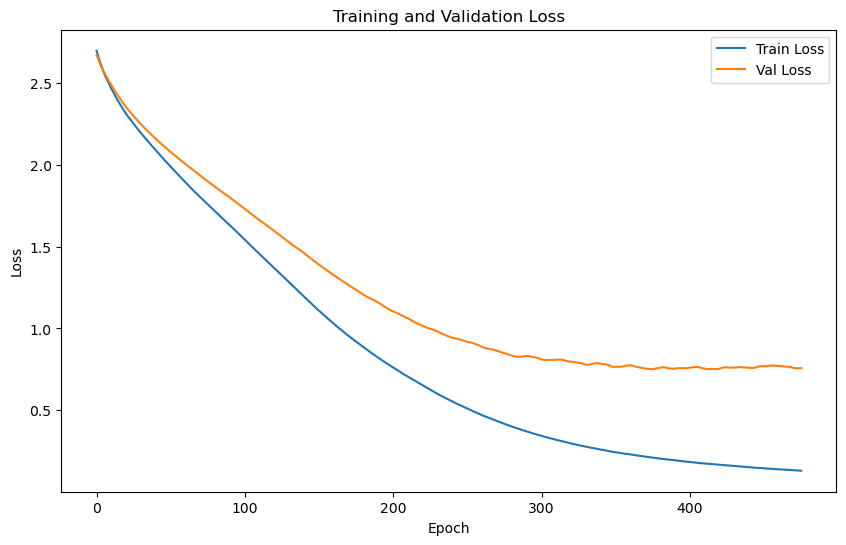

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.6007 | Test Accuracy: 81.34%


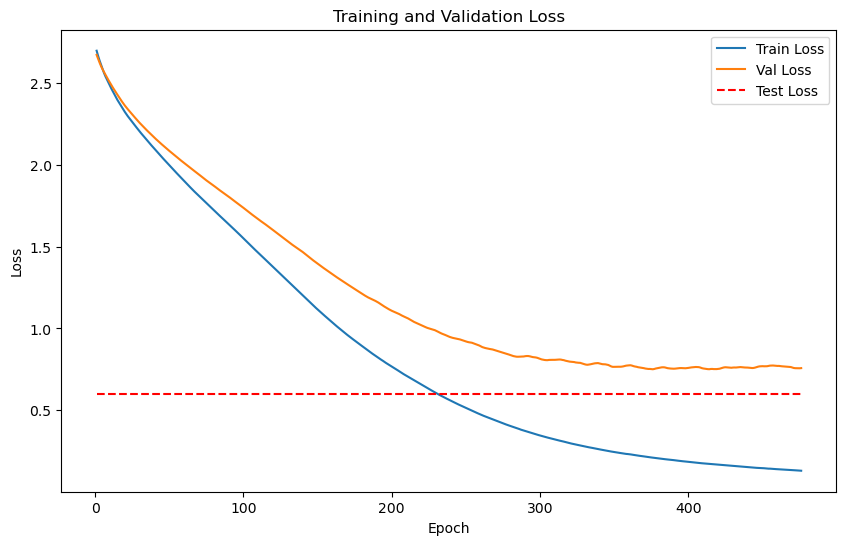

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)


Train embeddings shape: (140, 64), 
Train labels shape: (140,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3038, 64), 
Test labels shape: (3038,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10}
Training batch size: 140


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.4724
    Batch [2/2], Val Loss: 0.2486
Epoch [1/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.3605

Validation loss improved from inf to 0.3605. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4717
    Batch [2/2], Val Loss: 0.2514
Epoch [2/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.3616

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.4706
    Batch [2/2], Val Loss: 0.2536
Epoch [3/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.3621

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.2557
Epoch [4/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.3625

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.2569
Epoch [5/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.3626

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.2577
Epoch [6/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.3627

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.4673
    Batch [2/2], Val Loss: 0.2572
Epoch [7/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.3623

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.2551
Epoch [8/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.3613

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.2546
Epoch [9/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.3610

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4665
    Batch [2/2], Val Loss: 0.2536
Epoch [10/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.3601

Validation loss improved from 0.3605 to 0.3601. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4660
    Batch [2/2], Val Loss: 0.2515
Epoch [11/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.3588

Validation loss improved from 0.3601 to 0.3588. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4656
    Batch [2/2], Val Loss: 0.2477
Epoch [12/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.3567

Validation loss improved from 0.3588 to 0.3567. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4756
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4656
    Batch [2/2], Val Loss: 0.2455
Epoch [13/2000], Avg Train Loss: 0.4756, Avg Val Loss: 0.3555

Validation loss improved from 0.3567 to 0.3555. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4657
    Batch [2/2], Val Loss: 0.2430
Epoch [14/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.3543

Validation loss improved from 0.3555 to 0.3543. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4645
    Batch [2/2], Val Loss: 0.2415
Epoch [15/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.3530

Validation loss improved from 0.3543 to 0.3530. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4764
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4626
    Batch [2/2], Val Loss: 0.2398
Epoch [16/2000], Avg Train Loss: 0.4764, Avg Val Loss: 0.3512

Validation loss improved from 0.3530 to 0.3512. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4764
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4610
    Batch [2/2], Val Loss: 0.2376
Epoch [17/2000], Avg Train Loss: 0.4764, Avg Val Loss: 0.3493

Validation loss improved from 0.3512 to 0.3493. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.2348
Epoch [18/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.3471

Validation loss improved from 0.3493 to 0.3471. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4740
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.2312
Epoch [19/2000], Avg Train Loss: 0.4740, Avg Val Loss: 0.3443

Validation loss improved from 0.3471 to 0.3443. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4557
    Batch [2/2], Val Loss: 0.2255
Epoch [20/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.3406

Validation loss improved from 0.3443 to 0.3406. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4720
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4546
    Batch [2/2], Val Loss: 0.2190
Epoch [21/2000], Avg Train Loss: 0.4720, Avg Val Loss: 0.3368

Validation loss improved from 0.3406 to 0.3368. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4532
    Batch [2/2], Val Loss: 0.2132
Epoch [22/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.3332

Validation loss improved from 0.3368 to 0.3332. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.2082
Epoch [23/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.3301

Validation loss improved from 0.3332 to 0.3301. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4513
    Batch [2/2], Val Loss: 0.2031
Epoch [24/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.3272

Validation loss improved from 0.3301 to 0.3272. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4505
    Batch [2/2], Val Loss: 0.1966
Epoch [25/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.3235

Validation loss improved from 0.3272 to 0.3235. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4727
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.1888
Epoch [26/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.3188

Validation loss improved from 0.3235 to 0.3188. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.1811
Epoch [27/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.3146

Validation loss improved from 0.3188 to 0.3146. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4473
    Batch [2/2], Val Loss: 0.1744
Epoch [28/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.3108

Validation loss improved from 0.3146 to 0.3108. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4467
    Batch [2/2], Val Loss: 0.1676
Epoch [29/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.3071

Validation loss improved from 0.3108 to 0.3071. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4456
    Batch [2/2], Val Loss: 0.1616
Epoch [30/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.3036

Validation loss improved from 0.3071 to 0.3036. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4606
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4444
    Batch [2/2], Val Loss: 0.1570
Epoch [31/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.3007

Validation loss improved from 0.3036 to 0.3007. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4632
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4436
    Batch [2/2], Val Loss: 0.1528
Epoch [32/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.2982

Validation loss improved from 0.3007 to 0.2982. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4596
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4435
    Batch [2/2], Val Loss: 0.1499
Epoch [33/2000], Avg Train Loss: 0.4596, Avg Val Loss: 0.2967

Validation loss improved from 0.2982 to 0.2967. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4433
    Batch [2/2], Val Loss: 0.1473
Epoch [34/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.2953

Validation loss improved from 0.2967 to 0.2953. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4429
    Batch [2/2], Val Loss: 0.1457
Epoch [35/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.2943

Validation loss improved from 0.2953 to 0.2943. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4428
    Batch [2/2], Val Loss: 0.1443
Epoch [36/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.2936

Validation loss improved from 0.2943 to 0.2936. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4428
    Batch [2/2], Val Loss: 0.1433
Epoch [37/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.2931

Validation loss improved from 0.2936 to 0.2931. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4553
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4428
    Batch [2/2], Val Loss: 0.1425
Epoch [38/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.2927

Validation loss improved from 0.2931 to 0.2927. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4430
    Batch [2/2], Val Loss: 0.1420
Epoch [39/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.2925

Validation loss improved from 0.2927 to 0.2925. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4432
    Batch [2/2], Val Loss: 0.1419
Epoch [40/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4436
    Batch [2/2], Val Loss: 0.1416
Epoch [41/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.2926

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4439
    Batch [2/2], Val Loss: 0.1415
Epoch [42/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4443
    Batch [2/2], Val Loss: 0.1415
Epoch [43/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.2929

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4446
    Batch [2/2], Val Loss: 0.1412
Epoch [44/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.2929

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4451
    Batch [2/2], Val Loss: 0.1410
Epoch [45/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.2931

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4555
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4455
    Batch [2/2], Val Loss: 0.1410
Epoch [46/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.2932

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4458
    Batch [2/2], Val Loss: 0.1411
Epoch [47/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.2934

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4461
    Batch [2/2], Val Loss: 0.1413
Epoch [48/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.2937

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4463
    Batch [2/2], Val Loss: 0.1414
Epoch [49/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.2938

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4464
    Batch [2/2], Val Loss: 0.1414
Epoch [50/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.2939

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4467
    Batch [2/2], Val Loss: 0.1413
Epoch [51/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.2940

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4469
    Batch [2/2], Val Loss: 0.1410
Epoch [52/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.2940

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4471
    Batch [2/2], Val Loss: 0.1405
Epoch [53/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.2938

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4474
    Batch [2/2], Val Loss: 0.1399
Epoch [54/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.2937

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4406
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4476
    Batch [2/2], Val Loss: 0.1394
Epoch [55/2000], Avg Train Loss: 0.4406, Avg Val Loss: 0.2935

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4478
    Batch [2/2], Val Loss: 0.1390
Epoch [56/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.2934

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.1385
Epoch [57/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.2933

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.1381
Epoch [58/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.2932

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.1375
Epoch [59/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.2931

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.1372
Epoch [60/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.2931

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.1369
Epoch [61/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.2930

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.1367
Epoch [62/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.2929

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.1365
Epoch [63/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.2928

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.1366
Epoch [64/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.2929

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.1370
Epoch [65/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.2931

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4393
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.1350
Epoch [66/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.2915

Validation loss improved from 0.2925 to 0.2915. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4467
    Batch [2/2], Val Loss: 0.1331
Epoch [67/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.2899

Validation loss improved from 0.2915 to 0.2899. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4379
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4457
    Batch [2/2], Val Loss: 0.1313
Epoch [68/2000], Avg Train Loss: 0.4379, Avg Val Loss: 0.2885

Validation loss improved from 0.2899 to 0.2885. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4445
    Batch [2/2], Val Loss: 0.1296
Epoch [69/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.2871

Validation loss improved from 0.2885 to 0.2871. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4360
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4435
    Batch [2/2], Val Loss: 0.1280
Epoch [70/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.2858

Validation loss improved from 0.2871 to 0.2858. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4322
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4425
    Batch [2/2], Val Loss: 0.1266
Epoch [71/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.2846

Validation loss improved from 0.2858 to 0.2846. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4417
    Batch [2/2], Val Loss: 0.1254
Epoch [72/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.2836

Validation loss improved from 0.2846 to 0.2836. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4346
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4409
    Batch [2/2], Val Loss: 0.1244
Epoch [73/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.2827

Validation loss improved from 0.2836 to 0.2827. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4402
    Batch [2/2], Val Loss: 0.1235
Epoch [74/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.2819

Validation loss improved from 0.2827 to 0.2819. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4395
    Batch [2/2], Val Loss: 0.1228
Epoch [75/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.2811

Validation loss improved from 0.2819 to 0.2811. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4358
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4389
    Batch [2/2], Val Loss: 0.1222
Epoch [76/2000], Avg Train Loss: 0.4358, Avg Val Loss: 0.2805

Validation loss improved from 0.2811 to 0.2805. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4381
    Batch [2/2], Val Loss: 0.1218
Epoch [77/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.2800

Validation loss improved from 0.2805 to 0.2800. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4373
    Batch [2/2], Val Loss: 0.1214
Epoch [78/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.2794

Validation loss improved from 0.2800 to 0.2794. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4366
    Batch [2/2], Val Loss: 0.1213
Epoch [79/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.2789

Validation loss improved from 0.2794 to 0.2789. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4359
    Batch [2/2], Val Loss: 0.1213
Epoch [80/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.2786

Validation loss improved from 0.2789 to 0.2786. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4352
    Batch [2/2], Val Loss: 0.1214
Epoch [81/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.2783

Validation loss improved from 0.2786 to 0.2783. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4346
    Batch [2/2], Val Loss: 0.1216
Epoch [82/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.2781

Validation loss improved from 0.2783 to 0.2781. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4340
    Batch [2/2], Val Loss: 0.1218
Epoch [83/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.2779

Validation loss improved from 0.2781 to 0.2779. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4335
    Batch [2/2], Val Loss: 0.1220
Epoch [84/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.2778

Validation loss improved from 0.2779 to 0.2778. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4331
    Batch [2/2], Val Loss: 0.1223
Epoch [85/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.2777

Validation loss improved from 0.2778 to 0.2777. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4326
    Batch [2/2], Val Loss: 0.1227
Epoch [86/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.2776

Validation loss improved from 0.2777 to 0.2776. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4323
    Batch [2/2], Val Loss: 0.1230
Epoch [87/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.2776

Validation loss improved from 0.2776 to 0.2776. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4319
    Batch [2/2], Val Loss: 0.1233
Epoch [88/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.2776

Validation loss improved from 0.2776 to 0.2776. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4316
    Batch [2/2], Val Loss: 0.1235
Epoch [89/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.2776

Validation loss improved from 0.2776 to 0.2776. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4314
    Batch [2/2], Val Loss: 0.1238
Epoch [90/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.2776

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.1241
Epoch [91/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.2776

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4310
    Batch [2/2], Val Loss: 0.1243
Epoch [92/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.2776

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4308
    Batch [2/2], Val Loss: 0.1245
Epoch [93/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.2777

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4306
    Batch [2/2], Val Loss: 0.1247
Epoch [94/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.2777

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4304
    Batch [2/2], Val Loss: 0.1249
Epoch [95/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.2777

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.1251
Epoch [96/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.2777

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4328
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4301
    Batch [2/2], Val Loss: 0.1253
Epoch [97/2000], Avg Train Loss: 0.4328, Avg Val Loss: 0.2777

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4299
    Batch [2/2], Val Loss: 0.1254
Epoch [98/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.2776

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4298
    Batch [2/2], Val Loss: 0.1255
Epoch [99/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.2776

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4297
    Batch [2/2], Val Loss: 0.1255
Epoch [100/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.2776

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4361
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4296
    Batch [2/2], Val Loss: 0.1255
Epoch [101/2000], Avg Train Loss: 0.4361, Avg Val Loss: 0.2775

Validation loss improved from 0.2776 to 0.2775. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4294
    Batch [2/2], Val Loss: 0.1255
Epoch [102/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.2775

Validation loss improved from 0.2775 to 0.2775. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4293
    Batch [2/2], Val Loss: 0.1256
Epoch [103/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.2774

Validation loss improved from 0.2775 to 0.2774. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4292
    Batch [2/2], Val Loss: 0.1256
Epoch [104/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.2774

Validation loss improved from 0.2774 to 0.2774. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4290
    Batch [2/2], Val Loss: 0.1256
Epoch [105/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.2773

Validation loss improved from 0.2774 to 0.2773. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4289
    Batch [2/2], Val Loss: 0.1256
Epoch [106/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.2773

Validation loss improved from 0.2773 to 0.2773. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4288
    Batch [2/2], Val Loss: 0.1256
Epoch [107/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.2772

Validation loss improved from 0.2773 to 0.2772. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4287
    Batch [2/2], Val Loss: 0.1256
Epoch [108/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.2771

Validation loss improved from 0.2772 to 0.2771. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4337
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4286
    Batch [2/2], Val Loss: 0.1256
Epoch [109/2000], Avg Train Loss: 0.4337, Avg Val Loss: 0.2771

Validation loss improved from 0.2771 to 0.2771. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4285
    Batch [2/2], Val Loss: 0.1255
Epoch [110/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.2770

Validation loss improved from 0.2771 to 0.2770. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4283
    Batch [2/2], Val Loss: 0.1255
Epoch [111/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.2769

Validation loss improved from 0.2770 to 0.2769. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4282
    Batch [2/2], Val Loss: 0.1255
Epoch [112/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.2768

Validation loss improved from 0.2769 to 0.2768. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4281
    Batch [2/2], Val Loss: 0.1254
Epoch [113/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.2768

Validation loss improved from 0.2768 to 0.2768. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4280
    Batch [2/2], Val Loss: 0.1253
Epoch [114/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.2767

Validation loss improved from 0.2768 to 0.2767. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4323
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4279
    Batch [2/2], Val Loss: 0.1253
Epoch [115/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.2766

Validation loss improved from 0.2767 to 0.2766. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4279
    Batch [2/2], Val Loss: 0.1252
Epoch [116/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.2765

Validation loss improved from 0.2766 to 0.2765. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4278
    Batch [2/2], Val Loss: 0.1250
Epoch [117/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.2764

Validation loss improved from 0.2765 to 0.2764. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4379
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4276
    Batch [2/2], Val Loss: 0.1250
Epoch [118/2000], Avg Train Loss: 0.4379, Avg Val Loss: 0.2763

Validation loss improved from 0.2764 to 0.2763. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4275
    Batch [2/2], Val Loss: 0.1249
Epoch [119/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.2762

Validation loss improved from 0.2763 to 0.2762. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4274
    Batch [2/2], Val Loss: 0.1248
Epoch [120/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.2761

Validation loss improved from 0.2762 to 0.2761. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4273
    Batch [2/2], Val Loss: 0.1247
Epoch [121/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.2760

Validation loss improved from 0.2761 to 0.2760. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4273
    Batch [2/2], Val Loss: 0.1247
Epoch [122/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.2760

Validation loss improved from 0.2760 to 0.2760. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4272
    Batch [2/2], Val Loss: 0.1246
Epoch [123/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.2759

Validation loss improved from 0.2760 to 0.2759. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4272
    Batch [2/2], Val Loss: 0.1246
Epoch [124/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.2759

Validation loss improved from 0.2759 to 0.2759. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4271
    Batch [2/2], Val Loss: 0.1245
Epoch [125/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.2758

Validation loss improved from 0.2759 to 0.2758. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4270
    Batch [2/2], Val Loss: 0.1244
Epoch [126/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.2757

Validation loss improved from 0.2758 to 0.2757. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4269
    Batch [2/2], Val Loss: 0.1243
Epoch [127/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.2756

Validation loss improved from 0.2757 to 0.2756. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4269
    Batch [2/2], Val Loss: 0.1241
Epoch [128/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.2755

Validation loss improved from 0.2756 to 0.2755. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4268
    Batch [2/2], Val Loss: 0.1241
Epoch [129/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.2754

Validation loss improved from 0.2755 to 0.2754. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.1240
Epoch [130/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.2754

Validation loss improved from 0.2754 to 0.2754. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.1239
Epoch [131/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.2753

Validation loss improved from 0.2754 to 0.2753. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4330
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4266
    Batch [2/2], Val Loss: 0.1239
Epoch [132/2000], Avg Train Loss: 0.4330, Avg Val Loss: 0.2752

Validation loss improved from 0.2753 to 0.2752. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4328
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4265
    Batch [2/2], Val Loss: 0.1238
Epoch [133/2000], Avg Train Loss: 0.4328, Avg Val Loss: 0.2752

Validation loss improved from 0.2752 to 0.2752. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4343
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4265
    Batch [2/2], Val Loss: 0.1238
Epoch [134/2000], Avg Train Loss: 0.4343, Avg Val Loss: 0.2751

Validation loss improved from 0.2752 to 0.2751. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4264
    Batch [2/2], Val Loss: 0.1238
Epoch [135/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.2751

Validation loss improved from 0.2751 to 0.2751. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4337
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4264
    Batch [2/2], Val Loss: 0.1238
Epoch [136/2000], Avg Train Loss: 0.4337, Avg Val Loss: 0.2751

Validation loss improved from 0.2751 to 0.2751. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4264
    Batch [2/2], Val Loss: 0.1238
Epoch [137/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.2751

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4386
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4264
    Batch [2/2], Val Loss: 0.1238
Epoch [138/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.2751

Validation loss improved from 0.2751 to 0.2751. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4379
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4264
    Batch [2/2], Val Loss: 0.1237
Epoch [139/2000], Avg Train Loss: 0.4379, Avg Val Loss: 0.2751

Validation loss improved from 0.2751 to 0.2751. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4264
    Batch [2/2], Val Loss: 0.1237
Epoch [140/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.2750

Validation loss improved from 0.2751 to 0.2750. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4263
    Batch [2/2], Val Loss: 0.1236
Epoch [141/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.2750

Validation loss improved from 0.2750 to 0.2750. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4263
    Batch [2/2], Val Loss: 0.1236
Epoch [142/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.2749

Validation loss improved from 0.2750 to 0.2749. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4262
    Batch [2/2], Val Loss: 0.1235
Epoch [143/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.2749

Validation loss improved from 0.2749 to 0.2749. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4261
    Batch [2/2], Val Loss: 0.1234
Epoch [144/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.2748

Validation loss improved from 0.2749 to 0.2748. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4261
    Batch [2/2], Val Loss: 0.1233
Epoch [145/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.2747

Validation loss improved from 0.2748 to 0.2747. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4301
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4261
    Batch [2/2], Val Loss: 0.1233
Epoch [146/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.2747

Validation loss improved from 0.2747 to 0.2747. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4261
    Batch [2/2], Val Loss: 0.1232
Epoch [147/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.2746

Validation loss improved from 0.2747 to 0.2746. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1232
Epoch [148/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.2746

Validation loss improved from 0.2746 to 0.2746. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1231
Epoch [149/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.2746

Validation loss improved from 0.2746 to 0.2746. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1231
Epoch [150/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.2746

Validation loss improved from 0.2746 to 0.2746. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1231
Epoch [151/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.2745

Validation loss improved from 0.2746 to 0.2745. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4267
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1231
Epoch [152/2000], Avg Train Loss: 0.4267, Avg Val Loss: 0.2745

Validation loss improved from 0.2745 to 0.2745. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1230
Epoch [153/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.2745

Validation loss improved from 0.2745 to 0.2745. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1230
Epoch [154/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.2744

Validation loss improved from 0.2745 to 0.2744. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4313
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1229
Epoch [155/2000], Avg Train Loss: 0.4313, Avg Val Loss: 0.2744

Validation loss improved from 0.2744 to 0.2744. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1229
Epoch [156/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.2744

Validation loss improved from 0.2744 to 0.2744. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.1228
Epoch [157/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.2743

Validation loss improved from 0.2744 to 0.2743. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.1228
Epoch [158/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.2743

Validation loss improved from 0.2743 to 0.2743. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.1228
Epoch [159/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.2743

Validation loss improved from 0.2743 to 0.2743. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.1227
Epoch [160/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.2743

Validation loss improved from 0.2743 to 0.2743. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4337
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.1227
Epoch [161/2000], Avg Train Loss: 0.4337, Avg Val Loss: 0.2742

Validation loss improved from 0.2743 to 0.2742. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.1226
Epoch [162/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.2742

Validation loss improved from 0.2742 to 0.2742. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4356
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.1226
Epoch [163/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.2742

Validation loss improved from 0.2742 to 0.2742. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1225
Epoch [164/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.2742

Validation loss improved from 0.2742 to 0.2742. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1225
Epoch [165/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.2742

Validation loss improved from 0.2742 to 0.2742. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1225
Epoch [166/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.2742

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4282
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1224
Epoch [167/2000], Avg Train Loss: 0.4282, Avg Val Loss: 0.2741

Validation loss improved from 0.2742 to 0.2741. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1223
Epoch [168/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.2741

Validation loss improved from 0.2741 to 0.2741. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4331
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1223
Epoch [169/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.2741

Validation loss improved from 0.2741 to 0.2741. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1222
Epoch [170/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.2740

Validation loss improved from 0.2741 to 0.2740. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.1221
Epoch [171/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.2740

Validation loss improved from 0.2740 to 0.2740. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.1220
Epoch [172/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.2739

Validation loss improved from 0.2740 to 0.2739. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4257
    Batch [2/2], Val Loss: 0.1219
Epoch [173/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.2738

Validation loss improved from 0.2739 to 0.2738. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.1218
Epoch [174/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.2737

Validation loss improved from 0.2738 to 0.2737. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.1217
Epoch [175/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.2737

Validation loss improved from 0.2737 to 0.2737. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4330
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.1217
Epoch [176/2000], Avg Train Loss: 0.4330, Avg Val Loss: 0.2736

Validation loss improved from 0.2737 to 0.2736. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.1216
Epoch [177/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.2736

Validation loss improved from 0.2736 to 0.2736. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4255
    Batch [2/2], Val Loss: 0.1215
Epoch [178/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.2735

Validation loss improved from 0.2736 to 0.2735. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.1215
Epoch [179/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.2735

Validation loss improved from 0.2735 to 0.2735. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.1214
Epoch [180/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4276
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4257
    Batch [2/2], Val Loss: 0.1214
Epoch [181/2000], Avg Train Loss: 0.4276, Avg Val Loss: 0.2735

Validation loss improved from 0.2735 to 0.2735. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4257
    Batch [2/2], Val Loss: 0.1213
Epoch [182/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.2735

Validation loss improved from 0.2735 to 0.2735. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4199
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.1213
Epoch [183/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.2735

Validation loss improved from 0.2735 to 0.2735. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4257
    Batch [2/2], Val Loss: 0.1212
Epoch [184/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.2734

Validation loss improved from 0.2735 to 0.2734. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.1212
Epoch [185/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.2734

Validation loss improved from 0.2734 to 0.2734. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.1211
Epoch [186/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.2734

Validation loss improved from 0.2734 to 0.2734. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.1210
Epoch [187/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.2733

Validation loss improved from 0.2734 to 0.2733. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4331
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4255
    Batch [2/2], Val Loss: 0.1210
Epoch [188/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.2732

Validation loss improved from 0.2733 to 0.2732. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4255
    Batch [2/2], Val Loss: 0.1209
Epoch [189/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.2732

Validation loss improved from 0.2732 to 0.2732. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4267
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4254
    Batch [2/2], Val Loss: 0.1208
Epoch [190/2000], Avg Train Loss: 0.4267, Avg Val Loss: 0.2731

Validation loss improved from 0.2732 to 0.2731. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4254
    Batch [2/2], Val Loss: 0.1207
Epoch [191/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.2730

Validation loss improved from 0.2731 to 0.2730. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4253
    Batch [2/2], Val Loss: 0.1206
Epoch [192/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.2730

Validation loss improved from 0.2730 to 0.2730. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4253
    Batch [2/2], Val Loss: 0.1205
Epoch [193/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.2729

Validation loss improved from 0.2730 to 0.2729. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4252
    Batch [2/2], Val Loss: 0.1204
Epoch [194/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.2728

Validation loss improved from 0.2729 to 0.2728. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4252
    Batch [2/2], Val Loss: 0.1204
Epoch [195/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2728

Validation loss improved from 0.2728 to 0.2728. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4346
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4251
    Batch [2/2], Val Loss: 0.1204
Epoch [196/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.2727

Validation loss improved from 0.2728 to 0.2727. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4251
    Batch [2/2], Val Loss: 0.1204
Epoch [197/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2727

Validation loss improved from 0.2727 to 0.2727. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4250
    Batch [2/2], Val Loss: 0.1203
Epoch [198/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.2727

Validation loss improved from 0.2727 to 0.2727. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4250
    Batch [2/2], Val Loss: 0.1202
Epoch [199/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.2726

Validation loss improved from 0.2727 to 0.2726. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4250
    Batch [2/2], Val Loss: 0.1201
Epoch [200/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.2726

Validation loss improved from 0.2726 to 0.2726. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4250
    Batch [2/2], Val Loss: 0.1201
Epoch [201/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.2725

Validation loss improved from 0.2726 to 0.2725. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4250
    Batch [2/2], Val Loss: 0.1200
Epoch [202/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.2725

Validation loss improved from 0.2725 to 0.2725. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4249
    Batch [2/2], Val Loss: 0.1200
Epoch [203/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.2725

Validation loss improved from 0.2725 to 0.2725. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4249
    Batch [2/2], Val Loss: 0.1200
Epoch [204/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.2725

Validation loss improved from 0.2725 to 0.2725. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4322
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4249
    Batch [2/2], Val Loss: 0.1200
Epoch [205/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.2724

Validation loss improved from 0.2725 to 0.2724. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4248
    Batch [2/2], Val Loss: 0.1200
Epoch [206/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.2724

Validation loss improved from 0.2724 to 0.2724. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4247
    Batch [2/2], Val Loss: 0.1200
Epoch [207/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.2724

Validation loss improved from 0.2724 to 0.2724. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4247
    Batch [2/2], Val Loss: 0.1200
Epoch [208/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.2724

Validation loss improved from 0.2724 to 0.2724. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4326
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4247
    Batch [2/2], Val Loss: 0.1200
Epoch [209/2000], Avg Train Loss: 0.4326, Avg Val Loss: 0.2723

Validation loss improved from 0.2724 to 0.2723. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4246
    Batch [2/2], Val Loss: 0.1200
Epoch [210/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.2723

Validation loss improved from 0.2723 to 0.2723. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4246
    Batch [2/2], Val Loss: 0.1200
Epoch [211/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.2723

Validation loss improved from 0.2723 to 0.2723. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4246
    Batch [2/2], Val Loss: 0.1200
Epoch [212/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.2723

Validation loss improved from 0.2723 to 0.2723. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4245
    Batch [2/2], Val Loss: 0.1199
Epoch [213/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.2722

Validation loss improved from 0.2723 to 0.2722. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4244
    Batch [2/2], Val Loss: 0.1199
Epoch [214/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.2722

Validation loss improved from 0.2722 to 0.2722. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4244
    Batch [2/2], Val Loss: 0.1198
Epoch [215/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.2721

Validation loss improved from 0.2722 to 0.2721. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1198
Epoch [216/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.2720

Validation loss improved from 0.2721 to 0.2720. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1197
Epoch [217/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.2720

Validation loss improved from 0.2720 to 0.2720. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.1196
Epoch [218/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.2719

Validation loss improved from 0.2720 to 0.2719. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4241
    Batch [2/2], Val Loss: 0.1195
Epoch [219/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.2718

Validation loss improved from 0.2719 to 0.2718. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4240
    Batch [2/2], Val Loss: 0.1194
Epoch [220/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.2717

Validation loss improved from 0.2718 to 0.2717. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4238
    Batch [2/2], Val Loss: 0.1193
Epoch [221/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.2716

Validation loss improved from 0.2717 to 0.2716. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4237
    Batch [2/2], Val Loss: 0.1192
Epoch [222/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.2714

Validation loss improved from 0.2716 to 0.2714. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4359
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4236
    Batch [2/2], Val Loss: 0.1191
Epoch [223/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.2713

Validation loss improved from 0.2714 to 0.2713. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4235
    Batch [2/2], Val Loss: 0.1189
Epoch [224/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.2712

Validation loss improved from 0.2713 to 0.2712. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4235
    Batch [2/2], Val Loss: 0.1188
Epoch [225/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.2712

Validation loss improved from 0.2712 to 0.2712. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.1187
Epoch [226/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.2710

Validation loss improved from 0.2712 to 0.2710. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1186
Epoch [227/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.2709

Validation loss improved from 0.2710 to 0.2709. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4232
    Batch [2/2], Val Loss: 0.1185
Epoch [228/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.2709

Validation loss improved from 0.2709 to 0.2709. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4231
    Batch [2/2], Val Loss: 0.1184
Epoch [229/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.2708

Validation loss improved from 0.2709 to 0.2708. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4231
    Batch [2/2], Val Loss: 0.1183
Epoch [230/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.2707

Validation loss improved from 0.2708 to 0.2707. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4230
    Batch [2/2], Val Loss: 0.1183
Epoch [231/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.2706

Validation loss improved from 0.2707 to 0.2706. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4230
    Batch [2/2], Val Loss: 0.1182
Epoch [232/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4272
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.1182
Epoch [233/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.2705

Validation loss improved from 0.2706 to 0.2705. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.1181
Epoch [234/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4334
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4228
    Batch [2/2], Val Loss: 0.1181
Epoch [235/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4227
    Batch [2/2], Val Loss: 0.1181
Epoch [236/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.2704

Validation loss improved from 0.2705 to 0.2704. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4227
    Batch [2/2], Val Loss: 0.1180
Epoch [237/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.2703

Validation loss improved from 0.2704 to 0.2703. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4226
    Batch [2/2], Val Loss: 0.1179
Epoch [238/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.2703

Validation loss improved from 0.2703 to 0.2703. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4269
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4226
    Batch [2/2], Val Loss: 0.1178
Epoch [239/2000], Avg Train Loss: 0.4269, Avg Val Loss: 0.2702

Validation loss improved from 0.2703 to 0.2702. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4263
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.1177
Epoch [240/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.2701

Validation loss improved from 0.2702 to 0.2701. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.1177
Epoch [241/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.2700

Validation loss improved from 0.2701 to 0.2700. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.1176
Epoch [242/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.2700

Validation loss improved from 0.2700 to 0.2700. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4356
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4222
    Batch [2/2], Val Loss: 0.1176
Epoch [243/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.2699

Validation loss improved from 0.2700 to 0.2699. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4222
    Batch [2/2], Val Loss: 0.1176
Epoch [244/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.2699

Validation loss improved from 0.2699 to 0.2699. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4221
    Batch [2/2], Val Loss: 0.1176
Epoch [245/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.2698

Validation loss improved from 0.2699 to 0.2698. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4276
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4220
    Batch [2/2], Val Loss: 0.1175
Epoch [246/2000], Avg Train Loss: 0.4276, Avg Val Loss: 0.2698

Validation loss improved from 0.2698 to 0.2698. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4219
    Batch [2/2], Val Loss: 0.1175
Epoch [247/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.2697

Validation loss improved from 0.2698 to 0.2697. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4218
    Batch [2/2], Val Loss: 0.1175
Epoch [248/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.2696

Validation loss improved from 0.2697 to 0.2696. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4217
    Batch [2/2], Val Loss: 0.1174
Epoch [249/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.2696

Validation loss improved from 0.2696 to 0.2696. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4337
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4216
    Batch [2/2], Val Loss: 0.1174
Epoch [250/2000], Avg Train Loss: 0.4337, Avg Val Loss: 0.2695

Validation loss improved from 0.2696 to 0.2695. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4215
    Batch [2/2], Val Loss: 0.1173
Epoch [251/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.2694

Validation loss improved from 0.2695 to 0.2694. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4214
    Batch [2/2], Val Loss: 0.1172
Epoch [252/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2693

Validation loss improved from 0.2694 to 0.2693. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4213
    Batch [2/2], Val Loss: 0.1172
Epoch [253/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.2692

Validation loss improved from 0.2693 to 0.2692. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4212
    Batch [2/2], Val Loss: 0.1171
Epoch [254/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.2692

Validation loss improved from 0.2692 to 0.2692. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4210
    Batch [2/2], Val Loss: 0.1171
Epoch [255/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.2691

Validation loss improved from 0.2692 to 0.2691. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4263
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4209
    Batch [2/2], Val Loss: 0.1171
Epoch [256/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.2690

Validation loss improved from 0.2691 to 0.2690. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.1170
Epoch [257/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.2689

Validation loss improved from 0.2690 to 0.2689. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1170
Epoch [258/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.2689

Validation loss improved from 0.2689 to 0.2689. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4274
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4206
    Batch [2/2], Val Loss: 0.1169
Epoch [259/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.2688

Validation loss improved from 0.2689 to 0.2688. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4205
    Batch [2/2], Val Loss: 0.1169
Epoch [260/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.2687

Validation loss improved from 0.2688 to 0.2687. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4204
    Batch [2/2], Val Loss: 0.1168
Epoch [261/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.2686

Validation loss improved from 0.2687 to 0.2686. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4204
    Batch [2/2], Val Loss: 0.1167
Epoch [262/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.2685

Validation loss improved from 0.2686 to 0.2685. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4202
    Batch [2/2], Val Loss: 0.1166
Epoch [263/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.2684

Validation loss improved from 0.2685 to 0.2684. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4202
    Batch [2/2], Val Loss: 0.1165
Epoch [264/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.2683

Validation loss improved from 0.2684 to 0.2683. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4191
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4201
    Batch [2/2], Val Loss: 0.1164
Epoch [265/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.2683

Validation loss improved from 0.2683 to 0.2683. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.1164
Epoch [266/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.2682

Validation loss improved from 0.2683 to 0.2682. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4326
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.1164
Epoch [267/2000], Avg Train Loss: 0.4326, Avg Val Loss: 0.2681

Validation loss improved from 0.2682 to 0.2681. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4219
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.1163
Epoch [268/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.2681

Validation loss improved from 0.2681 to 0.2681. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1163
Epoch [269/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.2680

Validation loss improved from 0.2681 to 0.2680. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1163
Epoch [270/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.2680

Validation loss improved from 0.2680 to 0.2680. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.1163
Epoch [271/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.2680

Validation loss improved from 0.2680 to 0.2680. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4278
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.1163
Epoch [272/2000], Avg Train Loss: 0.4278, Avg Val Loss: 0.2679

Validation loss improved from 0.2680 to 0.2679. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.1162
Epoch [273/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.2679

Validation loss improved from 0.2679 to 0.2679. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4257
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4195
    Batch [2/2], Val Loss: 0.1162
Epoch [274/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.2679

Validation loss improved from 0.2679 to 0.2679. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.1162
Epoch [275/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.2679

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.1162
Epoch [276/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.2679

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4195
    Batch [2/2], Val Loss: 0.1162
Epoch [277/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.2678

Validation loss improved from 0.2679 to 0.2678. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4194
    Batch [2/2], Val Loss: 0.1161
Epoch [278/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.2678

Validation loss improved from 0.2678 to 0.2678. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4193
    Batch [2/2], Val Loss: 0.1162
Epoch [279/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.2678

Validation loss improved from 0.2678 to 0.2678. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4193
    Batch [2/2], Val Loss: 0.1162
Epoch [280/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.2677

Validation loss improved from 0.2678 to 0.2677. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4193
    Batch [2/2], Val Loss: 0.1162
Epoch [281/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.2677

Validation loss improved from 0.2677 to 0.2677. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4192
    Batch [2/2], Val Loss: 0.1162
Epoch [282/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.2677

Validation loss improved from 0.2677 to 0.2677. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4192
    Batch [2/2], Val Loss: 0.1161
Epoch [283/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.2677

Validation loss improved from 0.2677 to 0.2677. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4191
    Batch [2/2], Val Loss: 0.1161
Epoch [284/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.2676

Validation loss improved from 0.2677 to 0.2676. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4192
    Batch [2/2], Val Loss: 0.1160
Epoch [285/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.2676

Validation loss improved from 0.2676 to 0.2676. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4192
    Batch [2/2], Val Loss: 0.1159
Epoch [286/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2675

Validation loss improved from 0.2676 to 0.2675. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4256
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4192
    Batch [2/2], Val Loss: 0.1157
Epoch [287/2000], Avg Train Loss: 0.4256, Avg Val Loss: 0.2675

Validation loss improved from 0.2675 to 0.2675. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4192
    Batch [2/2], Val Loss: 0.1156
Epoch [288/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.2674

Validation loss improved from 0.2675 to 0.2674. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4301
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4192
    Batch [2/2], Val Loss: 0.1155
Epoch [289/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.2674

Validation loss improved from 0.2674 to 0.2674. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4192
    Batch [2/2], Val Loss: 0.1154
Epoch [290/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.2673

Validation loss improved from 0.2674 to 0.2673. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4220
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4192
    Batch [2/2], Val Loss: 0.1153
Epoch [291/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.2673

Validation loss improved from 0.2673 to 0.2673. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4191
    Batch [2/2], Val Loss: 0.1153
Epoch [292/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.2672

Validation loss improved from 0.2673 to 0.2672. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1152
Epoch [293/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.2671

Validation loss improved from 0.2672 to 0.2671. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1151
Epoch [294/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.2671

Validation loss improved from 0.2671 to 0.2671. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4207
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1151
Epoch [295/2000], Avg Train Loss: 0.4207, Avg Val Loss: 0.2670

Validation loss improved from 0.2671 to 0.2670. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4240
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1150
Epoch [296/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.2670

Validation loss improved from 0.2670 to 0.2670. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4256
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1149
Epoch [297/2000], Avg Train Loss: 0.4256, Avg Val Loss: 0.2669

Validation loss improved from 0.2670 to 0.2669. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1148
Epoch [298/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.2669

Validation loss improved from 0.2669 to 0.2669. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1147
Epoch [299/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.2668

Validation loss improved from 0.2669 to 0.2668. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.1146
Epoch [300/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.2667

Validation loss improved from 0.2668 to 0.2667. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4276
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.1145
Epoch [301/2000], Avg Train Loss: 0.4276, Avg Val Loss: 0.2666

Validation loss improved from 0.2667 to 0.2666. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4276
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.1145
Epoch [302/2000], Avg Train Loss: 0.4276, Avg Val Loss: 0.2666

Validation loss improved from 0.2666 to 0.2666. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4187
    Batch [2/2], Val Loss: 0.1144
Epoch [303/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.2666

Validation loss improved from 0.2666 to 0.2666. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.1143
Epoch [304/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.2666

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4257
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.1143
Epoch [305/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.2666

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4183
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1143
Epoch [306/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.2666

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1143
Epoch [307/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.2666

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1143
Epoch [308/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.2666

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1142
Epoch [309/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.2666

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1142
Epoch [310/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.2666

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1142
Epoch [311/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.2666

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1141
Epoch [312/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.2666

Validation loss improved from 0.2666 to 0.2666. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1141
Epoch [313/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.2665

Validation loss improved from 0.2666 to 0.2665. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1140
Epoch [314/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.2665

Validation loss improved from 0.2665 to 0.2665. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4233
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1140
Epoch [315/2000], Avg Train Loss: 0.4233, Avg Val Loss: 0.2665

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4234
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1140
Epoch [316/2000], Avg Train Loss: 0.4234, Avg Val Loss: 0.2665

Validation loss improved from 0.2665 to 0.2665. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1140
Epoch [317/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.2665

Validation loss improved from 0.2665 to 0.2665. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1139
Epoch [318/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.2665

Validation loss improved from 0.2665 to 0.2665. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.4215
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1139
Epoch [319/2000], Avg Train Loss: 0.4215, Avg Val Loss: 0.2664

Validation loss improved from 0.2665 to 0.2664. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1139
Epoch [320/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.2664

Validation loss improved from 0.2664 to 0.2664. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.1138
Epoch [321/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.2663

Validation loss improved from 0.2664 to 0.2663. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4219
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.1138
Epoch [322/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.2663

Validation loss improved from 0.2663 to 0.2663. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4187
    Batch [2/2], Val Loss: 0.1138
Epoch [323/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.2663

Validation loss improved from 0.2663 to 0.2663. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.1138
Epoch [324/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.2662

Validation loss improved from 0.2663 to 0.2662. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4217
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.1138
Epoch [325/2000], Avg Train Loss: 0.4217, Avg Val Loss: 0.2662

Validation loss improved from 0.2662 to 0.2662. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4185
    Batch [2/2], Val Loss: 0.1138
Epoch [326/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.2661

Validation loss improved from 0.2662 to 0.2661. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.4219
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4184
    Batch [2/2], Val Loss: 0.1138
Epoch [327/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.2661

Validation loss improved from 0.2661 to 0.2661. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4184
    Batch [2/2], Val Loss: 0.1138
Epoch [328/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.2661

Validation loss improved from 0.2661 to 0.2661. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4301
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4183
    Batch [2/2], Val Loss: 0.1139
Epoch [329/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.2661

Validation loss improved from 0.2661 to 0.2661. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4182
    Batch [2/2], Val Loss: 0.1140
Epoch [330/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.2661

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4182
    Batch [2/2], Val Loss: 0.1141
Epoch [331/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.2661

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.1141
Epoch [332/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.2661

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.1141
Epoch [333/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.2661

Validation loss improved from 0.2661 to 0.2661. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4220
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4180
    Batch [2/2], Val Loss: 0.1141
Epoch [334/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.2660

Validation loss improved from 0.2661 to 0.2660. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4180
    Batch [2/2], Val Loss: 0.1141
Epoch [335/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.2660

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4216
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.1141
Epoch [336/2000], Avg Train Loss: 0.4216, Avg Val Loss: 0.2661

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.1141
Epoch [337/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.2661

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4214
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.1140
Epoch [338/2000], Avg Train Loss: 0.4214, Avg Val Loss: 0.2661

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4217
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.1140
Epoch [339/2000], Avg Train Loss: 0.4217, Avg Val Loss: 0.2661

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.1141
Epoch [340/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.2661

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4272
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.1141
Epoch [341/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.2661

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.1142
Epoch [342/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.2662

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.1143
Epoch [343/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.2662

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.1143
Epoch [344/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.2662

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4180
    Batch [2/2], Val Loss: 0.1143
Epoch [345/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.2662

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4180
    Batch [2/2], Val Loss: 0.1143
Epoch [346/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.2662

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.4229
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.1144
Epoch [347/2000], Avg Train Loss: 0.4229, Avg Val Loss: 0.2662

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.1144
Epoch [348/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.2662

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.1144
Epoch [349/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.2661

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.1144
Epoch [350/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2661

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.4201
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.1144
Epoch [351/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.2661

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4176
    Batch [2/2], Val Loss: 0.1144
Epoch [352/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.2660

Validation loss improved from 0.2660 to 0.2660. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4176
    Batch [2/2], Val Loss: 0.1143
Epoch [353/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.2659

Validation loss improved from 0.2660 to 0.2659. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4175
    Batch [2/2], Val Loss: 0.1142
Epoch [354/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.2658

Validation loss improved from 0.2659 to 0.2658. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1141
Epoch [355/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.2657

Validation loss improved from 0.2658 to 0.2657. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1141
Epoch [356/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.2657

Validation loss improved from 0.2657 to 0.2657. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1139
Epoch [357/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.2656

Validation loss improved from 0.2657 to 0.2656. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1138
Epoch [358/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.2655

Validation loss improved from 0.2656 to 0.2655. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.1137
Epoch [359/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2654

Validation loss improved from 0.2655 to 0.2654. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.4234
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.1137
Epoch [360/2000], Avg Train Loss: 0.4234, Avg Val Loss: 0.2654

Validation loss improved from 0.2654 to 0.2654. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.1136
Epoch [361/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.2654

Validation loss improved from 0.2654 to 0.2654. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.4199
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.1136
Epoch [362/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.2653

Validation loss improved from 0.2654 to 0.2653. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.1135
Epoch [363/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.2653

Validation loss improved from 0.2653 to 0.2653. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.1135
Epoch [364/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2653

Validation loss improved from 0.2653 to 0.2653. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.1135
Epoch [365/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.2652

Validation loss improved from 0.2653 to 0.2652. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.1134
Epoch [366/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.2652

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.4308
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.1135
Epoch [367/2000], Avg Train Loss: 0.4308, Avg Val Loss: 0.2653

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.1134
Epoch [368/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.2653

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1134
Epoch [369/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.2653

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1135
Epoch [370/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.2653

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1135
Epoch [371/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.2654

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.4151
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1136
Epoch [372/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.2654

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1136
Epoch [373/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.2654

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.4220
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1136
Epoch [374/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.2655

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.4168
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1136
Epoch [375/2000], Avg Train Loss: 0.4168, Avg Val Loss: 0.2655

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1137
Epoch [376/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.2655

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1137
Epoch [377/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.2655

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.4330
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1138
Epoch [378/2000], Avg Train Loss: 0.4330, Avg Val Loss: 0.2655

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1137
Epoch [379/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.2655

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1137
Epoch [380/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.2655

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1137
Epoch [381/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.2654

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1137
Epoch [382/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.2654

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1137
Epoch [383/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.2654

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1137
Epoch [384/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2654

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.4180
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.1136
Epoch [385/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.2654

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.4152
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.1135
Epoch [386/2000], Avg Train Loss: 0.4152, Avg Val Loss: 0.2653

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.1134
Epoch [387/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.2652

Validation loss improved from 0.2652 to 0.2652. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.4183
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.1133
Epoch [388/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.2651

Validation loss improved from 0.2652 to 0.2651. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.4176
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4169
    Batch [2/2], Val Loss: 0.1131
Epoch [389/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.2650

Validation loss improved from 0.2651 to 0.2650. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.4238
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4168
    Batch [2/2], Val Loss: 0.1130
Epoch [390/2000], Avg Train Loss: 0.4238, Avg Val Loss: 0.2649

Validation loss improved from 0.2650 to 0.2649. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4167
    Batch [2/2], Val Loss: 0.1129
Epoch [391/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.2648

Validation loss improved from 0.2649 to 0.2648. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4166
    Batch [2/2], Val Loss: 0.1128
Epoch [392/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.2647

Validation loss improved from 0.2648 to 0.2647. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4165
    Batch [2/2], Val Loss: 0.1127
Epoch [393/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2646

Validation loss improved from 0.2647 to 0.2646. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.1126
Epoch [394/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.2645

Validation loss improved from 0.2646 to 0.2645. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4163
    Batch [2/2], Val Loss: 0.1125
Epoch [395/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.2644

Validation loss improved from 0.2645 to 0.2644. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4162
    Batch [2/2], Val Loss: 0.1124
Epoch [396/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.2643

Validation loss improved from 0.2644 to 0.2643. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.1123
Epoch [397/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.2642

Validation loss improved from 0.2643 to 0.2642. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.4219
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.1122
Epoch [398/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.2642

Validation loss improved from 0.2642 to 0.2642. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.1122
Epoch [399/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.2641

Validation loss improved from 0.2642 to 0.2641. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.4184
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1121
Epoch [400/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.2641

Validation loss improved from 0.2641 to 0.2641. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1120
Epoch [401/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.2640

Validation loss improved from 0.2641 to 0.2640. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.4217
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4159
    Batch [2/2], Val Loss: 0.1119
Epoch [402/2000], Avg Train Loss: 0.4217, Avg Val Loss: 0.2639

Validation loss improved from 0.2640 to 0.2639. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4159
    Batch [2/2], Val Loss: 0.1119
Epoch [403/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.2639

Validation loss improved from 0.2639 to 0.2639. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.4217
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4158
    Batch [2/2], Val Loss: 0.1118
Epoch [404/2000], Avg Train Loss: 0.4217, Avg Val Loss: 0.2638

Validation loss improved from 0.2639 to 0.2638. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4157
    Batch [2/2], Val Loss: 0.1117
Epoch [405/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.2637

Validation loss improved from 0.2638 to 0.2637. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4157
    Batch [2/2], Val Loss: 0.1116
Epoch [406/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.2636

Validation loss improved from 0.2637 to 0.2636. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.4206
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4156
    Batch [2/2], Val Loss: 0.1115
Epoch [407/2000], Avg Train Loss: 0.4206, Avg Val Loss: 0.2636

Validation loss improved from 0.2636 to 0.2636. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.1115
Epoch [408/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.2635

Validation loss improved from 0.2636 to 0.2635. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.4197
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.1114
Epoch [409/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.2634

Validation loss improved from 0.2635 to 0.2634. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.1114
Epoch [410/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.2634

Validation loss improved from 0.2634 to 0.2634. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.1114
Epoch [411/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2634

Validation loss improved from 0.2634 to 0.2634. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.1113
Epoch [412/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.2634

Validation loss improved from 0.2634 to 0.2634. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.1113
Epoch [413/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.2634

Validation loss improved from 0.2634 to 0.2634. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.4168
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.1112
Epoch [414/2000], Avg Train Loss: 0.4168, Avg Val Loss: 0.2634

Validation loss improved from 0.2634 to 0.2634. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.1112
Epoch [415/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.2634

Validation loss improved from 0.2634 to 0.2634. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.1111
Epoch [416/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.2633

Validation loss improved from 0.2634 to 0.2633. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.1111
Epoch [417/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2633

Validation loss improved from 0.2633 to 0.2633. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.4154
    Batch [2/2], Val Loss: 0.1110
Epoch [418/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.2632

Validation loss improved from 0.2633 to 0.2632. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4154
    Batch [2/2], Val Loss: 0.1110
Epoch [419/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.2632

Validation loss improved from 0.2632 to 0.2632. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4153
    Batch [2/2], Val Loss: 0.1110
Epoch [420/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.2632

Validation loss improved from 0.2632 to 0.2632. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4153
    Batch [2/2], Val Loss: 0.1111
Epoch [421/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.2632

Validation loss improved from 0.2632 to 0.2632. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4153
    Batch [2/2], Val Loss: 0.1111
Epoch [422/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2632

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.4152
    Batch [2/2], Val Loss: 0.1111
Epoch [423/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.2632

Validation loss improved from 0.2632 to 0.2632. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.4151
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4152
    Batch [2/2], Val Loss: 0.1111
Epoch [424/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.2632

Validation loss improved from 0.2632 to 0.2632. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4152
    Batch [2/2], Val Loss: 0.1111
Epoch [425/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.2632

Validation loss improved from 0.2632 to 0.2632. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.4183
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4152
    Batch [2/2], Val Loss: 0.1111
Epoch [426/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.2632

Validation loss improved from 0.2632 to 0.2632. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4152
    Batch [2/2], Val Loss: 0.1111
Epoch [427/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.2632

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.1111
Epoch [428/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.2631

Validation loss improved from 0.2632 to 0.2631. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.1112
Epoch [429/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.2631

Validation loss improved from 0.2631 to 0.2631. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1111
Epoch [430/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.2631

Validation loss improved from 0.2631 to 0.2631. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1112
Epoch [431/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.2630

Validation loss improved from 0.2631 to 0.2630. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.4207
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1112
Epoch [432/2000], Avg Train Loss: 0.4207, Avg Val Loss: 0.2630

Validation loss improved from 0.2630 to 0.2630. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1112
Epoch [433/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.2630

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.4112
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1112
Epoch [434/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.2630

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1113
Epoch [435/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2631

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.4184
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1113
Epoch [436/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.2631

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1114
Epoch [437/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2631

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1114
Epoch [438/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.2631

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1115
Epoch [439/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.2632

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1114
Epoch [440/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.2631

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.4168
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1115
Epoch [441/2000], Avg Train Loss: 0.4168, Avg Val Loss: 0.2632

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1115
Epoch [442/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.2632

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.4128
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1115
Epoch [443/2000], Avg Train Loss: 0.4128, Avg Val Loss: 0.2632

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1114
Epoch [444/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2632

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1114
Epoch [445/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.2632

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.4180
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1114
Epoch [446/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.2631

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1114
Epoch [447/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2631

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1114
Epoch [448/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.2631

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1114
Epoch [449/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.2631

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4147
    Batch [2/2], Val Loss: 0.1114
Epoch [450/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2630

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.1114
Epoch [451/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.2630

Validation loss improved from 0.2630 to 0.2630. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.1113
Epoch [452/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.2629

Validation loss improved from 0.2630 to 0.2629. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.1113
Epoch [453/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.2629

Validation loss improved from 0.2629 to 0.2629. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.1113
Epoch [454/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.2629

Validation loss improved from 0.2629 to 0.2629. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.4145
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.1112
Epoch [455/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.2628

Validation loss improved from 0.2629 to 0.2628. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.1112
Epoch [456/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.2628

Validation loss improved from 0.2628 to 0.2628. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.1111
Epoch [457/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.2628

Validation loss improved from 0.2628 to 0.2628. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.1111
Epoch [458/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.2628

Validation loss improved from 0.2628 to 0.2628. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.1110
Epoch [459/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.2628

Validation loss improved from 0.2628 to 0.2628. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.4137
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.1110
Epoch [460/2000], Avg Train Loss: 0.4137, Avg Val Loss: 0.2628

Validation loss improved from 0.2628 to 0.2628. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.1109
Epoch [461/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.2628

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.4147
    Batch [2/2], Val Loss: 0.1109
Epoch [462/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.2628

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.4147
    Batch [2/2], Val Loss: 0.1108
Epoch [463/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.2628

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1107
Epoch [464/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.2628

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1107
Epoch [465/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2627

Validation loss improved from 0.2628 to 0.2627. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1106
Epoch [466/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.2627

Validation loss improved from 0.2627 to 0.2627. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1106
Epoch [467/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.2627

Validation loss improved from 0.2627 to 0.2627. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1106
Epoch [468/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.2627

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.4168
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.4147
    Batch [2/2], Val Loss: 0.1106
Epoch [469/2000], Avg Train Loss: 0.4168, Avg Val Loss: 0.2627

Validation loss improved from 0.2627 to 0.2627. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.4147
    Batch [2/2], Val Loss: 0.1106
Epoch [470/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.2627

Validation loss improved from 0.2627 to 0.2627. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.4147
    Batch [2/2], Val Loss: 0.1106
Epoch [471/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.2626

Validation loss improved from 0.2627 to 0.2626. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.4147
    Batch [2/2], Val Loss: 0.1105
Epoch [472/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.2626

Validation loss improved from 0.2626 to 0.2626. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.1105
Epoch [473/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2625

Validation loss improved from 0.2626 to 0.2625. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.1105
Epoch [474/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.2625

Validation loss improved from 0.2625 to 0.2625. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4144
    Batch [2/2], Val Loss: 0.1104
Epoch [475/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.2624

Validation loss improved from 0.2625 to 0.2624. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.4144
    Batch [2/2], Val Loss: 0.1105
Epoch [476/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2624

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.4144
    Batch [2/2], Val Loss: 0.1104
Epoch [477/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.2624

Validation loss improved from 0.2624 to 0.2624. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.4180
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.4143
    Batch [2/2], Val Loss: 0.1104
Epoch [478/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.2623

Validation loss improved from 0.2624 to 0.2623. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.1104
Epoch [479/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.2623

Validation loss improved from 0.2623 to 0.2623. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.1104
Epoch [480/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.2623

Validation loss improved from 0.2623 to 0.2623. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4141
    Batch [2/2], Val Loss: 0.1105
Epoch [481/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.2623

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.4140
    Batch [2/2], Val Loss: 0.1105
Epoch [482/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.2623

Validation loss improved from 0.2623 to 0.2623. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4139
    Batch [2/2], Val Loss: 0.1105
Epoch [483/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.2622

Validation loss improved from 0.2623 to 0.2622. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.4138
    Batch [2/2], Val Loss: 0.1106
Epoch [484/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.2622

Validation loss improved from 0.2622 to 0.2622. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.4136
    Batch [2/2], Val Loss: 0.1105
Epoch [485/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2621

Validation loss improved from 0.2622 to 0.2621. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.4184
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4135
    Batch [2/2], Val Loss: 0.1104
Epoch [486/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.2619

Validation loss improved from 0.2621 to 0.2619. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.4133
    Batch [2/2], Val Loss: 0.1103
Epoch [487/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.2618

Validation loss improved from 0.2619 to 0.2618. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.4132
    Batch [2/2], Val Loss: 0.1102
Epoch [488/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.2617

Validation loss improved from 0.2618 to 0.2617. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.4220
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.4131
    Batch [2/2], Val Loss: 0.1101
Epoch [489/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.2616

Validation loss improved from 0.2617 to 0.2616. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.4176
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.4131
    Batch [2/2], Val Loss: 0.1100
Epoch [490/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.2615

Validation loss improved from 0.2616 to 0.2615. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.4130
    Batch [2/2], Val Loss: 0.1099
Epoch [491/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.2615

Validation loss improved from 0.2615 to 0.2615. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.4130
    Batch [2/2], Val Loss: 0.1097
Epoch [492/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.2614

Validation loss improved from 0.2615 to 0.2614. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.4162
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4130
    Batch [2/2], Val Loss: 0.1096
Epoch [493/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.2613

Validation loss improved from 0.2614 to 0.2613. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.1095
Epoch [494/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2612

Validation loss improved from 0.2613 to 0.2612. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.4141
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.1095
Epoch [495/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.2612

Validation loss improved from 0.2612 to 0.2612. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.1093
Epoch [496/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2611

Validation loss improved from 0.2612 to 0.2611. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.1093
Epoch [497/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.2610

Validation loss improved from 0.2611 to 0.2610. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.4199
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.1092
Epoch [498/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.2609

Validation loss improved from 0.2610 to 0.2609. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.4089
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.1091
Epoch [499/2000], Avg Train Loss: 0.4089, Avg Val Loss: 0.2608

Validation loss improved from 0.2609 to 0.2608. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4125
    Batch [2/2], Val Loss: 0.1090
Epoch [500/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2608

Validation loss improved from 0.2608 to 0.2608. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.4135
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4125
    Batch [2/2], Val Loss: 0.1090
Epoch [501/2000], Avg Train Loss: 0.4135, Avg Val Loss: 0.2607

Validation loss improved from 0.2608 to 0.2607. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.4124
    Batch [2/2], Val Loss: 0.1089
Epoch [502/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.2607

Validation loss improved from 0.2607 to 0.2607. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.4124
    Batch [2/2], Val Loss: 0.1088
Epoch [503/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.2606

Validation loss improved from 0.2607 to 0.2606. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4124
    Batch [2/2], Val Loss: 0.1087
Epoch [504/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.2605

Validation loss improved from 0.2606 to 0.2605. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.4124
    Batch [2/2], Val Loss: 0.1087
Epoch [505/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.2605

Validation loss improved from 0.2605 to 0.2605. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.4124
    Batch [2/2], Val Loss: 0.1086
Epoch [506/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.2605

Validation loss improved from 0.2605 to 0.2605. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4124
    Batch [2/2], Val Loss: 0.1086
Epoch [507/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.2605

Validation loss improved from 0.2605 to 0.2605. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.4190
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4124
    Batch [2/2], Val Loss: 0.1086
Epoch [508/2000], Avg Train Loss: 0.4190, Avg Val Loss: 0.2605

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.4124
    Batch [2/2], Val Loss: 0.1085
Epoch [509/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.2605

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.4125
    Batch [2/2], Val Loss: 0.1085
Epoch [510/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2605

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4125
    Batch [2/2], Val Loss: 0.1085
Epoch [511/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.2605

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.4125
    Batch [2/2], Val Loss: 0.1084
Epoch [512/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.2604

Validation loss improved from 0.2605 to 0.2604. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.4125
    Batch [2/2], Val Loss: 0.1084
Epoch [513/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2605

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.1083
Epoch [514/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.2604

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.4135
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.4125
    Batch [2/2], Val Loss: 0.1084
Epoch [515/2000], Avg Train Loss: 0.4135, Avg Val Loss: 0.2604

Validation loss improved from 0.2604 to 0.2604. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.4125
    Batch [2/2], Val Loss: 0.1084
Epoch [516/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.2604

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.4125
    Batch [2/2], Val Loss: 0.1085
Epoch [517/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.2605

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.4124
    Batch [2/2], Val Loss: 0.1085
Epoch [518/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2604

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.4135
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4123
    Batch [2/2], Val Loss: 0.1085
Epoch [519/2000], Avg Train Loss: 0.4135, Avg Val Loss: 0.2604

Validation loss improved from 0.2604 to 0.2604. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.4128
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4123
    Batch [2/2], Val Loss: 0.1086
Epoch [520/2000], Avg Train Loss: 0.4128, Avg Val Loss: 0.2604

Validation loss improved from 0.2604 to 0.2604. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.4180
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.4122
    Batch [2/2], Val Loss: 0.1087
Epoch [521/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.2604

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.4121
    Batch [2/2], Val Loss: 0.1087
Epoch [522/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.2604

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4120
    Batch [2/2], Val Loss: 0.1087
Epoch [523/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.2604

Validation loss improved from 0.2604 to 0.2604. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.4120
    Batch [2/2], Val Loss: 0.1088
Epoch [524/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.2604

Validation loss improved from 0.2604 to 0.2604. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.4120
    Batch [2/2], Val Loss: 0.1088
Epoch [525/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.2604

Validation loss improved from 0.2604 to 0.2604. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.4119
    Batch [2/2], Val Loss: 0.1088
Epoch [526/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.2603

Validation loss improved from 0.2604 to 0.2603. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.4119
    Batch [2/2], Val Loss: 0.1088
Epoch [527/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.2603

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.4167
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.4119
    Batch [2/2], Val Loss: 0.1088
Epoch [528/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.2603

Validation loss improved from 0.2603 to 0.2603. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.4119
    Batch [2/2], Val Loss: 0.1087
Epoch [529/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.2603

Validation loss improved from 0.2603 to 0.2603. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.4152
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.4118
    Batch [2/2], Val Loss: 0.1087
Epoch [530/2000], Avg Train Loss: 0.4152, Avg Val Loss: 0.2603

Validation loss improved from 0.2603 to 0.2603. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.1087
Epoch [531/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2602

Validation loss improved from 0.2603 to 0.2602. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.4134
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.1087
Epoch [532/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.2602

Validation loss improved from 0.2602 to 0.2602. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.1086
Epoch [533/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.2602

Validation loss improved from 0.2602 to 0.2602. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.1086
Epoch [534/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.2602

Validation loss improved from 0.2602 to 0.2602. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.4118
    Batch [2/2], Val Loss: 0.1086
Epoch [535/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.2602

Validation loss improved from 0.2602 to 0.2602. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.4118
    Batch [2/2], Val Loss: 0.1085
Epoch [536/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.2602

Validation loss improved from 0.2602 to 0.2602. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.4118
    Batch [2/2], Val Loss: 0.1085
Epoch [537/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.2602

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.4161
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.4118
    Batch [2/2], Val Loss: 0.1084
Epoch [538/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.2601

Validation loss improved from 0.2602 to 0.2601. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.4118
    Batch [2/2], Val Loss: 0.1084
Epoch [539/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.2601

Validation loss improved from 0.2601 to 0.2601. Saving model...
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.1084
Epoch [540/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.2600

Validation loss improved from 0.2601 to 0.2600. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.4116
    Batch [2/2], Val Loss: 0.1084
Epoch [541/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.2600

Validation loss improved from 0.2600 to 0.2600. Saving model...
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.4116
    Batch [2/2], Val Loss: 0.1083
Epoch [542/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2600

Validation loss improved from 0.2600 to 0.2600. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.4116
    Batch [2/2], Val Loss: 0.1083
Epoch [543/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2599

Validation loss improved from 0.2600 to 0.2599. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.1083
Epoch [544/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2599

Validation loss improved from 0.2599 to 0.2599. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1083
Epoch [545/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.2598

Validation loss improved from 0.2599 to 0.2598. Saving model...
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1083
Epoch [546/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.2598

Validation loss improved from 0.2598 to 0.2598. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.4112
    Batch [2/2], Val Loss: 0.1083
Epoch [547/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.2598

Validation loss improved from 0.2598 to 0.2598. Saving model...
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.4112
    Batch [2/2], Val Loss: 0.1083
Epoch [548/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.2598

Validation loss improved from 0.2598 to 0.2598. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.1084
Epoch [549/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2597

Validation loss improved from 0.2598 to 0.2597. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.1084
Epoch [550/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.2597

Validation loss improved from 0.2597 to 0.2597. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.4110
    Batch [2/2], Val Loss: 0.1084
Epoch [551/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.2597

Validation loss improved from 0.2597 to 0.2597. Saving model...
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.4110
    Batch [2/2], Val Loss: 0.1083
Epoch [552/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.2597

Validation loss improved from 0.2597 to 0.2597. Saving model...
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.4110
    Batch [2/2], Val Loss: 0.1083
Epoch [553/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.2596

Validation loss improved from 0.2597 to 0.2596. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.4145
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4109
    Batch [2/2], Val Loss: 0.1082
Epoch [554/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.2595

Validation loss improved from 0.2596 to 0.2595. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.1081
Epoch [555/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2594

Validation loss improved from 0.2595 to 0.2594. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.1080
Epoch [556/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.2593

Validation loss improved from 0.2594 to 0.2593. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.1079
Epoch [557/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2593

Validation loss improved from 0.2593 to 0.2593. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.1079
Epoch [558/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.2592

Validation loss improved from 0.2593 to 0.2592. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.4112
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.1079
Epoch [559/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.2592

Validation loss improved from 0.2592 to 0.2592. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.4105
    Batch [2/2], Val Loss: 0.1078
Epoch [560/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.2592

Validation loss improved from 0.2592 to 0.2592. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.1078
Epoch [561/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.2591

Validation loss improved from 0.2592 to 0.2591. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.1077
Epoch [562/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.2590

Validation loss improved from 0.2591 to 0.2590. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.1076
Epoch [563/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2590

Validation loss improved from 0.2590 to 0.2590. Saving model...
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.4139
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.1076
Epoch [564/2000], Avg Train Loss: 0.4139, Avg Val Loss: 0.2590

Validation loss improved from 0.2590 to 0.2590. Saving model...
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.1075
Epoch [565/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.2590

Validation loss improved from 0.2590 to 0.2590. Saving model...
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.1075
Epoch [566/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.2590

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.1075
Epoch [567/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.2589

Validation loss improved from 0.2590 to 0.2589. Saving model...
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.4103
    Batch [2/2], Val Loss: 0.1075
Epoch [568/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.2589

Validation loss improved from 0.2589 to 0.2589. Saving model...
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.4141
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.4103
    Batch [2/2], Val Loss: 0.1075
Epoch [569/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.2589

Validation loss improved from 0.2589 to 0.2589. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.4103
    Batch [2/2], Val Loss: 0.1075
Epoch [570/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.2589

Validation loss improved from 0.2589 to 0.2589. Saving model...
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.4102
    Batch [2/2], Val Loss: 0.1074
Epoch [571/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.2588

Validation loss improved from 0.2589 to 0.2588. Saving model...
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.4102
    Batch [2/2], Val Loss: 0.1074
Epoch [572/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.2588

Validation loss improved from 0.2588 to 0.2588. Saving model...
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.4102
    Batch [2/2], Val Loss: 0.1073
Epoch [573/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2587

Validation loss improved from 0.2588 to 0.2587. Saving model...
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.4102
    Batch [2/2], Val Loss: 0.1072
Epoch [574/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.2587

Validation loss improved from 0.2587 to 0.2587. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.4102
    Batch [2/2], Val Loss: 0.1072
Epoch [575/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2587

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.4103
    Batch [2/2], Val Loss: 0.1071
Epoch [576/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2587

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.1071
Epoch [577/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.2587

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.4105
    Batch [2/2], Val Loss: 0.1071
Epoch [578/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.4105
    Batch [2/2], Val Loss: 0.1070
Epoch [579/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.1070
Epoch [580/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.1069
Epoch [581/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.4162
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.1070
Epoch [582/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.1070
Epoch [583/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.1070
Epoch [584/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.1070
Epoch [585/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.1069
Epoch [586/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.1069
Epoch [587/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.1069
Epoch [588/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.2587

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.1068
Epoch [589/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2587

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.1068
Epoch [590/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2587

Validation loss improved from 0.2587 to 0.2587. Saving model...
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.1068
Epoch [591/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2587

Validation loss improved from 0.2587 to 0.2587. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.1068
Epoch [592/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.2587

Validation loss improved from 0.2587 to 0.2587. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.4105
    Batch [2/2], Val Loss: 0.1067
Epoch [593/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2586

Validation loss improved from 0.2587 to 0.2586. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.4134
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.4105
    Batch [2/2], Val Loss: 0.1067
Epoch [594/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.2586

Validation loss improved from 0.2586 to 0.2586. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.4105
    Batch [2/2], Val Loss: 0.1067
Epoch [595/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.2586

Validation loss improved from 0.2586 to 0.2586. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.1068
Epoch [596/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2586

Validation loss improved from 0.2586 to 0.2586. Saving model...
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.4145
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.1068
Epoch [597/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.2586

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.4103
    Batch [2/2], Val Loss: 0.1068
Epoch [598/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2586

Validation loss improved from 0.2586 to 0.2586. Saving model...
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.4102
    Batch [2/2], Val Loss: 0.1069
Epoch [599/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.2585

Validation loss improved from 0.2586 to 0.2585. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.4102
    Batch [2/2], Val Loss: 0.1069
Epoch [600/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2585

Validation loss improved from 0.2585 to 0.2585. Saving model...
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.4101
    Batch [2/2], Val Loss: 0.1069
Epoch [601/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.2585

Validation loss improved from 0.2585 to 0.2585. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.4100
    Batch [2/2], Val Loss: 0.1069
Epoch [602/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.2585

Validation loss improved from 0.2585 to 0.2585. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.4099
    Batch [2/2], Val Loss: 0.1069
Epoch [603/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2584

Validation loss improved from 0.2585 to 0.2584. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.4121
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.4099
    Batch [2/2], Val Loss: 0.1070
Epoch [604/2000], Avg Train Loss: 0.4121, Avg Val Loss: 0.2584

Validation loss improved from 0.2584 to 0.2584. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.4118
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.4098
    Batch [2/2], Val Loss: 0.1069
Epoch [605/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.2584

Validation loss improved from 0.2584 to 0.2584. Saving model...
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.4088
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.4097
    Batch [2/2], Val Loss: 0.1068
Epoch [606/2000], Avg Train Loss: 0.4088, Avg Val Loss: 0.2583

Validation loss improved from 0.2584 to 0.2583. Saving model...
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.4097
    Batch [2/2], Val Loss: 0.1068
Epoch [607/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.2583

Validation loss improved from 0.2583 to 0.2583. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.4097
    Batch [2/2], Val Loss: 0.1067
Epoch [608/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.2582

Validation loss improved from 0.2583 to 0.2582. Saving model...
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.1067
Epoch [609/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.2582

Validation loss improved from 0.2582 to 0.2582. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.1067
Epoch [610/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.2581

Validation loss improved from 0.2582 to 0.2581. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.1067
Epoch [611/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2581

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.4140
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.4095
    Batch [2/2], Val Loss: 0.1067
Epoch [612/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.2581

Validation loss improved from 0.2581 to 0.2581. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.4095
    Batch [2/2], Val Loss: 0.1067
Epoch [613/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2581

Validation loss improved from 0.2581 to 0.2581. Saving model...
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.4128
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.4095
    Batch [2/2], Val Loss: 0.1067
Epoch [614/2000], Avg Train Loss: 0.4128, Avg Val Loss: 0.2581

Validation loss improved from 0.2581 to 0.2581. Saving model...
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.4094
    Batch [2/2], Val Loss: 0.1066
Epoch [615/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2580

Validation loss improved from 0.2581 to 0.2580. Saving model...
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.4196
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.4094
    Batch [2/2], Val Loss: 0.1066
Epoch [616/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.2580

Validation loss improved from 0.2580 to 0.2580. Saving model...
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.4094
    Batch [2/2], Val Loss: 0.1066
Epoch [617/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.2580

Validation loss improved from 0.2580 to 0.2580. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.4094
    Batch [2/2], Val Loss: 0.1066
Epoch [618/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.2580

Validation loss improved from 0.2580 to 0.2580. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.4093
    Batch [2/2], Val Loss: 0.1066
Epoch [619/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2579

Validation loss improved from 0.2580 to 0.2579. Saving model...
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.4092
    Batch [2/2], Val Loss: 0.1065
Epoch [620/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.2579

Validation loss improved from 0.2579 to 0.2579. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.4092
    Batch [2/2], Val Loss: 0.1065
Epoch [621/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.2578

Validation loss improved from 0.2579 to 0.2578. Saving model...
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.4154
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.4092
    Batch [2/2], Val Loss: 0.1065
Epoch [622/2000], Avg Train Loss: 0.4154, Avg Val Loss: 0.2578

Validation loss improved from 0.2578 to 0.2578. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.4091
    Batch [2/2], Val Loss: 0.1064
Epoch [623/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2578

Validation loss improved from 0.2578 to 0.2578. Saving model...
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.4090
    Batch [2/2], Val Loss: 0.1064
Epoch [624/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2577

Validation loss improved from 0.2578 to 0.2577. Saving model...
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.4090
    Batch [2/2], Val Loss: 0.1064
Epoch [625/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.2577

Validation loss improved from 0.2577 to 0.2577. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.4090
    Batch [2/2], Val Loss: 0.1064
Epoch [626/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.2577

Validation loss improved from 0.2577 to 0.2577. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.4089
    Batch [2/2], Val Loss: 0.1064
Epoch [627/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.2576

Validation loss improved from 0.2577 to 0.2576. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.4089
    Batch [2/2], Val Loss: 0.1064
Epoch [628/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.4111
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.4089
    Batch [2/2], Val Loss: 0.1064
Epoch [629/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.4089
    Batch [2/2], Val Loss: 0.1064
Epoch [630/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2576

Validation loss improved from 0.2576 to 0.2576. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.4089
    Batch [2/2], Val Loss: 0.1064
Epoch [631/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2576

Validation loss improved from 0.2576 to 0.2576. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.4088
    Batch [2/2], Val Loss: 0.1064
Epoch [632/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2576

Validation loss improved from 0.2576 to 0.2576. Saving model...
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.4087
    Batch [2/2], Val Loss: 0.1064
Epoch [633/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.2575

Validation loss improved from 0.2576 to 0.2575. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.4086
    Batch [2/2], Val Loss: 0.1064
Epoch [634/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.2575

Validation loss improved from 0.2575 to 0.2575. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.4085
    Batch [2/2], Val Loss: 0.1064
Epoch [635/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2574

Validation loss improved from 0.2575 to 0.2574. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.4084
    Batch [2/2], Val Loss: 0.1063
Epoch [636/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2574

Validation loss improved from 0.2574 to 0.2574. Saving model...
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.4142
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.4083
    Batch [2/2], Val Loss: 0.1063
Epoch [637/2000], Avg Train Loss: 0.4142, Avg Val Loss: 0.2573

Validation loss improved from 0.2574 to 0.2573. Saving model...
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.4081
    Batch [2/2], Val Loss: 0.1062
Epoch [638/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.2572

Validation loss improved from 0.2573 to 0.2572. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.4080
    Batch [2/2], Val Loss: 0.1062
Epoch [639/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2571

Validation loss improved from 0.2572 to 0.2571. Saving model...
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.4134
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.4079
    Batch [2/2], Val Loss: 0.1062
Epoch [640/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.2570

Validation loss improved from 0.2571 to 0.2570. Saving model...
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.4078
    Batch [2/2], Val Loss: 0.1062
Epoch [641/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.2570

Validation loss improved from 0.2570 to 0.2570. Saving model...
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.4078
    Batch [2/2], Val Loss: 0.1061
Epoch [642/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2570

Validation loss improved from 0.2570 to 0.2570. Saving model...
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.4077
    Batch [2/2], Val Loss: 0.1061
Epoch [643/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2569

Validation loss improved from 0.2570 to 0.2569. Saving model...
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.4075
    Batch [2/2], Val Loss: 0.1062
Epoch [644/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.2569

Validation loss improved from 0.2569 to 0.2569. Saving model...
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.4074
    Batch [2/2], Val Loss: 0.1061
Epoch [645/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.2568

Validation loss improved from 0.2569 to 0.2568. Saving model...
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.4074
    Batch [2/2], Val Loss: 0.1061
Epoch [646/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.2567

Validation loss improved from 0.2568 to 0.2567. Saving model...
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.4073
    Batch [2/2], Val Loss: 0.1061
Epoch [647/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2567

Validation loss improved from 0.2567 to 0.2567. Saving model...
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.4072
    Batch [2/2], Val Loss: 0.1061
Epoch [648/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2567

Validation loss improved from 0.2567 to 0.2567. Saving model...
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.4072
    Batch [2/2], Val Loss: 0.1061
Epoch [649/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2566

Validation loss improved from 0.2567 to 0.2566. Saving model...
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.4071
    Batch [2/2], Val Loss: 0.1060
Epoch [650/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2566

Validation loss improved from 0.2566 to 0.2566. Saving model...
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.4071
    Batch [2/2], Val Loss: 0.1060
Epoch [651/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2565

Validation loss improved from 0.2566 to 0.2565. Saving model...
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.4070
    Batch [2/2], Val Loss: 0.1060
Epoch [652/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2565

Validation loss improved from 0.2565 to 0.2565. Saving model...
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.4071
    Batch [2/2], Val Loss: 0.1060
Epoch [653/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.2565

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.4070
    Batch [2/2], Val Loss: 0.1059
Epoch [654/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.2565

Validation loss improved from 0.2565 to 0.2565. Saving model...
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.4070
    Batch [2/2], Val Loss: 0.1059
Epoch [655/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.2564

Validation loss improved from 0.2565 to 0.2564. Saving model...
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.4070
    Batch [2/2], Val Loss: 0.1058
Epoch [656/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.4070
    Batch [2/2], Val Loss: 0.1058
Epoch [657/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.4070
    Batch [2/2], Val Loss: 0.1058
Epoch [658/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.4070
    Batch [2/2], Val Loss: 0.1057
Epoch [659/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.4070
    Batch [2/2], Val Loss: 0.1057
Epoch [660/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2563

Validation loss improved from 0.2564 to 0.2563. Saving model...
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.4070
    Batch [2/2], Val Loss: 0.1056
Epoch [661/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.4069
    Batch [2/2], Val Loss: 0.1055
Epoch [662/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.2562

Validation loss improved from 0.2563 to 0.2562. Saving model...
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.4069
    Batch [2/2], Val Loss: 0.1054
Epoch [663/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2562

Validation loss improved from 0.2562 to 0.2562. Saving model...
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.4068
    Batch [2/2], Val Loss: 0.1053
Epoch [664/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2561

Validation loss improved from 0.2562 to 0.2561. Saving model...
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.4068
    Batch [2/2], Val Loss: 0.1053
Epoch [665/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2560

Validation loss improved from 0.2561 to 0.2560. Saving model...
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.4067
    Batch [2/2], Val Loss: 0.1052
Epoch [666/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.2559

Validation loss improved from 0.2560 to 0.2559. Saving model...
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.4066
    Batch [2/2], Val Loss: 0.1051
Epoch [667/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2558

Validation loss improved from 0.2559 to 0.2558. Saving model...
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.4065
    Batch [2/2], Val Loss: 0.1050
Epoch [668/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2558

Validation loss improved from 0.2558 to 0.2558. Saving model...
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.4065
    Batch [2/2], Val Loss: 0.1049
Epoch [669/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.2557

Validation loss improved from 0.2558 to 0.2557. Saving model...
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1049
Epoch [670/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.2557

Validation loss improved from 0.2557 to 0.2557. Saving model...
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1048
Epoch [671/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.2556

Validation loss improved from 0.2557 to 0.2556. Saving model...
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.1048
Epoch [672/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2555

Validation loss improved from 0.2556 to 0.2555. Saving model...
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.1047
Epoch [673/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2555

Validation loss improved from 0.2555 to 0.2555. Saving model...
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.1047
Epoch [674/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.2555

Validation loss improved from 0.2555 to 0.2555. Saving model...
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.1046
Epoch [675/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2555

Validation loss improved from 0.2555 to 0.2555. Saving model...
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1045
Epoch [676/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2555

Validation loss improved from 0.2555 to 0.2555. Saving model...
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1045
Epoch [677/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2554

Validation loss improved from 0.2555 to 0.2554. Saving model...
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.1044
Epoch [678/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2554

Validation loss improved from 0.2554 to 0.2554. Saving model...
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.1044
Epoch [679/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.2554

Validation loss improved from 0.2554 to 0.2554. Saving model...
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.1044
Epoch [680/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.2554

Validation loss improved from 0.2554 to 0.2554. Saving model...
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.1045
Epoch [681/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2554

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.1046
Epoch [682/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2554

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.1046
Epoch [683/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2554

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.1046
Epoch [684/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.2554

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.4062
    Batch [2/2], Val Loss: 0.1046
Epoch [685/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2554

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.4062
    Batch [2/2], Val Loss: 0.1046
Epoch [686/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2554

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.4062
    Batch [2/2], Val Loss: 0.1047
Epoch [687/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2554

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.4062
    Batch [2/2], Val Loss: 0.1048
Epoch [688/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2555

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.1048
Epoch [689/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.2555

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.4111
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.1048
Epoch [690/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.2556

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.1049
Epoch [691/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2556

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.1049
Epoch [692/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.2556

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1049
Epoch [693/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2556

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1049
Epoch [694/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2557

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1050
Epoch [695/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2557

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1050
Epoch [696/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.2557

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1050
Epoch [697/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2557

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1051
Epoch [698/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2557

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.4080
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1051
Epoch [699/2000], Avg Train Loss: 0.4080, Avg Val Loss: 0.2557

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1050
Epoch [700/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2557

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1050
Epoch [701/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.2557

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1050
Epoch [702/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.2557

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1050
Epoch [703/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.2557

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1050
Epoch [704/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.2557

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.1049
Epoch [705/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2556

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.4062
    Batch [2/2], Val Loss: 0.1049
Epoch [706/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2556

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.4062
    Batch [2/2], Val Loss: 0.1048
Epoch [707/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2555

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.4062
    Batch [2/2], Val Loss: 0.1048
Epoch [708/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.2555

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.4062
    Batch [2/2], Val Loss: 0.1048
Epoch [709/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2555

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.4062
    Batch [2/2], Val Loss: 0.1047
Epoch [710/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2554

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.4062
    Batch [2/2], Val Loss: 0.1047
Epoch [711/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.2554

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.4061
    Batch [2/2], Val Loss: 0.1047
Epoch [712/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.2554

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.4088
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.4061
    Batch [2/2], Val Loss: 0.1047
Epoch [713/2000], Avg Train Loss: 0.4088, Avg Val Loss: 0.2554

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.4061
    Batch [2/2], Val Loss: 0.1046
Epoch [714/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2554

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.4061
    Batch [2/2], Val Loss: 0.1046
Epoch [715/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2554

Validation loss improved from 0.2554 to 0.2554. Saving model...
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.4061
    Batch [2/2], Val Loss: 0.1046
Epoch [716/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2553

Validation loss improved from 0.2554 to 0.2553. Saving model...
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.4061
    Batch [2/2], Val Loss: 0.1046
Epoch [717/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2553

Validation loss improved from 0.2553 to 0.2553. Saving model...
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.4061
    Batch [2/2], Val Loss: 0.1046
Epoch [718/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2553

Validation loss improved from 0.2553 to 0.2553. Saving model...
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.1045
Epoch [719/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2553

Validation loss improved from 0.2553 to 0.2553. Saving model...
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.1045
Epoch [720/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2553

Validation loss improved from 0.2553 to 0.2553. Saving model...
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.1045
Epoch [721/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2553

Validation loss improved from 0.2553 to 0.2553. Saving model...
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.1045
Epoch [722/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2553

Validation loss improved from 0.2553 to 0.2553. Saving model...
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.4115
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.1045
Epoch [723/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.2553

Validation loss improved from 0.2553 to 0.2553. Saving model...
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.1045
Epoch [724/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2553

Validation loss improved from 0.2553 to 0.2553. Saving model...
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.1045
Epoch [725/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2553

Validation loss improved from 0.2553 to 0.2553. Saving model...
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.1045
Epoch [726/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2552

Validation loss improved from 0.2553 to 0.2552. Saving model...
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.1045
Epoch [727/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2552

Validation loss improved from 0.2552 to 0.2552. Saving model...
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.1045
Epoch [728/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.2552

Validation loss improved from 0.2552 to 0.2552. Saving model...
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.1045
Epoch [729/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2552

Validation loss improved from 0.2552 to 0.2552. Saving model...
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.1045
Epoch [730/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.2552

Validation loss improved from 0.2552 to 0.2552. Saving model...
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.1045
Epoch [731/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2552

Validation loss improved from 0.2552 to 0.2552. Saving model...
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1045
Epoch [732/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.2552

Validation loss improved from 0.2552 to 0.2552. Saving model...
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1044
Epoch [733/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.2552

Validation loss improved from 0.2552 to 0.2552. Saving model...
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1044
Epoch [734/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2552

Validation loss improved from 0.2552 to 0.2552. Saving model...
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1044
Epoch [735/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2552

Validation loss improved from 0.2552 to 0.2552. Saving model...
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1044
Epoch [736/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2552

Validation loss improved from 0.2552 to 0.2552. Saving model...
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.4118
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1044
Epoch [737/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.2552

Validation loss improved from 0.2552 to 0.2552. Saving model...
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1044
Epoch [738/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2551

Validation loss improved from 0.2552 to 0.2551. Saving model...
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1044
Epoch [739/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1044
Epoch [740/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1044
Epoch [741/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1044
Epoch [742/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1044
Epoch [743/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1044
Epoch [744/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1044
Epoch [745/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1044
Epoch [746/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1044
Epoch [747/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1044
Epoch [748/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [749/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [750/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [751/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [752/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [753/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [754/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [755/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [756/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [757/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [758/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [759/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [760/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [761/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [762/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [763/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [764/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [765/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [766/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [767/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [768/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [769/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [770/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [771/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [772/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1043
Epoch [773/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1043
Epoch [774/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1043
Epoch [775/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1043
Epoch [776/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1043
Epoch [777/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1042
Epoch [778/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.2550

Validation loss improved from 0.2551 to 0.2550. Saving model...
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1042
Epoch [779/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1042
Epoch [780/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1042
Epoch [781/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1042
Epoch [782/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.4088
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1042
Epoch [783/2000], Avg Train Loss: 0.4088, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1042
Epoch [784/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1042
Epoch [785/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1042
Epoch [786/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1042
Epoch [787/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1042
Epoch [788/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1042
Epoch [789/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1042
Epoch [790/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1042
Epoch [791/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1042
Epoch [792/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1042
Epoch [793/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1042
Epoch [794/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1042
Epoch [795/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1042
Epoch [796/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1042
Epoch [797/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1042
Epoch [798/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1042
Epoch [799/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1042
Epoch [800/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [801/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [802/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [803/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1043
Epoch [804/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1043
Epoch [805/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1043
Epoch [806/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1043
Epoch [807/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1043
Epoch [808/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1043
Epoch [809/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1043
Epoch [810/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1043
Epoch [811/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1043
Epoch [812/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1043
Epoch [813/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [814/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [815/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [816/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [817/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [818/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [819/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [820/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [821/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [822/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [823/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [824/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [825/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [826/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [827/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [828/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [828/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [829/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2549

Validation loss improved from 0.2550 to 0.2549. Saving model...
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [830/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.4089
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [831/2000], Avg Train Loss: 0.4089, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [832/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [833/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1042
Epoch [834/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1042
Epoch [835/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1042
Epoch [836/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1041
Epoch [837/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1041
Epoch [838/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1041
Epoch [839/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1041
Epoch [840/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.4089
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1041
Epoch [841/2000], Avg Train Loss: 0.4089, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1041
Epoch [842/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [843/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1041
Epoch [843/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2548

Validation loss improved from 0.2549 to 0.2548. Saving model...
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1041
Epoch [844/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1041
Epoch [845/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1041
Epoch [846/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [847/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1041
Epoch [847/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [848/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1041
Epoch [848/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1041
Epoch [849/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [850/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [850/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1041
Epoch [850/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1041
Epoch [851/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1041
Epoch [852/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [853/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [853/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1041
Epoch [853/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [854/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [855/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [856/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [856/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [856/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [857/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [857/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [858/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [858/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.2548

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [859/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [860/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [860/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [860/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [861/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [861/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [862/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [862/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [863/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [864/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [864/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2548

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [865/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [865/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [866/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [867/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [867/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [868/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [868/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2548

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [869/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2548

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [870/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [871/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [872/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [872/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [873/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [873/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2548

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [874/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [875/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [875/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1040
Epoch [875/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [876/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [876/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.1040
Epoch [876/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [877/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [877/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.1040
Epoch [877/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [878/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.1040
Epoch [878/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.2547

Validation loss improved from 0.2548 to 0.2547. Saving model...
LOG: Epoch [879/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [879/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.1040
Epoch [879/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [880/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [880/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.1040
Epoch [880/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [881/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.1039
Epoch [881/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [882/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [882/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.1039
Epoch [882/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.1039
Epoch [883/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [884/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.1039
Epoch [884/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [885/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [885/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.1039
Epoch [885/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.1039
Epoch [886/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [887/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.1039
Epoch [887/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [888/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [889/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [889/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [889/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [890/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [890/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [890/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [891/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [892/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [893/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [893/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [894/2000] - Training


    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [894/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [895/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [896/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [896/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [897/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [898/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [899/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [900/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [901/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [901/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [902/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [902/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [902/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [903/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [903/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1040
Epoch [904/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [905/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [905/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [905/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [906/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [907/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [908/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [908/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [908/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [909/2000] - Training


    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [909/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [909/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [910/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [910/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [911/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2546

Validation loss improved from 0.2547 to 0.2546. Saving model...
LOG: Epoch [912/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [912/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [912/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [913/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [913/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [914/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [915/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [916/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [916/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [916/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [917/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [917/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [917/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [918/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [918/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [919/2000] - Training


    Batch [1/1], Train Loss: 0.4089
LOG: Epoch [919/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1039
Epoch [919/2000], Avg Train Loss: 0.4089, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [920/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [920/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1038
Epoch [920/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1038
Epoch [921/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [922/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [922/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1038
Epoch [922/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [923/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [923/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1038
Epoch [923/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [924/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [924/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1038
Epoch [924/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [925/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [925/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1038
Epoch [925/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [926/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [926/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1038
Epoch [926/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [927/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [927/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1038
Epoch [927/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [928/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [928/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1038
Epoch [928/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [929/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [929/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1038
Epoch [929/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [930/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [930/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1038
Epoch [930/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [931/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1038
Epoch [931/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [932/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [932/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1038
Epoch [932/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2545

Validation loss improved from 0.2546 to 0.2545. Saving model...
LOG: Epoch [933/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [933/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1037
Epoch [933/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [934/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [934/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1037
Epoch [934/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [935/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [935/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1037
Epoch [935/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [936/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [936/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1037
Epoch [936/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [937/2000] - Training


    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [937/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1037
Epoch [937/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [938/2000] - Training


    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [938/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1037
Epoch [938/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [939/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [939/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1037
Epoch [939/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [940/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [940/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1037
Epoch [940/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [941/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [941/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1037
Epoch [941/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [942/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [942/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1037
Epoch [942/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [943/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [943/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1037
Epoch [943/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [944/2000] - Training


    Batch [1/1], Train Loss: 0.4140
LOG: Epoch [944/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1037
Epoch [944/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [945/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [945/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1037
Epoch [945/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [946/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [946/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1037
Epoch [946/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2545

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [947/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [947/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1037
Epoch [947/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2545

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [948/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [948/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1037
Epoch [948/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2545

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [949/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [949/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1037
Epoch [949/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2545

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [950/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [950/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1037
Epoch [950/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2545

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [951/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [951/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1037
Epoch [951/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [952/2000] - Training


    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [952/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1036
Epoch [952/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [953/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [953/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1036
Epoch [953/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [954/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [954/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1036
Epoch [954/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2545

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [955/2000] - Training


    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [955/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1036
Epoch [955/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.2544

Validation loss improved from 0.2545 to 0.2544. Saving model...
LOG: Epoch [956/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [956/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1036
Epoch [956/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [957/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [957/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1036
Epoch [957/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [958/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [958/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [958/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [959/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [959/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [959/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [960/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [960/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [960/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [961/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [961/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [961/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [962/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [962/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [962/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [963/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [963/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [963/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.2544

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [964/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [964/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [964/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [965/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [965/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [965/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2544

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [966/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [966/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [966/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [967/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [967/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [967/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [968/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [968/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [968/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [969/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [969/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [969/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [970/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [970/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [970/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [971/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [971/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [971/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [972/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [972/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [972/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [973/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [973/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [973/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [974/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [974/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [974/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [975/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [975/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [975/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [976/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [976/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [976/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [977/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [977/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [977/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [978/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [978/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [978/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [979/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [979/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [979/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [980/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [980/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [980/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.2544

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [981/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [981/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1036
Epoch [981/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2544

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [982/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [982/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1036
Epoch [982/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.2544

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [983/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [983/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1036
Epoch [983/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [984/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [984/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1036
Epoch [984/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [985/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [985/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1036
Epoch [985/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [986/2000] - Training


    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [986/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1036
Epoch [986/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [987/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [987/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1036
Epoch [987/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [988/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [988/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [988/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [989/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [989/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1036
Epoch [989/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2544

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [990/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [990/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1035
Epoch [990/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2544

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [991/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [991/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1035
Epoch [991/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [992/2000] - Training


    Batch [1/1], Train Loss: 0.4121
LOG: Epoch [992/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1035
Epoch [992/2000], Avg Train Loss: 0.4121, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [993/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [993/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1035
Epoch [993/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [994/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [994/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1035
Epoch [994/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [995/2000] - Training


    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [995/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1035
Epoch [995/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.2544

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [996/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [996/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1035
Epoch [996/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2544

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [997/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [997/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1035
Epoch [997/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2544

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [998/2000] - Training


    Batch [1/1], Train Loss: 0.4128
LOG: Epoch [998/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1035
Epoch [998/2000], Avg Train Loss: 0.4128, Avg Val Loss: 0.2544

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [999/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [999/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1035
Epoch [999/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2544

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1000/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [1000/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1035
Epoch [1000/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2543

Validation loss improved from 0.2544 to 0.2543. Saving model...
LOG: Epoch [1001/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [1001/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1035
Epoch [1001/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1002/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [1002/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1035
Epoch [1002/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1003/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [1003/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1035
Epoch [1003/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1004/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [1004/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1035
Epoch [1004/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1005/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1005/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1035
Epoch [1005/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1006/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [1006/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1035
Epoch [1006/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1007/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [1007/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1035
Epoch [1007/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1008/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [1008/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1035
Epoch [1008/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1009/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [1009/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1035
Epoch [1009/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1010/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [1010/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1035
Epoch [1010/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1011/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [1011/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1035
Epoch [1011/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1012/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [1012/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1035
Epoch [1012/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1013/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [1013/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1035
Epoch [1013/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1014/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [1014/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1035
Epoch [1014/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1015/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [1015/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1035
Epoch [1015/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1016/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [1016/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1035
Epoch [1016/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1017/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [1017/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1035
Epoch [1017/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1018/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [1018/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1035
Epoch [1018/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1019/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [1019/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1035
Epoch [1019/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1020/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [1020/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1035
Epoch [1020/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1021/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [1021/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1035
Epoch [1021/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1022/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [1022/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1035
Epoch [1022/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2542

Validation loss improved from 0.2543 to 0.2542. Saving model...
LOG: Epoch [1023/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [1023/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1035
Epoch [1023/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1024/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [1024/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1035
Epoch [1024/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1025/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [1025/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1035
Epoch [1025/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1026/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [1026/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1035
Epoch [1026/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1027/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [1027/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1035
Epoch [1027/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1028/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [1028/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1035
Epoch [1028/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1029/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [1029/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1035
Epoch [1029/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1030/2000] - Training


    Batch [1/1], Train Loss: 0.4089
LOG: Epoch [1030/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1035
Epoch [1030/2000], Avg Train Loss: 0.4089, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1031/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [1031/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1031/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1032/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [1032/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1032/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1033/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [1033/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1033/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1034/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [1034/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1034/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1035/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [1035/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1035/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1036/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [1036/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1036/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1037/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [1037/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1037/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1038/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [1038/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1038/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1039/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [1039/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1039/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1040/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1040/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1040/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1041/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [1041/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1041/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1042/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [1042/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1042/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1043/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [1043/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1043/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1044/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [1044/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1044/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1045/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [1045/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1045/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1046/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [1046/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1046/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1047/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [1047/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1047/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1048/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [1048/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1048/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1049/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [1049/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1049/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1050/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [1050/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1050/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1051/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [1051/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1051/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1052/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [1052/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1033
Epoch [1052/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1053/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [1053/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1033
Epoch [1053/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1054/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [1054/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1033
Epoch [1054/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1055/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [1055/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1033
Epoch [1055/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1056/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [1056/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1056/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1057/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [1057/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1034
Epoch [1057/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1058/2000] - Training


    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [1058/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1033
Epoch [1058/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1059/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [1059/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1033
Epoch [1059/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1060/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [1060/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1033
Epoch [1060/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1061/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [1061/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1033
Epoch [1061/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1062/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [1062/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1033
Epoch [1062/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.2541

Validation loss improved from 0.2542 to 0.2541. Saving model...
LOG: Epoch [1063/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [1063/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1033
Epoch [1063/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [1064/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [1064/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1033
Epoch [1064/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [1065/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [1065/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1033
Epoch [1065/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [1066/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [1066/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1033
Epoch [1066/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [1067/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [1067/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1033
Epoch [1067/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [1068/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [1068/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1033
Epoch [1068/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [1069/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [1069/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1033
Epoch [1069/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1070/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [1070/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1033
Epoch [1070/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1071/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [1071/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1033
Epoch [1071/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [1072/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [1072/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1033
Epoch [1072/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [1073/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [1073/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1033
Epoch [1073/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [1074/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [1074/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1033
Epoch [1074/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [1075/2000] - Training


    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [1075/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1033
Epoch [1075/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [1076/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [1076/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1033
Epoch [1076/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [1077/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [1077/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1033
Epoch [1077/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [1078/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [1078/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1033
Epoch [1078/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [1079/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [1079/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1033
Epoch [1079/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [1080/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [1080/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1080/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [1081/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [1081/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1081/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [1082/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [1082/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1082/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [1083/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [1083/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1083/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2540

Validation loss improved from 0.2541 to 0.2540. Saving model...
LOG: Epoch [1084/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [1084/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1084/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1085/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [1085/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1085/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1086/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [1086/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1086/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1087/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [1087/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1087/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1088/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [1088/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1088/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1089/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [1089/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1089/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1090/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [1090/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1090/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1091/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [1091/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1091/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1092/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [1092/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1092/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1093/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [1093/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1093/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1094/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [1094/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1094/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1095/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [1095/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1095/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1096/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [1096/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1096/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1097/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [1097/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1033
Epoch [1097/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1098/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [1098/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1033
Epoch [1098/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1099/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [1099/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1033
Epoch [1099/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1100/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [1100/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1100/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1101/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [1101/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1101/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1102/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [1102/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1102/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1103/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [1103/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1103/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1104/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [1104/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1104/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1105/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [1105/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1105/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1106/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [1106/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1106/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1107/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [1107/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1033
Epoch [1107/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1108/2000] - Training


    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [1108/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1108/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1109/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [1109/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1109/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1110/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [1110/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1110/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1111/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [1111/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1111/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1112/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [1112/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1112/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1113/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [1113/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1113/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1114/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [1114/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1114/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1115/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [1115/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1115/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1116/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [1116/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1116/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1117/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [1117/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1117/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1118/2000] - Training


    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [1118/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1118/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1119/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [1119/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1119/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1120/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [1120/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1120/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1121/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [1121/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1121/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1122/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [1122/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1122/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1123/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [1123/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1123/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1124/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [1124/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1124/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1125/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [1125/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1125/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1126/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [1126/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1126/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1127/2000] - Training


    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [1127/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1127/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1128/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [1128/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1128/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1129/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [1129/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1129/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1130/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [1130/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1130/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1131/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [1131/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1131/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1132/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [1132/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1132/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1133/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [1133/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1133/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1134/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [1134/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1134/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1135/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [1135/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1135/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1136/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [1136/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1136/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1137/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [1137/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1137/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1138/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [1138/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1138/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1139/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [1139/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1139/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1140/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [1140/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1140/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1141/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [1141/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1141/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1142/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [1142/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1142/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1143/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [1143/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1143/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1144/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [1144/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1144/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1145/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [1145/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1145/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1146/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1146/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1146/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1147/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [1147/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1147/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1148/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [1148/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1148/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1149/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [1149/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1149/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1150/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [1150/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1150/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1151/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [1151/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1151/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1152/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [1152/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1152/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1153/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [1153/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1153/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1154/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [1154/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1154/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1155/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [1155/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1155/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1156/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [1156/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1156/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1157/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [1157/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1157/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1158/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [1158/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1158/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1159/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [1159/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1159/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1160/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [1160/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1160/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1161/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [1161/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1161/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1162/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [1162/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1162/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1163/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [1163/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1163/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1164/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [1164/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1164/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1165/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [1165/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1165/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1166/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [1166/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1166/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1167/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [1167/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1167/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1168/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [1168/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1168/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1169/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [1169/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1169/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1170/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [1170/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1170/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1171/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [1171/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1171/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1172/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [1172/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1172/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1173/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [1173/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1173/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1174/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [1174/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1174/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1175/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [1175/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1175/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1176/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [1176/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1176/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1177/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [1177/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1177/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1178/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [1178/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1178/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1179/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [1179/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1179/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1180/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [1180/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1180/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1181/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [1181/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1181/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1182/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [1182/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1182/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1183/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [1183/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1183/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1184/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [1184/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1184/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1185/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [1185/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1185/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1186/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [1186/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1186/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1187/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [1187/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1187/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1188/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [1188/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1188/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1189/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [1189/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1189/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1190/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [1190/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1190/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1191/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [1191/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1191/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1192/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [1192/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1192/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1193/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [1193/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1193/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1194/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [1194/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1194/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1195/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [1195/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1195/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1196/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [1196/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1196/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1197/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [1197/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1197/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1198/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [1198/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1198/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1199/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [1199/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1199/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1200/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [1200/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1200/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1201/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [1201/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1201/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1202/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [1202/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1202/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1203/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [1203/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1203/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1204/2000] - Training


    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [1204/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1204/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1205/2000] - Training


    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [1205/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1205/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1206/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [1206/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1206/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1207/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [1207/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1207/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1208/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [1208/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1208/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1209/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [1209/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1209/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1210/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [1210/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1210/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1211/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [1211/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1211/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1212/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [1212/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1212/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1213/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [1213/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1213/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1214/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [1214/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1214/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1215/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [1215/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1215/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1216/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [1216/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1216/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1217/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [1217/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1217/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1218/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [1218/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1218/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1219/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [1219/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1219/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1220/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [1220/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1220/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1221/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [1221/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1221/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1222/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [1222/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1222/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1223/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [1223/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1223/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1224/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [1224/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1224/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1225/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [1225/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1225/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1226/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [1226/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1226/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1227/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [1227/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1227/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1228/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [1228/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1228/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1229/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [1229/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1229/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1230/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [1230/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1230/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1231/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [1231/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1231/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1232/2000] - Training


    Batch [1/1], Train Loss: 0.4089
LOG: Epoch [1232/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1232/2000], Avg Train Loss: 0.4089, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1233/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [1233/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1233/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1234/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [1234/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1234/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1235/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [1235/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1235/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1236/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [1236/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1236/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1237/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [1237/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1237/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1238/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [1238/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1238/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1239/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [1239/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1239/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1240/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [1240/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1240/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1241/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [1241/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1241/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1242/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [1242/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1242/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1243/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [1243/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1243/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1244/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [1244/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1244/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1245/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [1245/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1245/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1246/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [1246/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1246/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1247/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [1247/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1247/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1248/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [1248/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1248/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1249/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [1249/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1249/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1250/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [1250/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1250/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1251/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [1251/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1251/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1252/2000] - Training


    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [1252/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1252/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1253/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [1253/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1253/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1254/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [1254/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1254/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1255/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [1255/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1255/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1256/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [1256/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1256/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1257/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [1257/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1257/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1258/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [1258/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1258/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1259/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [1259/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1259/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1260/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [1260/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1260/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1261/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [1261/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1261/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1262/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [1262/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1262/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1263/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [1263/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1263/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1264/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [1264/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1264/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1265/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [1265/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1265/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1266/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [1266/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1266/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1267/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [1267/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1267/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1268/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [1268/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1268/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1269/2000] - Training


    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [1269/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1269/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1270/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [1270/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1270/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1271/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [1271/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1271/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1272/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [1272/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1272/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1273/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [1273/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1273/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1274/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [1274/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1274/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1275/2000] - Training


    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [1275/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1275/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1276/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [1276/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1276/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1277/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [1277/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1277/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1278/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [1278/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1278/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1279/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [1279/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1279/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1280/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [1280/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1280/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1281/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [1281/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1281/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1282/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [1282/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1282/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1283/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [1283/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1283/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1284/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [1284/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1284/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1285/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [1285/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1285/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1286/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [1286/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1286/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1287/2000] - Training


    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [1287/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1287/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1288/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [1288/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1288/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1289/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [1289/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1289/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1290/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [1290/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1290/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1291/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [1291/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1291/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1292/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [1292/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1292/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1293/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [1293/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1293/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1294/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [1294/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1294/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1295/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [1295/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1295/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1296/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [1296/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1296/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1297/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [1297/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1297/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1298/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [1298/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1298/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1299/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [1299/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1299/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1300/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [1300/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1300/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1301/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [1301/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1301/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1302/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [1302/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1302/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1303/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [1303/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1303/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1304/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [1304/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1304/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1305/2000] - Training


    Batch [1/1], Train Loss: 0.4080
LOG: Epoch [1305/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1305/2000], Avg Train Loss: 0.4080, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1306/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [1306/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1306/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1307/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [1307/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1307/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1308/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [1308/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1308/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1309/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [1309/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1309/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1310/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [1310/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1310/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1311/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [1311/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1311/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1312/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [1312/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1312/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1313/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [1313/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1313/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1314/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [1314/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1314/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1315/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [1315/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1315/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1316/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [1316/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1316/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1317/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [1317/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1317/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1318/2000] - Training


    Batch [1/1], Train Loss: 0.4112
LOG: Epoch [1318/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1318/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1319/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [1319/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1319/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1320/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [1320/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1320/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1321/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [1321/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1321/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1322/2000] - Training


    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [1322/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1322/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1323/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [1323/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1323/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1324/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [1324/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1324/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1325/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [1325/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1325/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1326/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [1326/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1326/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1327/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [1327/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1327/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1328/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [1328/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1328/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1329/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [1329/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1329/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1330/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [1330/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1330/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1331/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [1331/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1331/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1332/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [1332/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1332/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1333/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [1333/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1333/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1334/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [1334/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1334/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1335/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [1335/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1335/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1336/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [1336/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1336/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1337/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [1337/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1337/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1338/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [1338/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1338/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1339/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [1339/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1339/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1340/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [1340/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1340/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1341/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [1341/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1341/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1342/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [1342/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1342/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1343/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1343/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1343/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1344/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [1344/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1344/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1345/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [1345/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1345/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1346/2000] - Training


    Batch [1/1], Train Loss: 0.4080
LOG: Epoch [1346/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1346/2000], Avg Train Loss: 0.4080, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1347/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [1347/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1347/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1348/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [1348/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1348/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1349/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [1349/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1349/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1350/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [1350/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1350/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1351/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [1351/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1351/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1352/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [1352/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1352/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1353/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [1353/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1353/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1354/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [1354/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1354/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1355/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [1355/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1355/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1356/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [1356/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1356/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1357/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [1357/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1357/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1358/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [1358/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1358/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1359/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [1359/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1359/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1360/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [1360/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1360/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1361/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [1361/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1361/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1362/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [1362/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1362/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1363/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [1363/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1363/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1364/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [1364/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1364/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1365/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [1365/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1365/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1366/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [1366/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1366/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1367/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [1367/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1367/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1368/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [1368/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1368/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1369/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [1369/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1369/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1370/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [1370/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1370/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1371/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [1371/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1371/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1372/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [1372/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1372/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1373/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [1373/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1373/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1374/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1374/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1374/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1375/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [1375/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1375/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1376/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [1376/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1376/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1377/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [1377/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1377/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1378/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [1378/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1378/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1379/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1379/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1379/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1380/2000] - Training


    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [1380/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1380/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1381/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [1381/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1381/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1382/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [1382/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1382/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1383/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [1383/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1383/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1384/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [1384/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1384/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1385/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [1385/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1385/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1386/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [1386/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1386/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1387/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [1387/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1387/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1388/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [1388/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1388/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1389/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1389/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1389/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1390/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [1390/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1390/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1391/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [1391/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1391/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1392/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [1392/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1392/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1393/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [1393/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1393/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1394/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [1394/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1394/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1395/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [1395/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1395/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1396/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [1396/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1396/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1397/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [1397/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1397/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1398/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [1398/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1398/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1399/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [1399/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1399/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1400/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [1400/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1400/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1401/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [1401/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1401/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1402/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [1402/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1402/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1403/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [1403/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1403/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1404/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [1404/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1404/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1405/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [1405/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1405/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1406/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [1406/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1406/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1407/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [1407/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1407/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1408/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [1408/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1408/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1409/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [1409/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1409/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1410/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [1410/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1410/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1411/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [1411/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1411/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1412/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [1412/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1412/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1413/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [1413/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1413/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1414/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [1414/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1414/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1415/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [1415/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1415/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1416/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [1416/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1416/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1417/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [1417/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1417/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1418/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [1418/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1418/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1419/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [1419/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1419/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1420/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [1420/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1420/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1421/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [1421/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1421/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1422/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [1422/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1422/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1423/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [1423/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1423/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1424/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [1424/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1424/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1425/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [1425/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1425/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1426/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [1426/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1426/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1427/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [1427/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1427/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1428/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [1428/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1428/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1429/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [1429/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1429/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1430/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [1430/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1430/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1431/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [1431/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1431/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1432/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [1432/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1432/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1433/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [1433/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1433/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1434/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [1434/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1434/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1435/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [1435/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1435/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1436/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [1436/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1436/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1437/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [1437/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1437/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1438/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [1438/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1438/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1439/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [1439/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1439/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1440/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [1440/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1440/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1441/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [1441/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1441/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1442/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [1442/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1442/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1443/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [1443/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1443/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1444/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [1444/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1444/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1445/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [1445/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1445/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1446/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [1446/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1446/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1447/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [1447/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1447/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1448/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [1448/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1448/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1449/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [1449/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1449/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1450/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [1450/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1450/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1451/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [1451/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1451/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1452/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [1452/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1452/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1453/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [1453/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1453/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1454/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [1454/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1454/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1455/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [1455/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1455/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1456/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [1456/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1456/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1457/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [1457/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1457/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1458/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [1458/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1458/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1459/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [1459/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1459/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1460/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [1460/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1460/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1461/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [1461/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1461/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1462/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [1462/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1462/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1463/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [1463/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1463/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1464/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [1464/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1464/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1465/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [1465/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1465/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1466/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [1466/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1466/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1467/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [1467/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1467/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1468/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [1468/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1468/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1469/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [1469/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1469/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1470/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [1470/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1470/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1471/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [1471/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1471/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1472/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [1472/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1472/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1473/2000] - Training


    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [1473/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1473/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1474/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [1474/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1474/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1475/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1475/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1475/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1476/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [1476/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1476/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1477/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [1477/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1477/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1478/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [1478/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1478/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1479/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [1479/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1479/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1480/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [1480/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1480/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1481/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [1481/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1481/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1482/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [1482/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1482/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1483/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [1483/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1483/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1484/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [1484/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1484/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1485/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [1485/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1485/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1486/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [1486/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1486/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1487/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [1487/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1487/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1488/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [1488/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1488/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1489/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [1489/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1489/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1490/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [1490/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1490/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1491/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [1491/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1491/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1492/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [1492/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1492/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1493/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [1493/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1493/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1494/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [1494/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1494/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1495/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [1495/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1495/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1496/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [1496/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1496/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1497/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [1497/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1497/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1498/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [1498/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1498/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1499/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [1499/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1499/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1500/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [1500/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1500/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1501/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [1501/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1501/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1502/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [1502/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1502/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1503/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [1503/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1503/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1504/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [1504/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1504/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1505/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [1505/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1505/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1506/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [1506/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1506/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1507/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [1507/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1507/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1508/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [1508/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1508/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1509/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [1509/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1509/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1510/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [1510/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1510/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1511/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [1511/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1511/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1512/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [1512/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1512/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1513/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [1513/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1513/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1514/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [1514/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1514/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1515/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [1515/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1515/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1516/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [1516/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1516/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1517/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [1517/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1517/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1518/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [1518/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1518/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1519/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [1519/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1519/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1520/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [1520/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1520/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1521/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [1521/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1521/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1522/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [1522/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1522/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1523/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [1523/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1523/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1524/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [1524/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1524/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1525/2000] - Training


    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [1525/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1525/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1526/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [1526/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1526/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1527/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [1527/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1527/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1528/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1528/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1528/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1529/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [1529/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1529/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1530/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [1530/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1530/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1531/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [1531/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1531/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1532/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [1532/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1532/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1533/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [1533/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1533/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1534/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [1534/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1534/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1535/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [1535/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1535/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1536/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [1536/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1536/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1537/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [1537/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1537/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1538/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [1538/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1538/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1539/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [1539/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1539/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1540/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [1540/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1540/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1541/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [1541/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1541/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1542/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [1542/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1542/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1543/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [1543/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1543/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1544/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [1544/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1544/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1545/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [1545/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1545/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1546/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [1546/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1546/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1547/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [1547/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1547/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1548/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [1548/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1548/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1549/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [1549/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1549/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1550/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [1550/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1550/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1551/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [1551/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1551/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1552/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [1552/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1552/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1553/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [1553/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1553/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1554/2000] - Training


    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [1554/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1554/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1555/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [1555/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1555/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1556/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [1556/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1556/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1557/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [1557/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1557/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1558/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [1558/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1558/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1559/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [1559/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1559/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1560/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [1560/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1560/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1561/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [1561/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1561/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1562/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [1562/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1562/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1563/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [1563/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1563/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1564/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [1564/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1564/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1565/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [1565/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1565/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1566/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [1566/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1566/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1567/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [1567/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1567/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1568/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [1568/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1568/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1569/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [1569/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1569/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1570/2000] - Training


    Batch [1/1], Train Loss: 0.4128
LOG: Epoch [1570/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1570/2000], Avg Train Loss: 0.4128, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1571/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [1571/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1571/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1572/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [1572/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1572/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1573/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [1573/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1573/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1574/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [1574/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1574/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1575/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [1575/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1575/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1576/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [1576/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1576/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1577/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [1577/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1577/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1578/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [1578/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1578/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1579/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [1579/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1579/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1580/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [1580/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1580/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1581/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [1581/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1581/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1582/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [1582/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1582/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1583/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [1583/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1583/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1584/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [1584/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1584/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1585/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [1585/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1585/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1586/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [1586/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1586/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1587/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [1587/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1587/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1588/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [1588/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1588/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1589/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [1589/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1589/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1590/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [1590/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1590/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1591/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [1591/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1591/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1592/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [1592/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1592/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1593/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [1593/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1593/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1594/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1594/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1594/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1595/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [1595/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1595/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1596/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [1596/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1596/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1597/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [1597/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1597/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1598/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [1598/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1598/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1599/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [1599/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1599/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1600/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [1600/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1600/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1601/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [1601/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1601/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1602/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [1602/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1602/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1603/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [1603/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1603/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1604/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [1604/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1604/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1605/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [1605/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1605/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1606/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [1606/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1606/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1607/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [1607/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1607/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1608/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [1608/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1608/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1609/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [1609/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1609/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1610/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [1610/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1610/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1611/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [1611/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1611/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1612/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [1612/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1612/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1613/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [1613/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1613/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1614/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [1614/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1614/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1615/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [1615/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1615/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1616/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [1616/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1616/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1617/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [1617/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1617/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1618/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [1618/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1618/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1619/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [1619/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1619/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1620/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [1620/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1620/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1621/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [1621/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1621/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1622/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [1622/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1622/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1623/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [1623/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1623/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1624/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [1624/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1624/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1625/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [1625/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1625/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1626/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [1626/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1626/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1627/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [1627/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1627/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1628/2000] - Training


    Batch [1/1], Train Loss: 0.4128
LOG: Epoch [1628/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1628/2000], Avg Train Loss: 0.4128, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1629/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [1629/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1629/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1630/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [1630/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1630/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1631/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [1631/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1631/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1632/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [1632/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1632/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1633/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [1633/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1633/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1634/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [1634/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1634/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1635/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [1635/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1635/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1636/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [1636/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1636/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1637/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [1637/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1637/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1638/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [1638/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1638/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1639/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [1639/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1639/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1640/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [1640/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1640/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1641/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [1641/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1641/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1642/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [1642/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1642/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1643/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [1643/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1643/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1644/2000] - Training


    Batch [1/1], Train Loss: 0.4111
LOG: Epoch [1644/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1644/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1645/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [1645/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1645/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1646/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [1646/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1646/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1647/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [1647/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1647/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1648/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [1648/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1648/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1649/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [1649/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1649/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1650/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [1650/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1650/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1651/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [1651/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1651/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1652/2000] - Training


    Batch [1/1], Train Loss: 0.4088
LOG: Epoch [1652/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1652/2000], Avg Train Loss: 0.4088, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1653/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [1653/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1653/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1654/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [1654/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1654/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1655/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [1655/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1655/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1656/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [1656/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1656/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1657/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [1657/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1657/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1658/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [1658/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1658/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1659/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [1659/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1659/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1660/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [1660/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1660/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1661/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [1661/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1661/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1662/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [1662/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1662/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1663/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [1663/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1663/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1664/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [1664/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1664/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1665/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [1665/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1665/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1666/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [1666/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1666/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1667/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [1667/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1667/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1668/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [1668/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1668/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1669/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [1669/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1669/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1670/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [1670/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1670/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1671/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [1671/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1671/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1672/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [1672/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1672/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1673/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [1673/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1673/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1674/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [1674/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1674/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1675/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [1675/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1675/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1676/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [1676/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1676/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1677/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [1677/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1677/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1678/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [1678/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1678/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1679/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [1679/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1679/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1680/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [1680/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1680/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1681/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [1681/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1681/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1682/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [1682/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1682/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1683/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [1683/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1683/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1684/2000] - Training


    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [1684/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1684/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1685/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [1685/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1685/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1686/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [1686/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1686/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1687/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [1687/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1687/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1688/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [1688/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1688/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1689/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [1689/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1689/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1690/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [1690/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1690/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1691/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [1691/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1691/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1692/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [1692/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1692/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1693/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [1693/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1693/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1694/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [1694/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1694/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1695/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [1695/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1695/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1696/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [1696/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1696/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1697/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [1697/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1697/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1698/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [1698/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1698/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1699/2000] - Training


    Batch [1/1], Train Loss: 0.4089
LOG: Epoch [1699/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1699/2000], Avg Train Loss: 0.4089, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1700/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [1700/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1700/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1701/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [1701/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1701/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1702/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [1702/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1702/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1703/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [1703/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1703/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1704/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [1704/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1704/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1705/2000] - Training


    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [1705/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1705/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1706/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [1706/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1706/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1707/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [1707/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1707/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1708/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [1708/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1708/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1709/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [1709/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1709/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1710/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [1710/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1710/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1711/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [1711/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1711/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1712/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [1712/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1712/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1713/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [1713/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1713/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1714/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [1714/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1714/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1715/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [1715/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1715/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1716/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [1716/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1716/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1717/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [1717/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1717/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1718/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [1718/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1718/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1719/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [1719/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1719/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1720/2000] - Training


    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [1720/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1720/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1721/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [1721/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1721/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1722/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [1722/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1722/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1723/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [1723/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1723/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1724/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [1724/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1724/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1725/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [1725/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1725/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1726/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [1726/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1726/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1727/2000] - Training


    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [1727/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1727/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1728/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [1728/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1728/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1729/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [1729/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1729/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1730/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [1730/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1730/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1731/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [1731/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1731/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1732/2000] - Training


    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [1732/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1732/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1733/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [1733/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1733/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1734/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [1734/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1734/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1735/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [1735/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1735/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1736/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [1736/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1736/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1737/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [1737/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1737/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1738/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [1738/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1738/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1739/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [1739/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1739/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1740/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [1740/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1740/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1741/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [1741/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1741/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1742/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [1742/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1742/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1743/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [1743/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1743/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1744/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [1744/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1744/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1745/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [1745/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1745/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1746/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [1746/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1746/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1747/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [1747/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1747/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1748/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [1748/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1748/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1749/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [1749/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1749/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1750/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [1750/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1750/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1751/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [1751/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1751/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1752/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [1752/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1752/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1753/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [1753/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1753/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1754/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [1754/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1754/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1755/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [1755/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1755/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1756/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [1756/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1756/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1757/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [1757/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1757/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1758/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [1758/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1758/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1759/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [1759/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1759/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1760/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [1760/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1760/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1761/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [1761/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1761/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1762/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [1762/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1762/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1763/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [1763/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1763/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1764/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [1764/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1764/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1765/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [1765/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1765/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1766/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [1766/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1766/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1767/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [1767/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1767/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1768/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [1768/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1768/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1769/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [1769/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1769/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1770/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [1770/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1770/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1771/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [1771/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1771/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1772/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [1772/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1772/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1773/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [1773/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1773/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1774/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [1774/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1774/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1775/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [1775/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1775/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1776/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [1776/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1776/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1777/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [1777/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1777/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1778/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [1778/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1778/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1779/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [1779/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1779/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1780/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [1780/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1780/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1781/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [1781/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1781/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1782/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [1782/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1782/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1783/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [1783/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1783/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1784/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [1784/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1784/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1785/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [1785/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1785/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1786/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [1786/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1786/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1787/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [1787/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1787/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1788/2000] - Training


    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [1788/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1788/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1789/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [1789/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1789/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1790/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [1790/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1790/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1791/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [1791/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1791/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1792/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [1792/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1792/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1793/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [1793/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1793/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1794/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [1794/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1794/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1795/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [1795/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1795/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1796/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [1796/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1796/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1797/2000] - Training


    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [1797/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1797/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1798/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [1798/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1798/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1799/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [1799/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1799/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1800/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [1800/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1800/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1801/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [1801/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1801/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1802/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [1802/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1802/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1803/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [1803/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1803/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1804/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [1804/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1804/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1805/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1805/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1805/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1806/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [1806/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1806/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1807/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [1807/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1807/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1808/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [1808/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1808/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1809/2000] - Training


    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [1809/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1809/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1810/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [1810/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1810/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1811/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [1811/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1811/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1812/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [1812/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1812/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1813/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [1813/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1813/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1814/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [1814/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1814/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1815/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [1815/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1815/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1816/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [1816/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1816/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1817/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [1817/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1817/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1818/2000] - Training


    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [1818/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1818/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1819/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [1819/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1819/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1820/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [1820/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1820/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1821/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [1821/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1821/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1822/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [1822/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1822/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1823/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [1823/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1823/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1824/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [1824/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1824/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1825/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [1825/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1825/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1826/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [1826/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1826/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1827/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [1827/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1827/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1828/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [1828/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1828/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1829/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [1829/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1829/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1830/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [1830/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1830/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1831/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [1831/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1831/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1832/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [1832/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1832/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1833/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [1833/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1833/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1834/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [1834/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1834/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1835/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [1835/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1835/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1836/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [1836/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1836/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1837/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [1837/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1837/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1838/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [1838/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1838/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1839/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [1839/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1839/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1840/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [1840/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1840/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1841/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [1841/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1841/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1842/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [1842/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1842/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1843/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [1843/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1843/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1844/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [1844/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1844/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1845/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [1845/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1845/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1846/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [1846/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1846/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1847/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [1847/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1847/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1848/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [1848/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1848/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1849/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [1849/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1849/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1850/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [1850/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1850/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1851/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [1851/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1851/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1852/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [1852/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1852/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1853/2000] - Training


    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [1853/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1853/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1854/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [1854/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1854/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1855/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [1855/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1855/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1856/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [1856/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1856/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1857/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [1857/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1857/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1858/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [1858/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1858/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1859/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [1859/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1859/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1860/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [1860/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1860/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1861/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [1861/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1861/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1862/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [1862/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1862/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1863/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [1863/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1863/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1864/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [1864/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1864/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1865/2000] - Training


    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [1865/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1865/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1866/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [1866/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1866/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1867/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [1867/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1867/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1868/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [1868/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1868/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1869/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [1869/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1869/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1870/2000] - Training


    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [1870/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1870/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1871/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [1871/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1871/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1872/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [1872/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1872/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1873/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [1873/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1873/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1874/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [1874/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1874/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1875/2000] - Training


    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [1875/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1875/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1876/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [1876/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1876/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1877/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [1877/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1877/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1878/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [1878/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1878/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1879/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [1879/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1879/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1880/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [1880/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1880/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1881/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [1881/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1881/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1882/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [1882/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1882/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1883/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [1883/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1883/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1884/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [1884/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1884/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1885/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [1885/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1885/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1886/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [1886/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1886/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1887/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [1887/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1887/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1888/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [1888/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1888/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1889/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [1889/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1889/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1890/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [1890/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1890/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1891/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [1891/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1891/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1892/2000] - Training


    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [1892/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1892/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1893/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [1893/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1893/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1894/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [1894/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1894/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1895/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [1895/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1895/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1896/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [1896/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1896/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1897/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [1897/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1897/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1898/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [1898/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1898/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1899/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [1899/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1899/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1900/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [1900/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1900/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1901/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [1901/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1901/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1902/2000] - Training


    Batch [1/1], Train Loss: 0.4117
LOG: Epoch [1902/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1902/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1903/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [1903/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1903/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1904/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [1904/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1904/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1905/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [1905/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1905/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1906/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [1906/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1906/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1907/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [1907/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1907/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1908/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [1908/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1908/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1909/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [1909/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1909/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1910/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [1910/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1910/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1911/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [1911/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1911/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1912/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [1912/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1912/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1913/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [1913/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1913/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1914/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [1914/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1914/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1915/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [1915/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1915/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1916/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [1916/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1916/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1917/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [1917/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1917/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1918/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [1918/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1918/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1919/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [1919/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1919/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1920/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [1920/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1920/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1921/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [1921/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1921/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1922/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [1922/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1922/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1923/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [1923/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1923/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1924/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [1924/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1924/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1925/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [1925/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1925/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1926/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [1926/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1926/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1927/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [1927/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1927/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1928/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [1928/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1928/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1929/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [1929/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1929/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1930/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [1930/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1930/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1931/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [1931/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1931/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1932/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [1932/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1932/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1933/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [1933/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1933/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1934/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [1934/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1934/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1935/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [1935/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1935/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1936/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [1936/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1936/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1937/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [1937/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1937/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1938/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [1938/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1938/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1939/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [1939/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1939/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1940/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [1940/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1940/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1941/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [1941/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1941/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1942/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [1942/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1942/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1943/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1943/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1943/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1944/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [1944/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1944/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1945/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [1945/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1945/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1946/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [1946/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1946/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1947/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [1947/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1947/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1948/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1948/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1948/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1949/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [1949/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1949/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1950/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [1950/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1950/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1951/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [1951/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1951/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1952/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [1952/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1952/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1953/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [1953/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1953/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1954/2000] - Training


    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [1954/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1954/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1955/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [1955/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1955/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1956/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [1956/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1956/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1957/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [1957/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1957/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1958/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [1958/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1958/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1959/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [1959/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1959/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1960/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [1960/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1960/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1961/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [1961/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1961/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1962/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [1962/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1962/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1963/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [1963/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1963/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1964/2000] - Training


    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [1964/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1964/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1965/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [1965/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1965/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1966/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [1966/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1966/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1967/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [1967/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1967/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1968/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [1968/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1968/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1969/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [1969/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1969/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1970/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [1970/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1970/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1971/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [1971/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1971/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1972/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [1972/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1972/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1973/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [1973/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1973/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1974/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [1974/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1974/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1975/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [1975/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1975/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1976/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [1976/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1976/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1977/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [1977/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1977/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1978/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [1978/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1978/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1979/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [1979/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1979/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1980/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [1980/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1980/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1981/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [1981/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1981/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1982/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [1982/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1982/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1983/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [1983/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1983/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1984/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [1984/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1984/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1985/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [1985/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1985/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1986/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [1986/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1986/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1987/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [1987/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1987/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1988/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [1988/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1988/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1989/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [1989/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1989/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1990/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [1990/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1990/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1991/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [1991/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1991/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1992/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [1992/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1992/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1993/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [1993/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1993/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1994/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [1994/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1994/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1995/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [1995/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1995/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1996/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [1996/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1996/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [1997/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [1997/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1997/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1998/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [1998/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1998/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1999/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [1999/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [1999/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [2000/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [2000/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1032
Epoch [2000/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 4/100


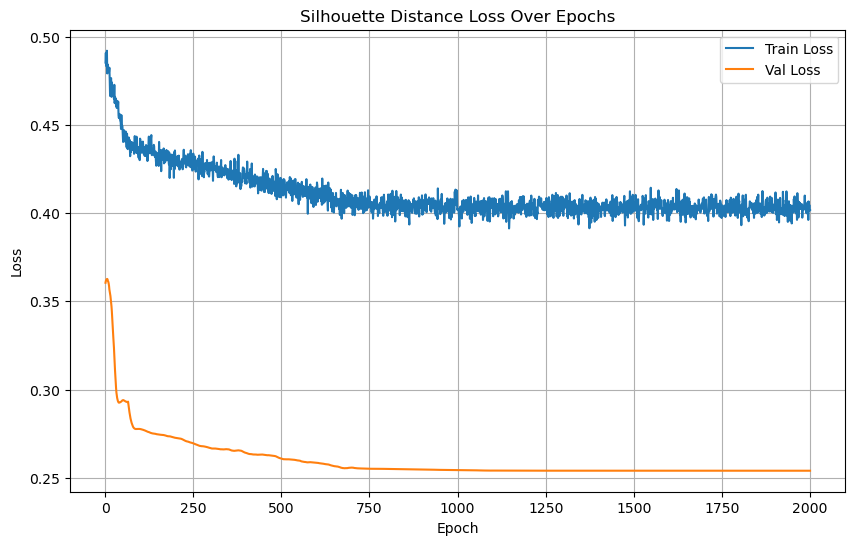

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/48], Loss: 0.3087


Test Batch [20/48], Loss: 0.2200
Test Batch [30/48], Loss: 0.2526
Test Batch [40/48], Loss: 0.5000

Test Loss: 0.2969


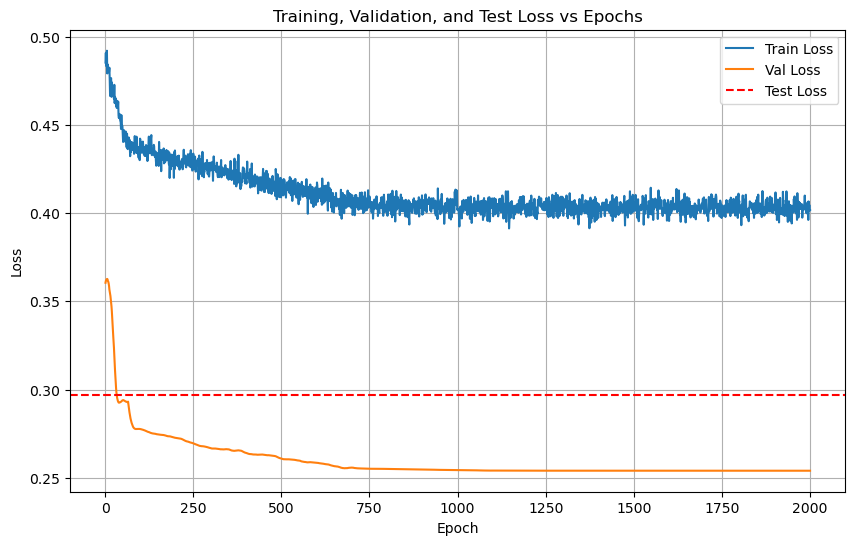

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/48 for test dataset.
  Processed batch 20/48 for test dataset.


  Processed batch 30/48 for test dataset.
  Processed batch 40/48 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 81.43%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.60      0.75         5
           3       0.83      1.00      0.91         5
           4       1.00      0.60      0.75         5
           5       1.00      0.60      0.75         5
           6       1.00      1.00      1.00         5
           7       0.71      1.00      0.83         5
           8       0.67      0.80      0.73         5
           9       0.50      1.00      0.67         5
          10       1.00      0.20      0.33         5
          11       0.83      1.00      0.91         5
          12       0.60      0.60      0.60         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7166  |  Val Loss: 2.7013
Validation loss improved from inf to 2.7013.
[Epoch 2/1000] Train Loss: 2.6996  |  Val Loss: 2.6875
Validation loss improved from 2.7013 to 2.6875.
[Epoch 3/1000] Train Loss: 2.6846  |  Val Loss: 2.6744
Validation loss improved from 2.6875 to 2.6744.
[Epoch 4/1000] Train Loss: 2.6690  |  Val Loss: 2.6615
Validation loss improved from 2.6744 to 2.6615.
[Epoch 5/1000] Train Loss: 2.6537  |  Val Loss: 2.6483
Validation loss improved from 2.6615 to 2.6483.
[Epoch 6/1000] Train Loss: 2.6404  |  Val Loss: 2.6356
Validation loss improved from 2.6483 to 2.6356.
[Epoch 7/1000] Train Loss: 2.6253  |  Val Loss: 2.6238
Validation loss improved from 2.6356 to 2.6238.
[Epoch 8/1000] Train Loss: 2.6118  |  Val Loss: 2.6121
Validation loss improved from 2.6238 to 2.6121.
[Epoch 9/1000] Train Loss: 2.5988  |  Val Loss: 2.6006
Validation loss improved from 2.6121 to 2.6006.
[Epoch 10/1000] Train Loss: 2.5864  |  Val Loss: 2.5891
Validation loss impr

[Epoch 18/1000] Train Loss: 2.4902  |  Val Loss: 2.5024
Validation loss improved from 2.5126 to 2.5024.
[Epoch 19/1000] Train Loss: 2.4783  |  Val Loss: 2.4924
Validation loss improved from 2.5024 to 2.4924.
[Epoch 20/1000] Train Loss: 2.4668  |  Val Loss: 2.4821
Validation loss improved from 2.4924 to 2.4821.
[Epoch 21/1000] Train Loss: 2.4558  |  Val Loss: 2.4715
Validation loss improved from 2.4821 to 2.4715.
[Epoch 22/1000] Train Loss: 2.4449  |  Val Loss: 2.4617
Validation loss improved from 2.4715 to 2.4617.
[Epoch 23/1000] Train Loss: 2.4343  |  Val Loss: 2.4526
Validation loss improved from 2.4617 to 2.4526.


[Epoch 24/1000] Train Loss: 2.4238  |  Val Loss: 2.4438
Validation loss improved from 2.4526 to 2.4438.
[Epoch 25/1000] Train Loss: 2.4137  |  Val Loss: 2.4350
Validation loss improved from 2.4438 to 2.4350.
[Epoch 26/1000] Train Loss: 2.4037  |  Val Loss: 2.4263
Validation loss improved from 2.4350 to 2.4263.
[Epoch 27/1000] Train Loss: 2.3936  |  Val Loss: 2.4174
Validation loss improved from 2.4263 to 2.4174.
[Epoch 28/1000] Train Loss: 2.3837  |  Val Loss: 2.4085
Validation loss improved from 2.4174 to 2.4085.
[Epoch 29/1000] Train Loss: 2.3737  |  Val Loss: 2.3996
Validation loss improved from 2.4085 to 2.3996.
[Epoch 30/1000] Train Loss: 2.3636  |  Val Loss: 2.3908
Validation loss improved from 2.3996 to 2.3908.
[Epoch 31/1000] Train Loss: 2.3540  |  Val Loss: 2.3819
Validation loss improved from 2.3908 to 2.3819.
[Epoch 32/1000] Train Loss: 2.3442  |  Val Loss: 2.3732
Validation loss improved from 2.3819 to 2.3732.
[Epoch 33/1000] Train Loss: 2.3342  |  Val Loss: 2.3648
Validati

[Epoch 49/1000] Train Loss: 2.1691  |  Val Loss: 2.2244
Validation loss improved from 2.2338 to 2.2244.
[Epoch 50/1000] Train Loss: 2.1585  |  Val Loss: 2.2152
Validation loss improved from 2.2244 to 2.2152.
[Epoch 51/1000] Train Loss: 2.1473  |  Val Loss: 2.2062
Validation loss improved from 2.2152 to 2.2062.
[Epoch 52/1000] Train Loss: 2.1363  |  Val Loss: 2.1970
Validation loss improved from 2.2062 to 2.1970.
[Epoch 53/1000] Train Loss: 2.1256  |  Val Loss: 2.1876
Validation loss improved from 2.1970 to 2.1876.
[Epoch 54/1000] Train Loss: 2.1146  |  Val Loss: 2.1783
Validation loss improved from 2.1876 to 2.1783.


[Epoch 55/1000] Train Loss: 2.1036  |  Val Loss: 2.1693
Validation loss improved from 2.1783 to 2.1693.
[Epoch 56/1000] Train Loss: 2.0929  |  Val Loss: 2.1602
Validation loss improved from 2.1693 to 2.1602.
[Epoch 57/1000] Train Loss: 2.0819  |  Val Loss: 2.1510
Validation loss improved from 2.1602 to 2.1510.
[Epoch 58/1000] Train Loss: 2.0716  |  Val Loss: 2.1414
Validation loss improved from 2.1510 to 2.1414.
[Epoch 59/1000] Train Loss: 2.0604  |  Val Loss: 2.1323
Validation loss improved from 2.1414 to 2.1323.
[Epoch 60/1000] Train Loss: 2.0496  |  Val Loss: 2.1236
Validation loss improved from 2.1323 to 2.1236.
[Epoch 61/1000] Train Loss: 2.0395  |  Val Loss: 2.1152
Validation loss improved from 2.1236 to 2.1152.
[Epoch 62/1000] Train Loss: 2.0289  |  Val Loss: 2.1067
Validation loss improved from 2.1152 to 2.1067.
[Epoch 63/1000] Train Loss: 2.0186  |  Val Loss: 2.0983
Validation loss improved from 2.1067 to 2.0983.
[Epoch 64/1000] Train Loss: 2.0081  |  Val Loss: 2.0899
Validati

[Epoch 79/1000] Train Loss: 1.8511  |  Val Loss: 1.9655
Validation loss improved from 1.9735 to 1.9655.
[Epoch 80/1000] Train Loss: 1.8409  |  Val Loss: 1.9573
Validation loss improved from 1.9655 to 1.9573.
[Epoch 81/1000] Train Loss: 1.8305  |  Val Loss: 1.9492
Validation loss improved from 1.9573 to 1.9492.
[Epoch 82/1000] Train Loss: 1.8205  |  Val Loss: 1.9414
Validation loss improved from 1.9492 to 1.9414.
[Epoch 83/1000] Train Loss: 1.8105  |  Val Loss: 1.9337
Validation loss improved from 1.9414 to 1.9337.
[Epoch 84/1000] Train Loss: 1.8005  |  Val Loss: 1.9257
Validation loss improved from 1.9337 to 1.9257.


[Epoch 85/1000] Train Loss: 1.7904  |  Val Loss: 1.9175
Validation loss improved from 1.9257 to 1.9175.
[Epoch 86/1000] Train Loss: 1.7805  |  Val Loss: 1.9094
Validation loss improved from 1.9175 to 1.9094.
[Epoch 87/1000] Train Loss: 1.7704  |  Val Loss: 1.9015
Validation loss improved from 1.9094 to 1.9015.
[Epoch 88/1000] Train Loss: 1.7606  |  Val Loss: 1.8934
Validation loss improved from 1.9015 to 1.8934.
[Epoch 89/1000] Train Loss: 1.7512  |  Val Loss: 1.8851
Validation loss improved from 1.8934 to 1.8851.
[Epoch 90/1000] Train Loss: 1.7409  |  Val Loss: 1.8769
Validation loss improved from 1.8851 to 1.8769.
[Epoch 91/1000] Train Loss: 1.7308  |  Val Loss: 1.8687
Validation loss improved from 1.8769 to 1.8687.
[Epoch 92/1000] Train Loss: 1.7211  |  Val Loss: 1.8606
Validation loss improved from 1.8687 to 1.8606.
[Epoch 93/1000] Train Loss: 1.7112  |  Val Loss: 1.8522
Validation loss improved from 1.8606 to 1.8522.
[Epoch 94/1000] Train Loss: 1.7012  |  Val Loss: 1.8440
Validati

[Epoch 109/1000] Train Loss: 1.5573  |  Val Loss: 1.7281
Validation loss improved from 1.7354 to 1.7281.
[Epoch 110/1000] Train Loss: 1.5476  |  Val Loss: 1.7209
Validation loss improved from 1.7281 to 1.7209.
[Epoch 111/1000] Train Loss: 1.5385  |  Val Loss: 1.7139
Validation loss improved from 1.7209 to 1.7139.
[Epoch 112/1000] Train Loss: 1.5292  |  Val Loss: 1.7071
Validation loss improved from 1.7139 to 1.7071.
[Epoch 113/1000] Train Loss: 1.5201  |  Val Loss: 1.7002
Validation loss improved from 1.7071 to 1.7002.
[Epoch 114/1000] Train Loss: 1.5112  |  Val Loss: 1.6932
Validation loss improved from 1.7002 to 1.6932.
[Epoch 115/1000] Train Loss: 1.5020  |  Val Loss: 1.6860
Validation loss improved from 1.6932 to 1.6860.
[Epoch 116/1000] Train Loss: 1.4932  |  Val Loss: 1.6789
Validation loss improved from 1.6860 to 1.6789.


[Epoch 117/1000] Train Loss: 1.4844  |  Val Loss: 1.6718
Validation loss improved from 1.6789 to 1.6718.
[Epoch 118/1000] Train Loss: 1.4754  |  Val Loss: 1.6645
Validation loss improved from 1.6718 to 1.6645.
[Epoch 119/1000] Train Loss: 1.4664  |  Val Loss: 1.6570
Validation loss improved from 1.6645 to 1.6570.
[Epoch 120/1000] Train Loss: 1.4573  |  Val Loss: 1.6495
Validation loss improved from 1.6570 to 1.6495.
[Epoch 121/1000] Train Loss: 1.4482  |  Val Loss: 1.6423
Validation loss improved from 1.6495 to 1.6423.
[Epoch 122/1000] Train Loss: 1.4392  |  Val Loss: 1.6354
Validation loss improved from 1.6423 to 1.6354.
[Epoch 123/1000] Train Loss: 1.4303  |  Val Loss: 1.6286
Validation loss improved from 1.6354 to 1.6286.
[Epoch 124/1000] Train Loss: 1.4215  |  Val Loss: 1.6217
Validation loss improved from 1.6286 to 1.6217.
[Epoch 125/1000] Train Loss: 1.4125  |  Val Loss: 1.6150
Validation loss improved from 1.6217 to 1.6150.
[Epoch 126/1000] Train Loss: 1.4036  |  Val Loss: 1.608

[Epoch 137/1000] Train Loss: 1.3089  |  Val Loss: 1.5368
Validation loss improved from 1.5435 to 1.5368.
[Epoch 138/1000] Train Loss: 1.3002  |  Val Loss: 1.5303
Validation loss improved from 1.5368 to 1.5303.
[Epoch 139/1000] Train Loss: 1.2916  |  Val Loss: 1.5235
Validation loss improved from 1.5303 to 1.5235.
[Epoch 140/1000] Train Loss: 1.2832  |  Val Loss: 1.5166
Validation loss improved from 1.5235 to 1.5166.
[Epoch 141/1000] Train Loss: 1.2749  |  Val Loss: 1.5093
Validation loss improved from 1.5166 to 1.5093.
[Epoch 142/1000] Train Loss: 1.2669  |  Val Loss: 1.5023
Validation loss improved from 1.5093 to 1.5023.
[Epoch 143/1000] Train Loss: 1.2584  |  Val Loss: 1.4957
Validation loss improved from 1.5023 to 1.4957.
[Epoch 144/1000] Train Loss: 1.2501  |  Val Loss: 1.4893
Validation loss improved from 1.4957 to 1.4893.
[Epoch 145/1000] Train Loss: 1.2419  |  Val Loss: 1.4831
Validation loss improved from 1.4893 to 1.4831.
[Epoch 146/1000] Train Loss: 1.2338  |  Val Loss: 1.477

[Epoch 149/1000] Train Loss: 1.2089  |  Val Loss: 1.4578
Validation loss improved from 1.4649 to 1.4578.
[Epoch 150/1000] Train Loss: 1.2008  |  Val Loss: 1.4506
Validation loss improved from 1.4578 to 1.4506.
[Epoch 151/1000] Train Loss: 1.1925  |  Val Loss: 1.4436
Validation loss improved from 1.4506 to 1.4436.
[Epoch 152/1000] Train Loss: 1.1845  |  Val Loss: 1.4370
Validation loss improved from 1.4436 to 1.4370.
[Epoch 153/1000] Train Loss: 1.1763  |  Val Loss: 1.4304
Validation loss improved from 1.4370 to 1.4304.
[Epoch 154/1000] Train Loss: 1.1683  |  Val Loss: 1.4237
Validation loss improved from 1.4304 to 1.4237.
[Epoch 155/1000] Train Loss: 1.1606  |  Val Loss: 1.4169
Validation loss improved from 1.4237 to 1.4169.
[Epoch 156/1000] Train Loss: 1.1528  |  Val Loss: 1.4099
Validation loss improved from 1.4169 to 1.4099.
[Epoch 157/1000] Train Loss: 1.1446  |  Val Loss: 1.4031
Validation loss improved from 1.4099 to 1.4031.
[Epoch 158/1000] Train Loss: 1.1367  |  Val Loss: 1.396

[Epoch 166/1000] Train Loss: 1.0752  |  Val Loss: 1.3526
Validation loss improved from 1.3576 to 1.3526.
[Epoch 167/1000] Train Loss: 1.0676  |  Val Loss: 1.3473
Validation loss improved from 1.3526 to 1.3473.
[Epoch 168/1000] Train Loss: 1.0600  |  Val Loss: 1.3418
Validation loss improved from 1.3473 to 1.3418.
[Epoch 169/1000] Train Loss: 1.0524  |  Val Loss: 1.3366
Validation loss improved from 1.3418 to 1.3366.
[Epoch 170/1000] Train Loss: 1.0450  |  Val Loss: 1.3315
Validation loss improved from 1.3366 to 1.3315.
[Epoch 171/1000] Train Loss: 1.0377  |  Val Loss: 1.3262
Validation loss improved from 1.3315 to 1.3262.
[Epoch 172/1000] Train Loss: 1.0305  |  Val Loss: 1.3211
Validation loss improved from 1.3262 to 1.3211.
[Epoch 173/1000] Train Loss: 1.0232  |  Val Loss: 1.3161
Validation loss improved from 1.3211 to 1.3161.
[Epoch 174/1000] Train Loss: 1.0162  |  Val Loss: 1.3110
Validation loss improved from 1.3161 to 1.3110.
[Epoch 175/1000] Train Loss: 1.0093  |  Val Loss: 1.305

[Epoch 180/1000] Train Loss: 0.9750  |  Val Loss: 1.2753
Validation loss improved from 1.2802 to 1.2753.
[Epoch 181/1000] Train Loss: 0.9684  |  Val Loss: 1.2708
Validation loss improved from 1.2753 to 1.2708.
[Epoch 182/1000] Train Loss: 0.9613  |  Val Loss: 1.2663
Validation loss improved from 1.2708 to 1.2663.
[Epoch 183/1000] Train Loss: 0.9546  |  Val Loss: 1.2619
Validation loss improved from 1.2663 to 1.2619.
[Epoch 184/1000] Train Loss: 0.9478  |  Val Loss: 1.2570
Validation loss improved from 1.2619 to 1.2570.
[Epoch 185/1000] Train Loss: 0.9411  |  Val Loss: 1.2524
Validation loss improved from 1.2570 to 1.2524.
[Epoch 186/1000] Train Loss: 0.9344  |  Val Loss: 1.2485
Validation loss improved from 1.2524 to 1.2485.
[Epoch 187/1000] Train Loss: 0.9281  |  Val Loss: 1.2448
Validation loss improved from 1.2485 to 1.2448.
[Epoch 188/1000] Train Loss: 0.9215  |  Val Loss: 1.2408
Validation loss improved from 1.2448 to 1.2408.
[Epoch 189/1000] Train Loss: 0.9154  |  Val Loss: 1.237

[Epoch 197/1000] Train Loss: 0.8669  |  Val Loss: 1.2002
Validation loss improved from 1.2051 to 1.2002.
[Epoch 198/1000] Train Loss: 0.8611  |  Val Loss: 1.1963
Validation loss improved from 1.2002 to 1.1963.
[Epoch 199/1000] Train Loss: 0.8554  |  Val Loss: 1.1927
Validation loss improved from 1.1963 to 1.1927.
[Epoch 200/1000] Train Loss: 0.8495  |  Val Loss: 1.1892
Validation loss improved from 1.1927 to 1.1892.
[Epoch 201/1000] Train Loss: 0.8441  |  Val Loss: 1.1858
Validation loss improved from 1.1892 to 1.1858.
[Epoch 202/1000] Train Loss: 0.8385  |  Val Loss: 1.1812
Validation loss improved from 1.1858 to 1.1812.
[Epoch 203/1000] Train Loss: 0.8331  |  Val Loss: 1.1761
Validation loss improved from 1.1812 to 1.1761.
[Epoch 204/1000] Train Loss: 0.8275  |  Val Loss: 1.1706
Validation loss improved from 1.1761 to 1.1706.
[Epoch 205/1000] Train Loss: 0.8220  |  Val Loss: 1.1652
Validation loss improved from 1.1706 to 1.1652.
[Epoch 206/1000] Train Loss: 0.8167  |  Val Loss: 1.159

[Epoch 212/1000] Train Loss: 0.7843  |  Val Loss: 1.1386
Validation loss improved from 1.1414 to 1.1386.
[Epoch 213/1000] Train Loss: 0.7792  |  Val Loss: 1.1358
Validation loss improved from 1.1386 to 1.1358.
[Epoch 214/1000] Train Loss: 0.7745  |  Val Loss: 1.1331
Validation loss improved from 1.1358 to 1.1331.
[Epoch 215/1000] Train Loss: 0.7695  |  Val Loss: 1.1297
Validation loss improved from 1.1331 to 1.1297.
[Epoch 216/1000] Train Loss: 0.7645  |  Val Loss: 1.1263
Validation loss improved from 1.1297 to 1.1263.
[Epoch 217/1000] Train Loss: 0.7597  |  Val Loss: 1.1227
Validation loss improved from 1.1263 to 1.1227.
[Epoch 218/1000] Train Loss: 0.7548  |  Val Loss: 1.1181
Validation loss improved from 1.1227 to 1.1181.
[Epoch 219/1000] Train Loss: 0.7496  |  Val Loss: 1.1132
Validation loss improved from 1.1181 to 1.1132.
[Epoch 220/1000] Train Loss: 0.7449  |  Val Loss: 1.1092
Validation loss improved from 1.1132 to 1.1092.
[Epoch 221/1000] Train Loss: 0.7401  |  Val Loss: 1.105

[Epoch 226/1000] Train Loss: 0.7160  |  Val Loss: 1.0903
Validation loss improved from 1.0926 to 1.0903.
[Epoch 227/1000] Train Loss: 0.7113  |  Val Loss: 1.0878
Validation loss improved from 1.0903 to 1.0878.
[Epoch 228/1000] Train Loss: 0.7068  |  Val Loss: 1.0855
Validation loss improved from 1.0878 to 1.0855.
[Epoch 229/1000] Train Loss: 0.7022  |  Val Loss: 1.0823
Validation loss improved from 1.0855 to 1.0823.
[Epoch 230/1000] Train Loss: 0.6978  |  Val Loss: 1.0780
Validation loss improved from 1.0823 to 1.0780.
[Epoch 231/1000] Train Loss: 0.6932  |  Val Loss: 1.0741
Validation loss improved from 1.0780 to 1.0741.
[Epoch 232/1000] Train Loss: 0.6887  |  Val Loss: 1.0691
Validation loss improved from 1.0741 to 1.0691.
[Epoch 233/1000] Train Loss: 0.6840  |  Val Loss: 1.0644
Validation loss improved from 1.0691 to 1.0644.
[Epoch 234/1000] Train Loss: 0.6793  |  Val Loss: 1.0601
Validation loss improved from 1.0644 to 1.0601.
[Epoch 235/1000] Train Loss: 0.6748  |  Val Loss: 1.055

[Epoch 243/1000] Train Loss: 0.6400  |  Val Loss: 1.0267
Validation loss improved from 1.0297 to 1.0267.
[Epoch 244/1000] Train Loss: 0.6357  |  Val Loss: 1.0241
Validation loss improved from 1.0267 to 1.0241.
[Epoch 245/1000] Train Loss: 0.6315  |  Val Loss: 1.0200
Validation loss improved from 1.0241 to 1.0200.
[Epoch 246/1000] Train Loss: 0.6271  |  Val Loss: 1.0164
Validation loss improved from 1.0200 to 1.0164.
[Epoch 247/1000] Train Loss: 0.6230  |  Val Loss: 1.0131
Validation loss improved from 1.0164 to 1.0131.
[Epoch 248/1000] Train Loss: 0.6191  |  Val Loss: 1.0095
Validation loss improved from 1.0131 to 1.0095.
[Epoch 249/1000] Train Loss: 0.6150  |  Val Loss: 1.0059
Validation loss improved from 1.0095 to 1.0059.
[Epoch 250/1000] Train Loss: 0.6114  |  Val Loss: 1.0021
Validation loss improved from 1.0059 to 1.0021.
[Epoch 251/1000] Train Loss: 0.6072  |  Val Loss: 0.9992
Validation loss improved from 1.0021 to 0.9992.
[Epoch 252/1000] Train Loss: 0.6033  |  Val Loss: 0.996

[Epoch 254/1000] Train Loss: 0.5954  |  Val Loss: 0.9898
Validation loss improved from 0.9934 to 0.9898.
[Epoch 255/1000] Train Loss: 0.5913  |  Val Loss: 0.9861
Validation loss improved from 0.9898 to 0.9861.
[Epoch 256/1000] Train Loss: 0.5872  |  Val Loss: 0.9829
Validation loss improved from 0.9861 to 0.9829.
[Epoch 257/1000] Train Loss: 0.5834  |  Val Loss: 0.9800
Validation loss improved from 0.9829 to 0.9800.
[Epoch 258/1000] Train Loss: 0.5796  |  Val Loss: 0.9772
Validation loss improved from 0.9800 to 0.9772.
[Epoch 259/1000] Train Loss: 0.5759  |  Val Loss: 0.9740
Validation loss improved from 0.9772 to 0.9740.
[Epoch 260/1000] Train Loss: 0.5719  |  Val Loss: 0.9710
Validation loss improved from 0.9740 to 0.9710.
[Epoch 261/1000] Train Loss: 0.5682  |  Val Loss: 0.9683
Validation loss improved from 0.9710 to 0.9683.
[Epoch 262/1000] Train Loss: 0.5643  |  Val Loss: 0.9660
Validation loss improved from 0.9683 to 0.9660.
[Epoch 263/1000] Train Loss: 0.5607  |  Val Loss: 0.963

[Epoch 273/1000] Train Loss: 0.5253  |  Val Loss: 0.9459
Validation loss improved from 0.9486 to 0.9459.
[Epoch 274/1000] Train Loss: 0.5219  |  Val Loss: 0.9429
Validation loss improved from 0.9459 to 0.9429.
[Epoch 275/1000] Train Loss: 0.5184  |  Val Loss: 0.9403
Validation loss improved from 0.9429 to 0.9403.
[Epoch 276/1000] Train Loss: 0.5148  |  Val Loss: 0.9374
Validation loss improved from 0.9403 to 0.9374.
[Epoch 277/1000] Train Loss: 0.5111  |  Val Loss: 0.9345
Validation loss improved from 0.9374 to 0.9345.
[Epoch 278/1000] Train Loss: 0.5074  |  Val Loss: 0.9326
Validation loss improved from 0.9345 to 0.9326.
[Epoch 279/1000] Train Loss: 0.5042  |  Val Loss: 0.9311
Validation loss improved from 0.9326 to 0.9311.
[Epoch 280/1000] Train Loss: 0.5008  |  Val Loss: 0.9297
Validation loss improved from 0.9311 to 0.9297.
[Epoch 281/1000] Train Loss: 0.4974  |  Val Loss: 0.9282
Validation loss improved from 0.9297 to 0.9282.
[Epoch 282/1000] Train Loss: 0.4940  |  Val Loss: 0.926

[Epoch 284/1000] Train Loss: 0.4872  |  Val Loss: 0.9205
Validation loss improved from 0.9234 to 0.9205.
[Epoch 285/1000] Train Loss: 0.4843  |  Val Loss: 0.9178
Validation loss improved from 0.9205 to 0.9178.
[Epoch 286/1000] Train Loss: 0.4809  |  Val Loss: 0.9158
Validation loss improved from 0.9178 to 0.9158.
[Epoch 287/1000] Train Loss: 0.4777  |  Val Loss: 0.9142
Validation loss improved from 0.9158 to 0.9142.
[Epoch 288/1000] Train Loss: 0.4746  |  Val Loss: 0.9126
Validation loss improved from 0.9142 to 0.9126.
[Epoch 289/1000] Train Loss: 0.4714  |  Val Loss: 0.9109
Validation loss improved from 0.9126 to 0.9109.
[Epoch 290/1000] Train Loss: 0.4685  |  Val Loss: 0.9098
Validation loss improved from 0.9109 to 0.9098.
[Epoch 291/1000] Train Loss: 0.4656  |  Val Loss: 0.9081
Validation loss improved from 0.9098 to 0.9081.
[Epoch 292/1000] Train Loss: 0.4627  |  Val Loss: 0.9061
Validation loss improved from 0.9081 to 0.9061.
[Epoch 293/1000] Train Loss: 0.4596  |  Val Loss: 0.903

[Epoch 303/1000] Train Loss: 0.4308  |  Val Loss: 0.8873
Validation loss improved from 0.8886 to 0.8873.
[Epoch 304/1000] Train Loss: 0.4279  |  Val Loss: 0.8859
Validation loss improved from 0.8873 to 0.8859.
[Epoch 305/1000] Train Loss: 0.4252  |  Val Loss: 0.8850
Validation loss improved from 0.8859 to 0.8850.
[Epoch 306/1000] Train Loss: 0.4226  |  Val Loss: 0.8840
Validation loss improved from 0.8850 to 0.8840.
[Epoch 307/1000] Train Loss: 0.4198  |  Val Loss: 0.8824
Validation loss improved from 0.8840 to 0.8824.
[Epoch 308/1000] Train Loss: 0.4171  |  Val Loss: 0.8802
Validation loss improved from 0.8824 to 0.8802.
[Epoch 309/1000] Train Loss: 0.4145  |  Val Loss: 0.8767
Validation loss improved from 0.8802 to 0.8767.
[Epoch 310/1000] Train Loss: 0.4120  |  Val Loss: 0.8740
Validation loss improved from 0.8767 to 0.8740.
[Epoch 311/1000] Train Loss: 0.4093  |  Val Loss: 0.8726
Validation loss improved from 0.8740 to 0.8726.
[Epoch 312/1000] Train Loss: 0.4069  |  Val Loss: 0.871

[Epoch 314/1000] Train Loss: 0.4021  |  Val Loss: 0.8676
Validation loss improved from 0.8696 to 0.8676.
[Epoch 315/1000] Train Loss: 0.3997  |  Val Loss: 0.8662
Validation loss improved from 0.8676 to 0.8662.
[Epoch 316/1000] Train Loss: 0.3973  |  Val Loss: 0.8650
Validation loss improved from 0.8662 to 0.8650.
[Epoch 317/1000] Train Loss: 0.3951  |  Val Loss: 0.8642
Validation loss improved from 0.8650 to 0.8642.
[Epoch 318/1000] Train Loss: 0.3927  |  Val Loss: 0.8631
Validation loss improved from 0.8642 to 0.8631.
[Epoch 319/1000] Train Loss: 0.3904  |  Val Loss: 0.8602
Validation loss improved from 0.8631 to 0.8602.
[Epoch 320/1000] Train Loss: 0.3881  |  Val Loss: 0.8569
Validation loss improved from 0.8602 to 0.8569.
[Epoch 321/1000] Train Loss: 0.3857  |  Val Loss: 0.8536
Validation loss improved from 0.8569 to 0.8536.
[Epoch 322/1000] Train Loss: 0.3832  |  Val Loss: 0.8511
Validation loss improved from 0.8536 to 0.8511.
[Epoch 323/1000] Train Loss: 0.3808  |  Val Loss: 0.848

[Epoch 331/1000] Train Loss: 0.3638  |  Val Loss: 0.8404
Validation loss improved from 0.8415 to 0.8404.
[Epoch 332/1000] Train Loss: 0.3618  |  Val Loss: 0.8396
Validation loss improved from 0.8404 to 0.8396.
[Epoch 333/1000] Train Loss: 0.3597  |  Val Loss: 0.8391
Validation loss improved from 0.8396 to 0.8391.
[Epoch 334/1000] Train Loss: 0.3576  |  Val Loss: 0.8386
Validation loss improved from 0.8391 to 0.8386.
[Epoch 335/1000] Train Loss: 0.3558  |  Val Loss: 0.8375
Validation loss improved from 0.8386 to 0.8375.
[Epoch 336/1000] Train Loss: 0.3538  |  Val Loss: 0.8354
Validation loss improved from 0.8375 to 0.8354.
[Epoch 337/1000] Train Loss: 0.3514  |  Val Loss: 0.8340
Validation loss improved from 0.8354 to 0.8340.
[Epoch 338/1000] Train Loss: 0.3494  |  Val Loss: 0.8323
Validation loss improved from 0.8340 to 0.8323.
[Epoch 339/1000] Train Loss: 0.3472  |  Val Loss: 0.8302
Validation loss improved from 0.8323 to 0.8302.
[Epoch 340/1000] Train Loss: 0.3449  |  Val Loss: 0.826

[Epoch 342/1000] Train Loss: 0.3406  |  Val Loss: 0.8208
Validation loss improved from 0.8234 to 0.8208.
[Epoch 343/1000] Train Loss: 0.3388  |  Val Loss: 0.8176
Validation loss improved from 0.8208 to 0.8176.
[Epoch 344/1000] Train Loss: 0.3370  |  Val Loss: 0.8142
Validation loss improved from 0.8176 to 0.8142.
[Epoch 345/1000] Train Loss: 0.3353  |  Val Loss: 0.8106
Validation loss improved from 0.8142 to 0.8106.
[Epoch 346/1000] Train Loss: 0.3334  |  Val Loss: 0.8077
Validation loss improved from 0.8106 to 0.8077.
[Epoch 347/1000] Train Loss: 0.3318  |  Val Loss: 0.8054
Validation loss improved from 0.8077 to 0.8054.
[Epoch 348/1000] Train Loss: 0.3298  |  Val Loss: 0.8043
Validation loss improved from 0.8054 to 0.8043.
[Epoch 349/1000] Train Loss: 0.3279  |  Val Loss: 0.8034
Validation loss improved from 0.8043 to 0.8034.
[Epoch 350/1000] Train Loss: 0.3261  |  Val Loss: 0.8028
Validation loss improved from 0.8034 to 0.8028.
[Epoch 351/1000] Train Loss: 0.3242  |  Val Loss: 0.803

[Epoch 361/1000] Train Loss: 0.3066  |  Val Loss: 0.7952
Validation loss improved from 0.7953 to 0.7952.
[Epoch 362/1000] Train Loss: 0.3053  |  Val Loss: 0.7947
Validation loss improved from 0.7952 to 0.7947.
[Epoch 363/1000] Train Loss: 0.3036  |  Val Loss: 0.7933
Validation loss improved from 0.7947 to 0.7933.
[Epoch 364/1000] Train Loss: 0.3020  |  Val Loss: 0.7923
Validation loss improved from 0.7933 to 0.7923.
[Epoch 365/1000] Train Loss: 0.3005  |  Val Loss: 0.7918
Validation loss improved from 0.7923 to 0.7918.
[Epoch 366/1000] Train Loss: 0.2988  |  Val Loss: 0.7921
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 367/1000] Train Loss: 0.2977  |  Val Loss: 0.7928
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 368/1000] Train Loss: 0.2961  |  Val Loss: 0.7920
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 369/1000] Train Loss: 0.2944  |  Val Loss: 0.7906
Validation loss improved from 0.7918 to 0.7906.
[Epoch 370/1000] Train Loss: 0.2934  

[Epoch 372/1000] Train Loss: 0.2908  |  Val Loss: 0.7849
Validation loss improved from 0.7863 to 0.7849.
[Epoch 373/1000] Train Loss: 0.2892  |  Val Loss: 0.7838
Validation loss improved from 0.7849 to 0.7838.
[Epoch 374/1000] Train Loss: 0.2875  |  Val Loss: 0.7821
Validation loss improved from 0.7838 to 0.7821.
[Epoch 375/1000] Train Loss: 0.2860  |  Val Loss: 0.7807
Validation loss improved from 0.7821 to 0.7807.
[Epoch 376/1000] Train Loss: 0.2843  |  Val Loss: 0.7782
Validation loss improved from 0.7807 to 0.7782.
[Epoch 377/1000] Train Loss: 0.2829  |  Val Loss: 0.7759
Validation loss improved from 0.7782 to 0.7759.
[Epoch 378/1000] Train Loss: 0.2815  |  Val Loss: 0.7740
Validation loss improved from 0.7759 to 0.7740.
[Epoch 379/1000] Train Loss: 0.2799  |  Val Loss: 0.7728
Validation loss improved from 0.7740 to 0.7728.
[Epoch 380/1000] Train Loss: 0.2784  |  Val Loss: 0.7722
Validation loss improved from 0.7728 to 0.7722.
[Epoch 381/1000] Train Loss: 0.2769  |  Val Loss: 0.771

[Epoch 391/1000] Train Loss: 0.2632  |  Val Loss: 0.7663
Validation loss improved from 0.7685 to 0.7663.
[Epoch 392/1000] Train Loss: 0.2621  |  Val Loss: 0.7645
Validation loss improved from 0.7663 to 0.7645.
[Epoch 393/1000] Train Loss: 0.2607  |  Val Loss: 0.7634
Validation loss improved from 0.7645 to 0.7634.
[Epoch 394/1000] Train Loss: 0.2594  |  Val Loss: 0.7625
Validation loss improved from 0.7634 to 0.7625.
[Epoch 395/1000] Train Loss: 0.2582  |  Val Loss: 0.7621
Validation loss improved from 0.7625 to 0.7621.
[Epoch 396/1000] Train Loss: 0.2570  |  Val Loss: 0.7620
Validation loss improved from 0.7621 to 0.7620.
[Epoch 397/1000] Train Loss: 0.2557  |  Val Loss: 0.7626
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 398/1000] Train Loss: 0.2545  |  Val Loss: 0.7630
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 399/1000] Train Loss: 0.2531  |  Val Loss: 0.7628
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 400/1000] Train Loss: 0.2518  

[Epoch 401/1000] Train Loss: 0.2505  |  Val Loss: 0.7615
Validation loss improved from 0.7620 to 0.7615.
[Epoch 402/1000] Train Loss: 0.2496  |  Val Loss: 0.7609
Validation loss improved from 0.7615 to 0.7609.
[Epoch 403/1000] Train Loss: 0.2484  |  Val Loss: 0.7604
Validation loss improved from 0.7609 to 0.7604.
[Epoch 404/1000] Train Loss: 0.2471  |  Val Loss: 0.7610
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 405/1000] Train Loss: 0.2458  |  Val Loss: 0.7611
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 406/1000] Train Loss: 0.2447  |  Val Loss: 0.7602
Validation loss improved from 0.7604 to 0.7602.
[Epoch 407/1000] Train Loss: 0.2437  |  Val Loss: 0.7601
Validation loss improved from 0.7602 to 0.7601.
[Epoch 408/1000] Train Loss: 0.2424  |  Val Loss: 0.7594
Validation loss improved from 0.7601 to 0.7594.
[Epoch 409/1000] Train Loss: 0.2412  |  Val Loss: 0.7584
Validation loss improved from 0.7594 to 0.7584.
[Epoch 410/1000] Train Loss: 0.2400  |  Val

[Epoch 420/1000] Train Loss: 0.2290  |  Val Loss: 0.7410
Validation loss improved from 0.7412 to 0.7410.
[Epoch 421/1000] Train Loss: 0.2281  |  Val Loss: 0.7405
Validation loss improved from 0.7410 to 0.7405.
[Epoch 422/1000] Train Loss: 0.2272  |  Val Loss: 0.7395
Validation loss improved from 0.7405 to 0.7395.
[Epoch 423/1000] Train Loss: 0.2263  |  Val Loss: 0.7399
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 424/1000] Train Loss: 0.2248  |  Val Loss: 0.7406
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 425/1000] Train Loss: 0.2238  |  Val Loss: 0.7414
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 426/1000] Train Loss: 0.2227  |  Val Loss: 0.7422
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 427/1000] Train Loss: 0.2217  |  Val Loss: 0.7428
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 428/1000] Train Loss: 0.2206  |  Val Loss: 0.7433
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 429/1000] Tr

[Epoch 430/1000] Train Loss: 0.2186  |  Val Loss: 0.7444
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 431/1000] Train Loss: 0.2177  |  Val Loss: 0.7448
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 432/1000] Train Loss: 0.2168  |  Val Loss: 0.7441
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 433/1000] Train Loss: 0.2161  |  Val Loss: 0.7436
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 434/1000] Train Loss: 0.2150  |  Val Loss: 0.7434
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 435/1000] Train Loss: 0.2140  |  Val Loss: 0.7428
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 436/1000] Train Loss: 0.2131  |  Val Loss: 0.7422
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 437/1000] Train Loss: 0.2123  |  Val Loss: 0.7420
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 438/1000] Train Loss: 0.2112  |  Val Loss: 0.7428
!! Validation loss did NOT improve !! Patience: 1

[Epoch 452/1000] Train Loss: 0.1982  |  Val Loss: 0.7358
Validation loss improved from 0.7380 to 0.7358.
[Epoch 453/1000] Train Loss: 0.1973  |  Val Loss: 0.7349
Validation loss improved from 0.7358 to 0.7349.
[Epoch 454/1000] Train Loss: 0.1965  |  Val Loss: 0.7348
Validation loss improved from 0.7349 to 0.7348.
[Epoch 455/1000] Train Loss: 0.1960  |  Val Loss: 0.7357
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 456/1000] Train Loss: 0.1951  |  Val Loss: 0.7360
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 457/1000] Train Loss: 0.1942  |  Val Loss: 0.7358
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 458/1000] Train Loss: 0.1936  |  Val Loss: 0.7362
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 459/1000] Train Loss: 0.1930  |  Val Loss: 0.7352
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 460/1000] Train Loss: 0.1922  |  Val Loss: 0.7337
Validation loss improved from 0.7348 to 0.7337.


[Epoch 461/1000] Train Loss: 0.1913  |  Val Loss: 0.7323
Validation loss improved from 0.7337 to 0.7323.
[Epoch 462/1000] Train Loss: 0.1904  |  Val Loss: 0.7313
Validation loss improved from 0.7323 to 0.7313.
[Epoch 463/1000] Train Loss: 0.1893  |  Val Loss: 0.7309
Validation loss improved from 0.7313 to 0.7309.
[Epoch 464/1000] Train Loss: 0.1884  |  Val Loss: 0.7308
Validation loss improved from 0.7309 to 0.7308.
[Epoch 465/1000] Train Loss: 0.1873  |  Val Loss: 0.7299
Validation loss improved from 0.7308 to 0.7299.
[Epoch 466/1000] Train Loss: 0.1863  |  Val Loss: 0.7290
Validation loss improved from 0.7299 to 0.7290.
[Epoch 467/1000] Train Loss: 0.1857  |  Val Loss: 0.7284
Validation loss improved from 0.7290 to 0.7284.
[Epoch 468/1000] Train Loss: 0.1847  |  Val Loss: 0.7273
Validation loss improved from 0.7284 to 0.7273.
[Epoch 469/1000] Train Loss: 0.1839  |  Val Loss: 0.7259
Validation loss improved from 0.7273 to 0.7259.
[Epoch 470/1000] Train Loss: 0.1832  |  Val Loss: 0.723

[Epoch 483/1000] Train Loss: 0.1736  |  Val Loss: 0.7087
Validation loss improved from 0.7090 to 0.7087.
[Epoch 484/1000] Train Loss: 0.1727  |  Val Loss: 0.7090
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 485/1000] Train Loss: 0.1719  |  Val Loss: 0.7098
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 486/1000] Train Loss: 0.1711  |  Val Loss: 0.7103
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 487/1000] Train Loss: 0.1703  |  Val Loss: 0.7095
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 488/1000] Train Loss: 0.1696  |  Val Loss: 0.7097
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 489/1000] Train Loss: 0.1688  |  Val Loss: 0.7089
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 490/1000] Train Loss: 0.1679  |  Val Loss: 0.7066
Validation loss improved from 0.7087 to 0.7066.


[Epoch 491/1000] Train Loss: 0.1674  |  Val Loss: 0.7045
Validation loss improved from 0.7066 to 0.7045.
[Epoch 492/1000] Train Loss: 0.1666  |  Val Loss: 0.7014
Validation loss improved from 0.7045 to 0.7014.
[Epoch 493/1000] Train Loss: 0.1661  |  Val Loss: 0.6997
Validation loss improved from 0.7014 to 0.6997.
[Epoch 494/1000] Train Loss: 0.1656  |  Val Loss: 0.6994
Validation loss improved from 0.6997 to 0.6994.
[Epoch 495/1000] Train Loss: 0.1649  |  Val Loss: 0.6997
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 496/1000] Train Loss: 0.1639  |  Val Loss: 0.7013
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 497/1000] Train Loss: 0.1629  |  Val Loss: 0.7042
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 498/1000] Train Loss: 0.1620  |  Val Loss: 0.7072
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 499/1000] Train Loss: 0.1613  |  Val Loss: 0.7103
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 500/1000] Train Lo

[Epoch 514/1000] Train Loss: 0.1519  |  Val Loss: 0.6962
Validation loss improved from 0.6966 to 0.6962.
[Epoch 515/1000] Train Loss: 0.1511  |  Val Loss: 0.6958
Validation loss improved from 0.6962 to 0.6958.
[Epoch 516/1000] Train Loss: 0.1506  |  Val Loss: 0.6954
Validation loss improved from 0.6958 to 0.6954.
[Epoch 517/1000] Train Loss: 0.1500  |  Val Loss: 0.6948
Validation loss improved from 0.6954 to 0.6948.
[Epoch 518/1000] Train Loss: 0.1494  |  Val Loss: 0.6937
Validation loss improved from 0.6948 to 0.6937.
[Epoch 519/1000] Train Loss: 0.1488  |  Val Loss: 0.6937
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 520/1000] Train Loss: 0.1482  |  Val Loss: 0.6940
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 521/1000] Train Loss: 0.1477  |  Val Loss: 0.6951
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 522/1000] Train Loss: 0.1469  |  Val Loss: 0.6953
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 523/1000] Train Loss: 0.1461  |  Val Loss: 0.6951
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 524/1000] Train Loss: 0.1458  |  Val Loss: 0.6953
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 525/1000] Train Loss: 0.1451  |  Val Loss: 0.6967
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 526/1000] Train Loss: 0.1444  |  Val Loss: 0.6991
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 527/1000] Train Loss: 0.1439  |  Val Loss: 0.7005
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 528/1000] Train Loss: 0.1433  |  Val Loss: 0.7001
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 529/1000] Train Loss: 0.1427  |  Val Loss: 0.7010
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 530/1000] Train Loss: 0.1422  |  Val Loss: 0.7018
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 546/1000] Train Loss: 0.1337  |  Val Loss: 0.7123
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 547/1000] Train Loss: 0.1334  |  Val Loss: 0.7122
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 548/1000] Train Loss: 0.1331  |  Val Loss: 0.7125
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 549/1000] Train Loss: 0.1326  |  Val Loss: 0.7128
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 550/1000] Train Loss: 0.1321  |  Val Loss: 0.7132
!! Validation loss did NOT improve !! Patience: 32/100


[Epoch 551/1000] Train Loss: 0.1313  |  Val Loss: 0.7130
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 552/1000] Train Loss: 0.1306  |  Val Loss: 0.7122
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 553/1000] Train Loss: 0.1296  |  Val Loss: 0.7123
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 554/1000] Train Loss: 0.1291  |  Val Loss: 0.7124
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 555/1000] Train Loss: 0.1284  |  Val Loss: 0.7122
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 556/1000] Train Loss: 0.1278  |  Val Loss: 0.7115
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 557/1000] Train Loss: 0.1272  |  Val Loss: 0.7109
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 558/1000] Train Loss: 0.1266  |  Val Loss: 0.7108
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 559/1000] Train Loss: 0.1262  |  Val Loss: 0.7097
!! Validation loss did NOT improve !! Patience:

[Epoch 575/1000] Train Loss: 0.1190  |  Val Loss: 0.6782
Validation loss improved from 0.6784 to 0.6782.
[Epoch 576/1000] Train Loss: 0.1183  |  Val Loss: 0.6796
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 577/1000] Train Loss: 0.1176  |  Val Loss: 0.6818
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 578/1000] Train Loss: 0.1170  |  Val Loss: 0.6849
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 579/1000] Train Loss: 0.1162  |  Val Loss: 0.6878
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 580/1000] Train Loss: 0.1161  |  Val Loss: 0.6913
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 581/1000] Train Loss: 0.1157  |  Val Loss: 0.6938
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 582/1000] Train Loss: 0.1155  |  Val Loss: 0.6963
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 583/1000] Train Loss: 0.1150  |  Val Loss: 0.6979
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 584/1000] Train Loss: 0.1147  |  Val Loss: 0.6994
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 585/1000] Train Loss: 0.1140  |  Val Loss: 0.6999
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 586/1000] Train Loss: 0.1134  |  Val Loss: 0.6984
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 587/1000] Train Loss: 0.1129  |  Val Loss: 0.6965
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 588/1000] Train Loss: 0.1124  |  Val Loss: 0.6933
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 589/1000] Train Loss: 0.1117  |  Val Loss: 0.6910
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 590/1000] Train Loss: 0.1112  |  Val Loss: 0.6890
!! Validation loss did NOT improve !! Patience: 15

[Epoch 606/1000] Train Loss: 0.1043  |  Val Loss: 0.6883
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 607/1000] Train Loss: 0.1037  |  Val Loss: 0.6884
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 608/1000] Train Loss: 0.1033  |  Val Loss: 0.6877
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 609/1000] Train Loss: 0.1030  |  Val Loss: 0.6863
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 610/1000] Train Loss: 0.1026  |  Val Loss: 0.6858
!! Validation loss did NOT improve !! Patience: 35/100


[Epoch 611/1000] Train Loss: 0.1023  |  Val Loss: 0.6844
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 612/1000] Train Loss: 0.1020  |  Val Loss: 0.6829
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 613/1000] Train Loss: 0.1017  |  Val Loss: 0.6824
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 614/1000] Train Loss: 0.1011  |  Val Loss: 0.6831
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 615/1000] Train Loss: 0.1009  |  Val Loss: 0.6838
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 616/1000] Train Loss: 0.1004  |  Val Loss: 0.6845
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 617/1000] Train Loss: 0.0998  |  Val Loss: 0.6850
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 618/1000] Train Loss: 0.0994  |  Val Loss: 0.6853
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 619/1000] Train Loss: 0.0991  |  Val Loss: 0.6842
!! Validation loss did NOT improve !! Patience:

[Epoch 634/1000] Train Loss: 0.0932  |  Val Loss: 0.6934
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 635/1000] Train Loss: 0.0928  |  Val Loss: 0.6963
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 636/1000] Train Loss: 0.0926  |  Val Loss: 0.6979
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 637/1000] Train Loss: 0.0922  |  Val Loss: 0.6975
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 638/1000] Train Loss: 0.0916  |  Val Loss: 0.6951
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 639/1000] Train Loss: 0.0914  |  Val Loss: 0.6922
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 640/1000] Train Loss: 0.0908  |  Val Loss: 0.6909
!! Validation loss did NOT improve !! Patience: 65/100


[Epoch 641/1000] Train Loss: 0.0905  |  Val Loss: 0.6887
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 642/1000] Train Loss: 0.0902  |  Val Loss: 0.6868
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 643/1000] Train Loss: 0.0901  |  Val Loss: 0.6867
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 644/1000] Train Loss: 0.0899  |  Val Loss: 0.6878
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 645/1000] Train Loss: 0.0897  |  Val Loss: 0.6892
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 646/1000] Train Loss: 0.0892  |  Val Loss: 0.6901
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 647/1000] Train Loss: 0.0888  |  Val Loss: 0.6923
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 648/1000] Train Loss: 0.0885  |  Val Loss: 0.6955
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 649/1000] Train Loss: 0.0880  |  Val Loss: 0.6966
!! Validation loss did NOT improve !! Patience:

[Epoch 663/1000] Train Loss: 0.0834  |  Val Loss: 0.6832
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 664/1000] Train Loss: 0.0830  |  Val Loss: 0.6829
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 665/1000] Train Loss: 0.0827  |  Val Loss: 0.6834
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 666/1000] Train Loss: 0.0824  |  Val Loss: 0.6839
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 667/1000] Train Loss: 0.0820  |  Val Loss: 0.6845
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 668/1000] Train Loss: 0.0817  |  Val Loss: 0.6848
!! Validation loss did NOT improve !! Patience: 93/100


[Epoch 669/1000] Train Loss: 0.0813  |  Val Loss: 0.6847
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 670/1000] Train Loss: 0.0811  |  Val Loss: 0.6847
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 671/1000] Train Loss: 0.0809  |  Val Loss: 0.6860
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 672/1000] Train Loss: 0.0806  |  Val Loss: 0.6876
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 673/1000] Train Loss: 0.0801  |  Val Loss: 0.6880
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 674/1000] Train Loss: 0.0797  |  Val Loss: 0.6887
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 675/1000] Train Loss: 0.0794  |  Val Loss: 0.6887
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 675 !!
No improvement for 100 epochs.


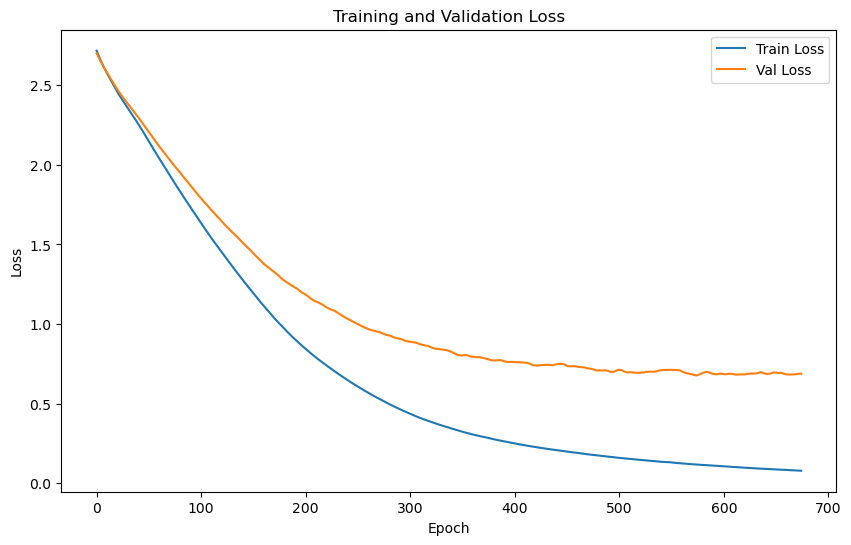

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.4986 | Test Accuracy: 82.82%


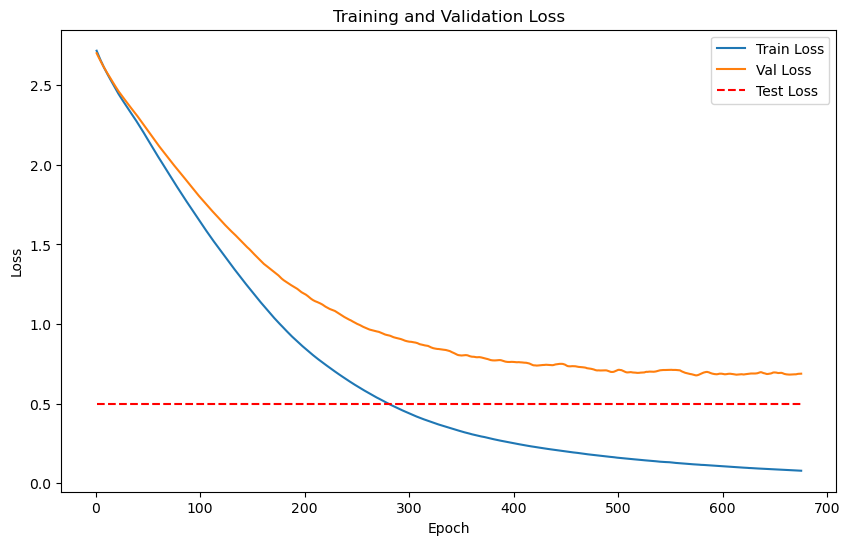

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


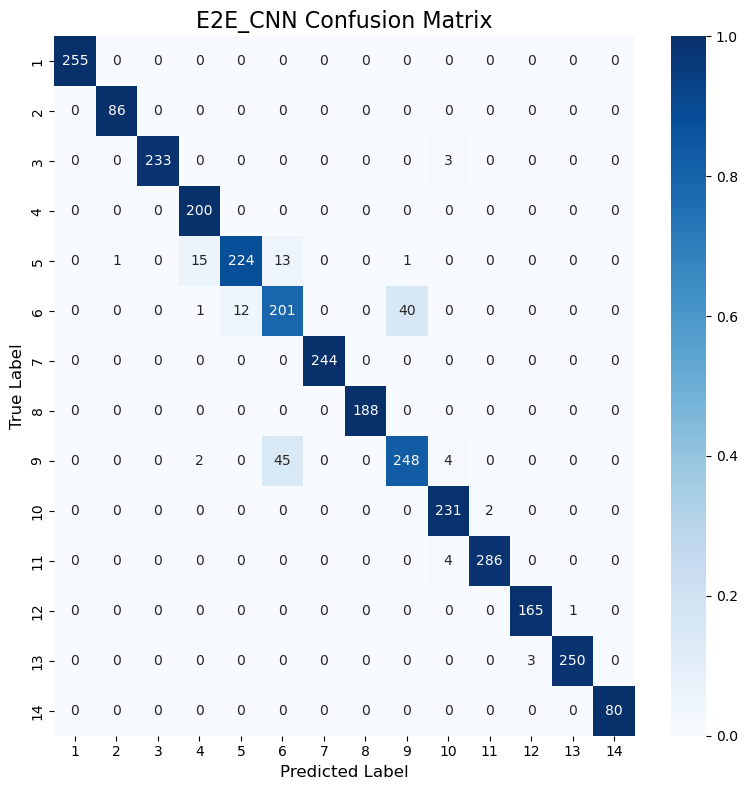

Classification Accuracy: 95.16%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


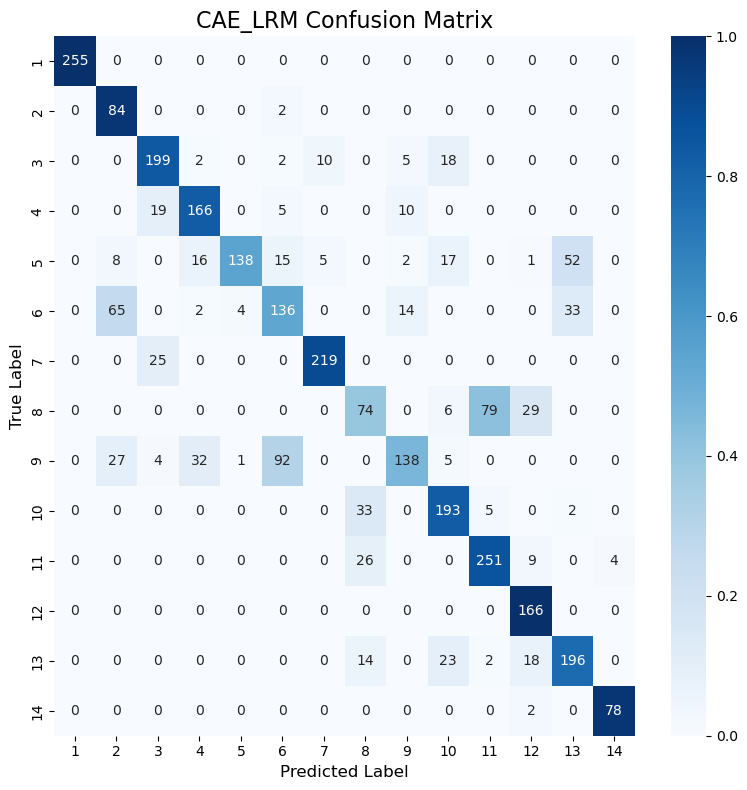

Classification Accuracy: 75.48%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


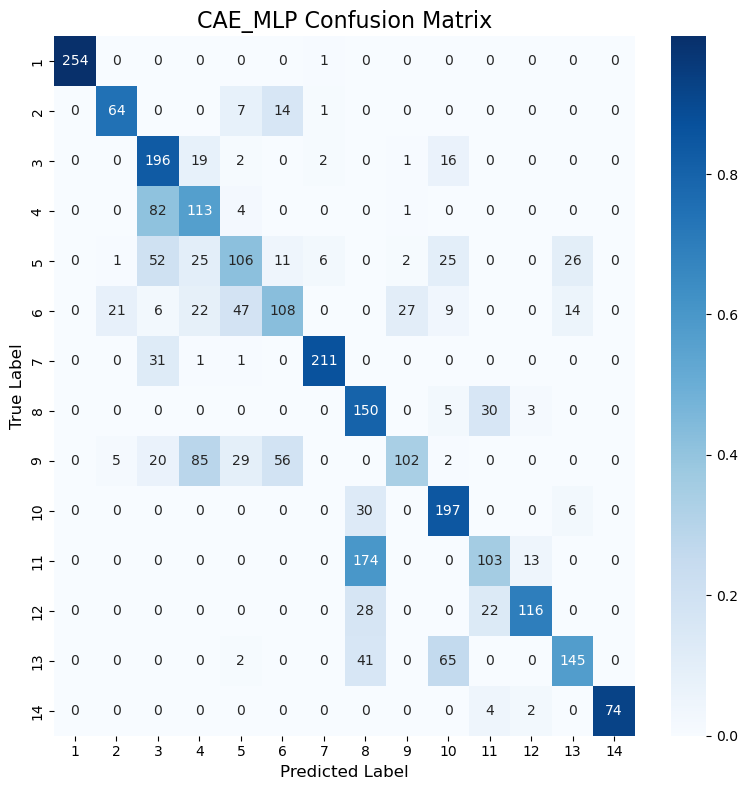

Classification Accuracy: 63.82%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


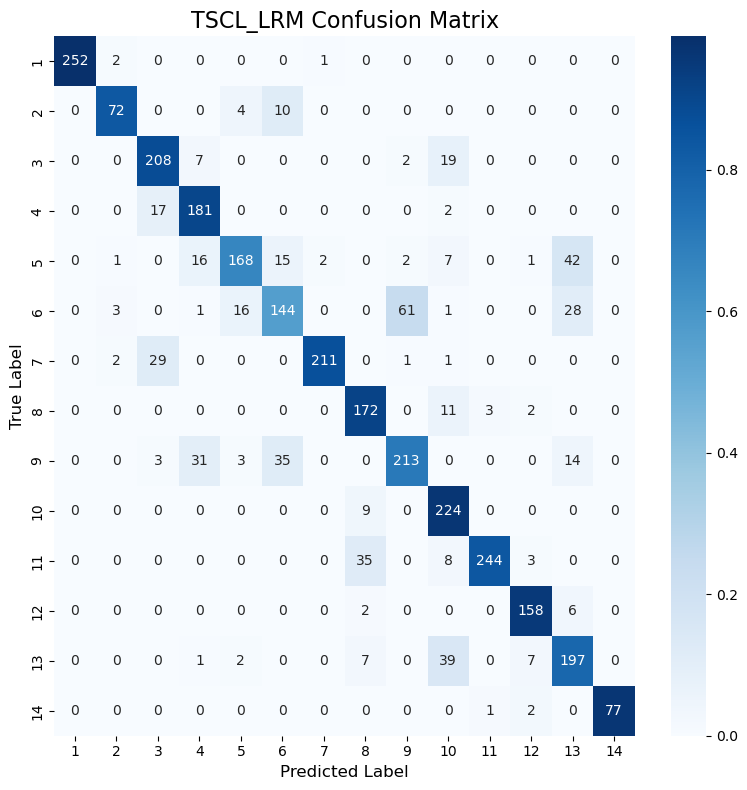

Classification Accuracy: 82.98%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


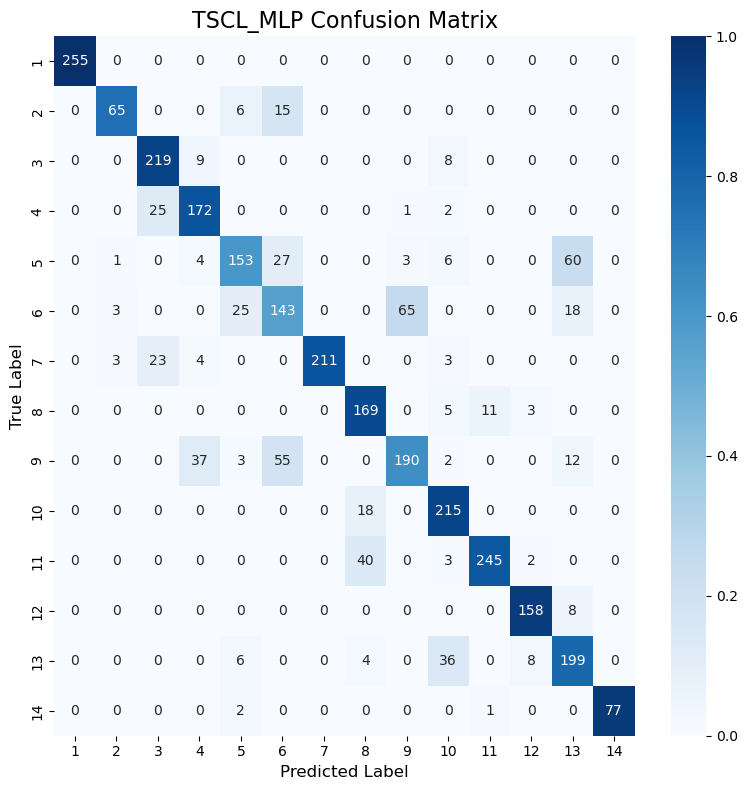

Classification Accuracy: 81.34%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


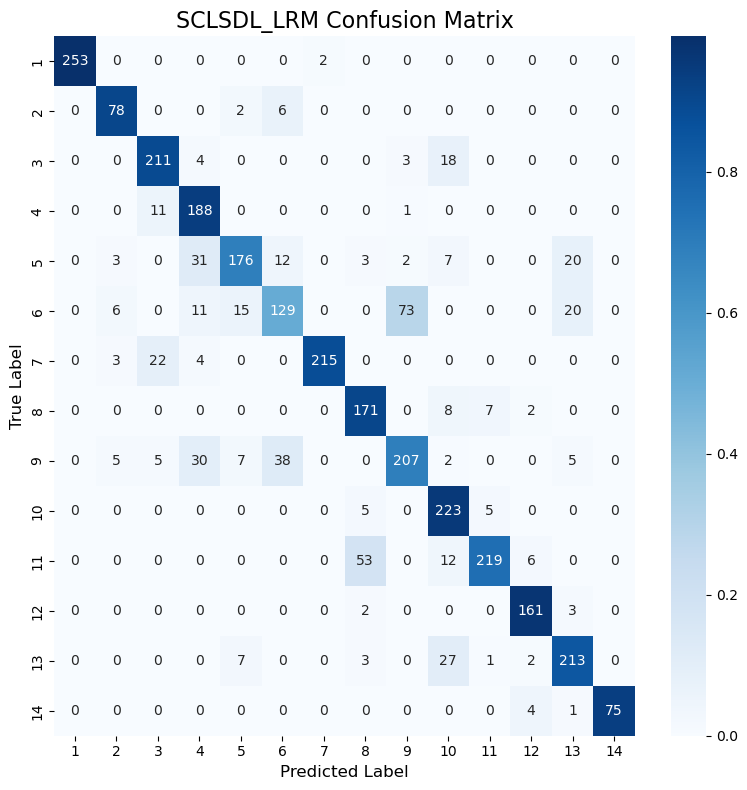

Classification Accuracy: 82.92%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


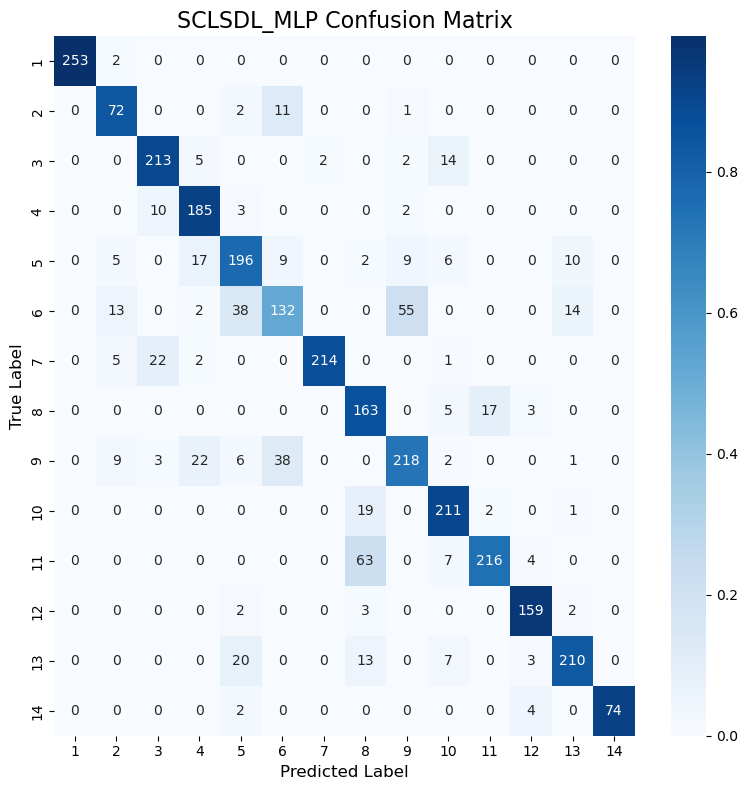

Classification Accuracy: 82.82%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          95.16
1    LRM (CAE)          75.48
2    MLP (CAE)          63.82
3     TSCL LRM          82.98
4     TSCL MLP          81.34
5  SCL_SDL LRM          82.92
6  SCL_SDL MLP          82.82

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          95.16
3     TSCL LRM          82.98
5  SCL_SDL LRM          82.92
6  SCL_SDL MLP          82.82
4     TSCL MLP          81.34
1    LRM (CAE)          75.48
2    MLP (CAE)          63.82
